In [2]:
from os import listdir
from os.path import isfile, join
from random import shuffle

# Reading all of the negative and positive reviews into a tuple list
neg_path = 'aclImdb/train/neg'
pos_path = 'aclImdb/train/pos'
negative_files = [f for f in listdir(neg_path) if isfile(join(neg_path, f))]
postive_files = [f for f in listdir(pos_path) if isfile(join(pos_path, f))]

data = []
for neg_file in negative_files:
    with open(neg_path + '/' + neg_file, 'r') as f:
        review = f.read()
        data.append( (0,review) )
num_neg_reviews = len(data)
print('There are {} negative reviews.'.format(num_neg_reviews))
for pos_file in postive_files:
    with open(pos_path + '/' + pos_file, 'r') as f:
        review = f.read()
        data.append( (1,review) )
print('There are {} positive reviews.'.format(len(data) - num_neg_reviews))
print('Loaded {} examples'.format(str(len(data))))
print()
print(data[0])
print()
print(data[len(data)-1])        

There are 12500 negative reviews.
There are 12500 positive reviews.
Loaded 25000 examples

(0, "Working with one of the best Shakespeare sources, this film manages to be creditable to it's source, whilst still appealing to a wider audience.<br /><br />Branagh steals the film from under Fishburne's nose, and there's a talented cast on good form.")

(1, "Enchanted April is a tone poem, an impressionist painting, a masterpiece of conveying a message with few words. It has been one of my 10 favorite films since it came out. I continue to wait, albeit less patiently, for the film to come out in DVD format. Apparently, I am not alone.<br /><br />If parent company Amazon's listings are correct, there are many people who want this title in DVD format. Many people want to go to Italy with this cast and this script. Many people want to keep a permanent copy of this film in their libraries. The cast is spectacular, the cinematography and direction impeccable. The film is a definite keeper. Many h

In [3]:
# Avoid any ordering bias by randomly shuffling the list
print([target[0] for target in data[0:10]])
shuffle(data)
print([target[0] for target in data[0:10]])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0, 1]


In [4]:
# Create a validation set from the training data
train_split = 20000

train_data = data[:train_split]
train_x = [data[1] for data in train_data]
train_y = [data[0] for data in train_data]

val_data = data[train_split:]
val_x = [data[1] for data in val_data]
val_y = [data[0] for data in val_data]

print('{} training samples'.format(len(train_data)))
print([target for target in train_y[0:10]])
print('{} validation samples'.format(len(val_data)))
print([target for target in val_y[0:10]])


20000 training samples
[1, 1, 1, 1, 0, 0, 0, 0, 0, 1]
5000 validation samples
[0, 0, 0, 1, 0, 0, 1, 0, 0, 0]


In [ ]:
# Assess performance on the test set
# Reading all of the negative and positive reviews into a tuple list
neg_path = 'aclImdb/test/neg'
pos_path = 'aclImdb/test/pos'
negative_files = [f for f in listdir(neg_path) if isfile(join(neg_path, f))]
postive_files = [f for f in listdir(pos_path) if isfile(join(pos_path, f))]

test_data = []
for neg_file in negative_files:
    with open(neg_path + '/' + neg_file, 'r') as f:
        review = f.read()
        test_data.append( (0,review) )
num_neg_reviews = len(test_data)
print('There are {} negative test reviews.'.format(num_neg_reviews))
for pos_file in postive_files:
    with open(pos_path + '/' + pos_file, 'r') as f:
        review = f.read()
        test_data.append( (1,review) )
print('There are {} positive test reviews.'.format(len(test_data) - num_neg_reviews))
print('Loaded {} examples'.format(str(len(test_data))))
print()
print(test_data[0])
print()
print(test_data[len(test_data)-1])   

In [ ]:
test_x = [data_t[1] for data_t in test_data]
test_y = [data_t[0] for data_t in test_data]

print('{} test samples'.format(len(test_data)))
print([target for target in test_y[0:10]])

In [97]:
# Tokenize the reviews
import nltk
import os
import pickle as pkl
import spacy
import string

from tqdm import tqdm_notebook

class NGramBuilder(object):
    """
    Class which enables hyperparameter searching over the word tokenization process
    """
    # save index 0 for unk and 1 for pad
    PAD_IDX = 0
    UNK_IDX = 1
    def __init__(self, max_vocab_size, n_gram_size, all_permutations=True):
        """
        all_permutations: if True then that means if you picked an n-gram size of 3, then you would have
        all the 1-gram and 2-gram combos included as well.
        """
        self.tokenizer = spacy.load('en_core_web_sm')
        self.punctuations = string.punctuation
        self.max_vocab_size = max_vocab_size
        self.n_gram_size = n_gram_size
        self.all_permutations = all_permutations
        self.vocabulary_tokens = []
    
    def _lower_case_remove_punc(self, parsed):
        return [token.text.lower() for token in parsed if (token.text not in self.punctuations)]

    def tokenize_dataset(self, dataset, training=False):
        token_dataset = []
        print(dataset[0])
        for sample in tqdm_notebook(tokenizer.pipe(dataset, disable=['parser', 'tagger', 'ner'], batch_size=512, n_threads=1)):
            tokens = self._lower_case_remove_punc(sample)
            all_tokens = []
            previous_token = ''
            prev_previous_token = ''
            while tokens:
                token = tokens.pop()
                all_tokens += [token]
                if self.n_gram_size == 2:
                    if previous_token:
                        # Order is now reversed
                        all_tokens += [token + ' ' + previous_token]
                    previous_token = token
                if self.n_gram_size == 3:
                    if prev_previous_token:
                        # Order is now reversed
                        all_tokens += [token + ' ' + previous_token + ' ' + prev_previous_token]
                    elif previous_token:
                        all_tokens += [token + ' ' + previous_token]
                    else:
                        pass
                prev_previous_token = previous_token
                previous_token = token
            token_dataset.append(all_tokens)
            if training:
                self.vocabulary_tokens += all_tokens
        return token_dataset
    
    def build_vocab(self):
        # Returns:
        # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
        # token2id: dictionary where keys represent tokens and corresponding values represent indices
        token_counter = Counter(self.vocabulary_tokens)
        vocab, count = zip(*token_counter.most_common(self.max_vocab_size))
        id2token = list(vocab)
        token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
        id2token = ['<pad>', '<unk>'] + id2token
        token2id['<pad>'] = PAD_IDX 
        token2id['<unk>'] = UNK_IDX
        return token2id, id2token
    
    def token2index_dataset(tokens_data):
        indices_data = []
        for tokens in tokens_data:
            index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
            indices_data.append(index_list)
        return indices_data
    
    def get_indexed_dataset_from_training_text_vector(self, text_vector, overwrite=True):
        data_tokens = None
        training_pickle_path = "train_data_tokens.p"
        vocab_pickle_path = "vocabulary.p"
        
        if os.path.isfile(training_pickle_path) and os.path.isfile(vocab_pickle_path) and not overwrite:
            print("Loading existing training token pickle file and vocabulary.")
            train_data_tokens = pkl.load(open(training_pickle_path, "rb"))
            self.vocabulary_tokens = pkl.load(open(vocab_pickle_path, "rb"))
        else:
            train_data_tokens = self.tokenize_dataset(text_vector, training=True)
            pkl.dump(train_data_tokens, open(training_pickle_path, "wb"))
            self.build_vocab()
            pkl.dump(self.vocabulary_tokens, open(vocab_pickle_path, "wb"))
            
        train_data_indices = token2index_dataset(train_data_tokens)
        return train_data_indices
        
    
    def get_indexed_dataset_from_val_and_test_vector(self, val_vector, test_vector, overwrite=True):
        if not self.vocabulary_tokens:
            raise ValueError('Must load training set prior to validationa and test sets')
        data_tokens = None
        
        val_pickle_path = "train_data_tokens.p"
        test_pickle_path = "val_data_tokens.p"
        
        if os.path.isfile(val_pickle_path) and os.path.isfile(test_pickle_path) and not overwrite:
            print("Loading existing training token pickle file and vocabulary.")
            val_data_tokens = pkl.load(open(val_pickle_path, "rb"))
            test_data_tokens = pkl.load(open(test_pickle_path, "rb"))
        else:
            val_data_tokens = self.tokenize_dataset(val_vector, training=True)
            pkl.dump(val_data_tokens, open(val_pickle_path, "wb"))
            test_data_tokens = self.tokenize_dataset(val_vector, training=True)
            pkl.dump(test_data_tokens, open(test_pickle_path, "wb"))
            
        val_data_indices = token2index_dataset(val_data_tokens)
        test_data_indices = token2index_dataset(test_data_tokens)
        return val_data_indices, test_data_indices

ngram_builder = NGramBuilder(max_vocab_size=10000, n_gram_size=3, all_permutations=True) 
train_data_indices = ngram_builder.get_indexed_dataset_from_training_text_vector(train_x)
val_data_indices, test_data_indices = ngram_builder.get_indexed_dataset_from_val_and_test_vector(val_x, test_x)



Saw it at the Philadelphia Gay and Lesbian Film Fest.<br /><br />What can I say? Against my better judgment, I liked it, but it seemed to me that that acting was a little...weak (mostly I noticed this from the family of the teen boy). I mean, the script wasn't stellar to begin with, but the actors didn't make me believe the relationships.<br /><br />The plot is also predictable.<br /><br />Nonethelss, I liked it. The characters are likable, and the plot is not challenging or upsetting. It's sweet, the characters care about each other, and I don't count it as fifty minutes ill-spent. <br /><br />But I don't recommend it.


Widget Javascript not detected.  It may not be installed or enabled properly.


Saw it at the Philadelphia Gay and Lesbian Film Fest.<br /><br />What can I say? Against my better judgment, I liked it, but it seemed to me that that acting was a little...weak (mostly I noticed this from the family of the teen boy). I mean, the script wasn't stellar to begin with, but the actors didn't make me believe the relationships.<br /><br />The plot is also predictable.<br /><br />Nonethelss, I liked it. The characters are likable, and the plot is not challenging or upsetting. It's sweet, the characters care about each other, and I don't count it as fifty minutes ill-spent. <br /><br />But I don't recommend it.
There are bad movies, terrible movies even boring movies...I can watch most and put up until the end, not this time. Avoid this like the plague, annoying music throughout, terrible editing, no comedy, its tackier than a novelty mug...My missus wanted to watch this thinking it would be Legally Blonde material or something kind of watchable, but never better than average,

I watched this movie also, and altho it is very well done, I found it a heartbreaker and would not recommend this to women who have small children.. The terror on this mother's face when she sees her child about to be run over by a train is truly heartbreaking. And the sad thing is--internally she dies. Eventually she goes back to the Applacian mountains. All the money in the world which she makes from making dolls does not conceal the grief she has. I remember her desperate face as she pulls money out of her clothes to try to have her child healed. I'm surprised this movie takes place in Detroit, because when I watched it I thought for sure the people had come to Cincinnati, Ohio. This also was a route for the poor from the mountains.
After reading the reviews, it became obvious that everyone intellectualized this work. How utterly boring. Oh how about the good ol' days and there was nothing like it. Of all the comments no one expressed any emotion to this work or any other.<br /><br 

(Honestly, Barbra, I know it's you who's klicking all those "NO"s on my review. 22 times?? How many people did you have to instruct to help you out here? Don't you have anything better to do, like look at yourself in the mirror all day?)<br /><br />Steven Spielberg told Barbra that this was "the best movie I've seen since 'Citizen Kane'". That pretty much says it all - and serves as a dire warning!<br /><br />What are the ingredients for a sure-fire cinematic disaster, and one that will haunt you, never letting you forget the tears of both laughter and pain? The ingredients: Barbra Streisand's face, a musical, feminism, Barbra Streisand's voice, Barbra Streisand directing, and an ultra-corny/idiotic premise.<br /><br />Hollywood is full of egomaniacs, this much we know. In fact, nearly everyone  by definition  has to be an egomaniac in Hollywood. Why would anyone want to act? For the "art"?!? Well, if you're dumb enough to believe what they tell you in their carefully prepared interv

This film was so amateurish I could hardly believe what I was seeing. It is shot on VIDEO! NOT film! I have not seen the likes of this since the early 70's, when late night networks showed movie of the week 'horror flicks' shot in......video. It looks like a bad soap opera, and that is paying it a compliment. Some of the actors give it their best shot. Michael Des Barres does okay with what he is given to do, which is to act like a sex addict out of control. I can't say that it is pleasant to watch.<br /><br />Nastassja Kinski as the therapist sits in a chair for practically the entire film, with very little variation in camera angles. I can't fault her for someone else's poor blocking, but she is totally unbelievable in her role. Her little girl voice works against her here. And I consider myself a Nastassja Kinski fan. She is certainly ageless and exotic, but she's outside her range with this.<br /><br />Alexandra Paul is pathetically overwrought. Every line she delivers is with thre

First of all I just want to say that I LOVE this show!!! But this episode...this episode makes a mockery of the entire show.<br /><br />I don't know what they tried to achieve with this episode but they successfully created the WORST episode in the entire series.<br /><br />There is no story line, everything is chaotic and the jokes.....are crap.<br /><br />The way they tried to answer some of the remaining questions in the game..... For example "how do the furlings look like" by creating that stupid "previously on..."......is simply embarrassing.<br /><br />Its clear that the writers are running out of ideas and that is really too bad.
I'm a great admirer of Lon Chaney, but the screen writing of this movie just did not work for me. The story jumps around oddly (I've since learned that the film is missing a section), and characters appear and disappear with irritating suddenness. Some of the intertitles are overly explanatory (e.g., "why, you're not a child anymore!"--cut back to pictu

Jack London's life was certainly colorful enough for a dozen films about different aspects of him. Sad to say though that what his life was used for in film was some wartime propaganda that put the best face on some of the least attractive parts of his character.<br /><br />Jack London who barely saw the age of 40 when he died wrote some of the best stories around. He wrote on what he knew, but he also wrote as does everyone else bringing the baggage of his own life experience with him. Some of that experience in another day and time would have been condemned as racism. But this was World War II and London was a big believer in the 'yellow peril' as it was called back in the day.<br /><br />Two thirds of the film covers his life as author, we see his years as a seaman from where he got the inspiration for The Sea Wolf. We see him up in the Yukon in a miner's cabin with a dog that was no doubt his inspiration for The Call of the Wild. London was able to capture the spirit of adventure t

I have to say the first I watched this film was about 6 years ago, and I actually enjoyed it then. I bought the DVD recently, and upon a second viewing I wondered why I liked it. The acting was awful, and as usual we have the stereo-typical clansmen in their fake costumes. The acting was awful at best. Tim Roth did an OK job as did Liam Neeson, but I've no idea what Jessica Lange was thinking.<br /><br />The plot line was good, but the execution was just poor. I'm tired of seeing Scotland portrayed like this in the films. Braveheart was even worse though, which is this films only saving grace. But seriously, people didn't speak like that in those days, why do all the actors have to have Glaswegian accents? Just another film to try and capture the essence of already tired and annoying stereotypes. I notice the only people on here who say this film is good are the Americans, and to be honest I can see why they'd like it, I know they have an infatuation for men in Kilts. However, if you a

No scenario, bad actors (poor Melissa Gilbert)... Beurk Beurk Beurk ...<br /><br />Give a such budget to make this... In Belgium, we make ten films which win all prices in Cannes with this.<br /><br />Last time that I've seen a such NULL-Film was Hypercube. But scenario was better.<br /><br />Is anyone knows if the director was a graduate in school-film or a cop ?<br /><br />The better things in this film was the word "End".<br /><br />Why authorize to sell this ? 1ç is to expensive. <br /><br />I've pay ten dollars to buy this.<br /><br />For me, pay for this was my BIG MISTAKE of millennium.<br /><br />Too bad.<br /><br />Next time I'll break my arm but buy this type of sh*t.
This is a quirky little movie, and I have to agree that there is some quirky acting in it as well.<br /><br />It follows the adventures of a young man who decides that he wants to become a famous Las Vegas illusionist, and is partly about following his dream, partly about the dreams of others, and all about the 

This movie is god awful. Not one quality to this movie. You would think that the gore would be good but it sucks bad. The effects are worse and the acting if you can call it acting is the worst I've ever seen. This movie was obviously shot on a camcorder and runs on a budget around 500 dollars probably. If you want to watch a good Zombie movie than watch Dawn of the dead or Day of the dead. If you want to watch a good cheap shot on video Zombie movie like this but way better than watch Redneck Zombies. Please avoid this movie at all costs. It is unwatchable and pointless. You've been warned. I've got nothing else to say about this stupid movie.
Bad script, bad direction, over the top performances, overwrought dialogue. What more could you ask for? For laughs, it just doesn't get any better than this. Zadora's over-acting combined with the cliched scenarios she finds herself in make for an hilarious parody of the "Hollywood" machine. Almost as funny as "Spinal Tap" even though it was cl

Fire And Ice is an animated film set in a fantasy world. The film is about a village that is destroyed by a giant glacier which is the home of the evil ice lord named Nekron. The only survivor of the village is a young man named Larn who sets out to avenge those who were killed by the glacier. The ice glacier moves through the land of fire and the princess of the land named Teegra is kidnapped by evil creatures. Larn sets out to find her and also sets out to find and kill Nekron. Fire And Ice is directed by Ralph Bakshi who is one of my favourite adult animators. He has brought us such animated masterpieces as the film version of Fritz The Cat and some films he has written himself, like the great film Heavy Traffic. I didn't like Fire And Ice nearly as much as I have Ralph Bakshi's other work, but I still found the film to be enjoyable. It had some very nice animation in parts and the story was entertaining enough. The only basic complaints I have is that I wish that there was more of 

Takashi Shimizu had a great opportunity with a remake of his original film Ju-On The Grudge. While I haven't seen that film, I would have to wager that there's more imagination and originality (or some rip-off originality, in other words skill with known tropes of the Japanese ghost movie) than in his own directed remake. Maybe the script was written to somehow have some kind of warped appeal, or I would guess accessibility, for an American audience. What starts off with some potential - the hint of something very screwed up going on with Bill Pullman's sudden movement - just goes into a total jumble. And as a horror movie? Gimme a break.<br /><br />Tension could have been built on the situation - a nurse going to take care of a disturbed woman in a house that is haunted - but he undercuts everything he wants to get his audience to feel. Scares? How's about some music timed just so you know when exactly to expect something. A black cat? Yeah, why not just make the ghost-boy thing sound

A film about the Harlem Renaissance and one author in particular. It contrasts it with a modern day story about a young, gay, black artist.<br /><br />If that sounds vague it's because the movie itself is. It's well-directed, fairly well-written and (for the most part) well-acted. Also the scenes in the past are shot in moody black & white. Also this is one of the few film dealing with gay men that does NOT shy away from sex scenes (not that explicit and no frontal). Still, I mostly hated this.<br /><br />The film meanders all over the place, is full of unlikable characters (including the main protagonist) and (this is the killer) moves at a snails pace. Three times I considered leaving the theatre because I was so utterly bored. But the director WAS there so I stayed. <br /><br />His talk afterwords shows this was a labor of love and took 6 years to complete. I really wish I could like this more (there are VERY few films dealing honestly with gay blacks) but I can't. Unless you're ver

Only seen season 1 so far but this is just great!! A wide variety of people stuck on a island. Nobody are who they seem to be and everybody seems to have loads of skeletons in their closets .... it sounds like Melrose Place meets the Crusoe family and why is that so great ? It probably is not but then ad a spoon full of X Files, a dose of "what" ?? and a big "hey" and a island that is everything You ever dreamed of - in Your freakiest nightmares and You'll be Lost to. The story got so many twists and turns it is unbelievable. Great set up, solid acting with a liberating acceptance that at the end of the everybody is human (well almost everybody ... I think ...)with good and bad sides. But weird oh so weird ...
Disney has yet to meet a movie it couldn't make at least two sequels about. And this one was no exception to the people at Disney to give a weak story to receive a quick reward. Somehow, although I did not pay to view it, I feel cheapened by watching it.<br /><br />Ariel is grown

I like a movie that has at least a vestige of a story. This doesn't occur in this movie. It's a series of vignettes with no cohesion.<br /><br />There are scenes of a person collecting pineapple cans. A woman with a blond wig never removes her sun glasses. This woman shoots at other people at the beginning of the movie and we never find out why. She disappears completely after about 30 minutes. There is another coquettish woman who endlessly cleans a man's apartment. There are endless scenes at a fast food joint where the Mamas & Papas 'California Dreaming' is vastly overplayed (I used to like the song). The dialogue is mostly concerned with food (pineapples, chef's salad and ordering drinks). I assume most of the actors gained weight during this movie because a lot of fast food was consumed.<br /><br />There is no passion in this movie because there is no story. This is purportedly a romance - it is no such thing. I just wonder why I didn't hit the Fast-forward. I kept waiting for so

A THIEF IN THE NIGHT is an excellent fictional account of the weeks leading up to the RAPTURE and the weeks following that pivotal event.<br /><br />I thoroughly enjoyed both the production values and the content values of this independent Christian movie.<br /><br />THE PRODUCTION VALUES. Hey, it's an independent movie, with a shoe-string budget, so, ya, it's going to look a bit cheesy (if your standard is A-list Hollywood fare). But, properly compared with other independent movies, this film is perfectly acceptable. More important than acting style, costumes, and music is the narrative itself. Is the story compelling? Do the dramatic moments work? Does the story trajectory build to a satisfying climax? The answer to all these questions is an unqualified "yes." As a side-note, the truly important technical stuff--continuity, sound, lighting--are fine. The viewer is able to watch the show without being distracted by sloppy craftsmanship.<br /><br />CONTENT VALUE. The message of the mov

An older man touches a flower in his wife's greenhouse that seems to be wilting. He gets pricked by it, or bitten by something on it. He quickly becomes ill, and at the hospital spits out a large writhing white larva of some kind. A later attempt to resuscitate him with paddles results in a splatter of blood.<br /><br />A cop is at the hospital because his partner got badly hurt in a shoot-out. Somehow the cop gets paired up with one of the female doctors, as well as an entomologist who is brought in. There are several young kids wandering around the hospital, who I suppose we're supposed to find adorable, but who are extremely annoying little brats. They happen to wander into the room where the specimen is being kept, and happen to dump a growth hormone on it. Horror movie logic would say they deserve to die for this, but they're never even in any danger.<br /><br />The critter grows and starts breeding. People run away from it, and sometimes towards it for some reason. The hospital g

This is one of my favorites along with the Mariette Hartley and Robert Lansing "Sandy" and the Agnes Moorhead-and-the-tiny-spacemen episodes.<br /><br />It is an important take, from mid-1961, on the long Cold War that the U.S. was then embroiled in. The beaten-down city-scene, the near-starving characters' sparse dialog, their threadbare uniforms, and the minimal action "says" it all: the absurdity of an on-going conflict that threatens to destroy human life, modern civilization, and all that is sweet and redeeming about it.<br /><br />It is a "fable" because it was made in a time in which, had events turned out differently, such as the second Berlin Crisis (Spring 1961) and the subsequent Cuban Missile Crisis (Oct. 1962), it would have actually been a reasonable representation of one of the U.S.'s major cities, ruined and replete with a few miserable survivors. I also see it as a "fable" because it is not only a cautionary tale, but because it is the most redemptive of all our popula

Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it's unrelated to the first three except by title and the fact that it's a Christmas-themed horror flick.<br /><br />Except to the oblivious, there's some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son's name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don't open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn't grow up to be some killer Santa, he just stops talking.<br /><br />There's a mysterious stran

Not a movie, but a lip synched collection of performances from acts that were part of the British Invasion, that followed the dynamic entrance of the Beatles to the music world. Some of these acts did not make a big splash on this side of the pond, but a lot of them did. Featured are: Herman's Hermits, Billy J. Kramer and the Dakotas, Peter and Gordon, Honeycombs, Nashville Teens, Animals, and of course,the Beatles.<br /><br />It is so much fun watching these young acts before they honed and polished their acts.
Cut to the chase, this is one of the five worst films that I've ever seen.<br /><br />Not that they didn't try. There was some decent writing with some elements of structure in there, a good cast, some good acting. I'm not sure where it went wrong, but it went horribly wrong.<br /><br />Some of the elements may have been bad structure and no substantive story, a lot of overacting by the lead (who probably is much better when restrained), some bad directing and editing. I had en

To grasp where this 1976 version of A STAR IS BORN is coming from consider this: Its final number is sung by Barbra Streisand in a seven minute and forty second close-up, followed by another two-and-half-minute freeze frame of Ms. Streisand -- striking a Christ-like pose -- behind the closing credits. Over ten uninterrupted minutes of Barbra's distinctive visage dead center, filling the big screen with uncompromising ego. That just might be some sort of cinematic record.<br /><br />Or think about this: The plot of this musical revolves around a love affair between two musical superstars, yet, while Streisand's songs are performed in their entirety -- including the interminable finale -- her costar Kris Kristofferson isn't allowed to complete even one single song he performs. Nor, though she does allow him to contribute a little back up to a couple of her ditties, do they actually sing a duet.<br /><br />Or consider this: Streisand's name appears in the credits at least six times, inclu

This movie was horrible, simply put. It was so bad I registered with IMDb to warn you of its dangers.<br /><br />I am a campy horror film expert, per se. I have watched "Redneck Zombies", "House of the Psychotic Women", "Slumber Party Massacre II" and many others. I know my schlock. And I know this movie sucks.<br /><br />Three fourths of the film is comprised of scared individuals running from one side of the screen to the other. When they are not running, they are spouting non-sequitur lines, devoid of emotion or motivation. When the actors begin to be acceptable, the direction falls to pieces. There were so many jarring low-angle shots; I figured Leif Jonker had a 3 foot tall tripod. He used what I call the "Leif Maneuver" several millions times: that is, zooming out from an object of interest like an amateur. Apparently the film crew couldn't get up early enough to film a sunrise, so they filmed a sunset... and played it in reverse. With direction this lazy, you are actually impres

You need to watch this show once to have seen them all, the formula is exactly the same in each episode. Jim does something his way he means well but he upsets his wife, at the end she finds out that what he did was really for her, she caresses his cheek and gives a gummy smile while he looks on bashfully. In fact the story lines are so lame and formulaic that I'll take a stab at one now.<br /><br />Episode 'Valentines Pay'<br /><br />Jims wife notices that all of Jims weekly pay has disappeared, he then explains to her he lost it at the casino. She screams and leaves the house lamenting how awful he is. Then on Valentines day he turns up in a limo with tickets to a Ball (hence explaining the missing wages). She realizes 'Her' mistake and the usual 'Oh Jim, you're so lovely'. ..The end<br /><br />Another very obvious item is the fact that Jims character is based on Homer Simpson who as a cartoon character can get away with being belligerent and ignorant, when this is attempted with Hum

I know Anime. I've been into it long before it became a national phenomenon; i loved Ranma before most people knew what Dragonball Z even was. And just so you know I'm not bragging about my, let me say this: out of all the animes I've seen, Castle in the Sky is by far one of the best. It's obvious people say Spirited Away is the best, but I really disagree. Most people only know that movie because it one an Acedmy Award; this isn't an exaggeration - I've shown Princess Mononoke and Castle in the Sky to people who'd only ever seen Spirited Away, and they agree that the latter two are the superior of the three. Personally, I'd never thought that anything could compare to Princess Mononoke, until I finally saw Castle in the Sky. I still think that the prior is the better of the two, but Castle in the Sky is easily on par with it; in many ways, Castle has major elements that Mononoke was missing. In either case, if you've only seen Spirited Away, and think that that is Miyazaki's best film

Which do you think the average person would know more/less about: Iranian cinema or Iranian football? Interestingly, the two come to the forefront of controversial Iranian filmmaker Jafar Panahi's latest film entitled 'Offside', a tale that uses football or access to football as a backdrop for a series of scenes revolving around one's right to do something or go somewhere and an individual's right to extend that courtesy if and when they'd like to. The odd thing is, you don't come away from Offside having learnt about Iranian football or too much about Iranian cinema (unless it's an education in Panahi's controversial style), but you do come away feeling enlightened, that at least someone from Iran has taken a controversial issue that is clearly still very much in force in a nation like Iran, and is willing to present it to an international audience rather than exploit it.<br /><br />I can remember the 2006 World Cup, I'm sure many people can. It was the summer after my initial year ou

This movie is the worst I've seen in the last 5 years. It is surprising how brilliant actors like two main characters in this movie has accepted to act in such worthless peace of trash. The film is rape/beating and revenge genre. Couple has gone to party and on the way back they hit a deer and he went out to finish it when a jeep full of bad guys comes. He didn't go to their car, instead he has been kicked and well beaten while she tries to run the car engine which betray her and she has been gang raped.Then somehow she is in her fathers house and one of bad guys is her neighbor so she took shotgun and wanted to kill him... So stupid scenario! Bellow Hollywood ! He was against that revenge but "She is raped" "They laugh to her" so she must kill them all... But once inside the house she was satisfied by pushing rifle's top in bad guys anus and went away while he has gone crazy and execute bad guy. Personally I think that director run out of money before finishing this because movie ends

Let's think people , quit bad-mouthing the original , for it's time the original Battlestar series was a masterpiece , even still with all the stars , story lines and art . Lorne Greene was great as Adama and Richard Hatch was perfect as Apollo and Dirk Benedict was funny as Starbuck , but I dare say , not as pretty as Katee as Starbuck . <br /><br />I loved the episode with the Pegasus and Greetings from Earth was good John Calicos was great as Baltar , War of the Gods , the best was Experiment in Terra , I thought that was a tribute in a way to Heaven Can Wait , then you had the women of Battlestar , not to compare them to let's say Tricia who is outstandingly beautiful as Number Six , but Jane Seymour's beauty could not be compared to . Let alone Loerrta Spang as Cassiopea was fantastic .She had beauty that a rainbow would be embarrassed by . I loved the original as much as the new .<br /><br />Can you imagine if John Calicos had a number six ? :)<br /><br />Thankyou for listening .

Disney's done it again. The company that made "Mr. Magoo" and "George of the Jungle" has made another movie that barely resembles the cartoon on which it is based, and keeps none of the spirit of the original.<br /><br />"Inspector Gadget" was one of my favorite cartoons when I was a young one, and for a movie of it to exist may have been a dream come true back then. Now that that movie does exist, I was severely disappointed, even outraged.<br /><br />First we have the characters.<br /><br />Gadget himself has the gadgets that made him such a fun character in the original cartoon (with well-done special effects accompanying them), and he even has some of the naivete of the original Gadget, but he is now more competent and is expected to solve the crime himself while Penny and Brain just watch.<br /><br />Penny has little to do; while she played a major role in the cartoon, discovering the crime and halting it, and occasionally getting captured by the MAD agents, now she is simply intr

i just finished watching Dressed to Kill,which is written and directed by Brian De Palma.the DVD had both the"R" rated version and the unrated version.i chose the unrated version.since i have yet to view the "R" rated version,i can't be completely sure of the difference.there is however a very graphic graphic female nudity including a scene of explicit expression of self gratification in this version.i guess you could call this scene soft core porn.if this sort of thing may offend you,i would suggest you view the "R" rated version.but i digress.Any comment from here on refers to the unrated version.this is a murder mystery/ psychological horror/suspense movie.there is very little violence and blood.there is however one death sequence of note.the act of the killing itself is fairly graphic.however the blood it self does not look real.it is reminiscent of how a 70's slasher film would look.i believe this is done deliberately to offset the violence of the act itself,to give the scene a lo

When "Good Times" premiered in 1974, it was one the first black family sitcoms. It centered on the poor Chicago-based Evans family and their struggles to make ends. Most of the early episodes focused on the parents, James and Florida Evans, and their struggle to provide for the family. John Amos and Esther Rolle were the best part of the show. They were terrific actors and had great chemistry as James and Florida Evans. They had three kids: J.J., Thelma, and Michael. J.J. was the skirt-chasing but well-meaning teenage son who made up for his lack of subtletly with artistic talent. Thelma was an attractive, bright girl who was constantly trading insults with J.J. Michael was a near child prodigy who was well-educated on social issues and was destined to become a lawyer.<br /><br />In 1976, the producers made a huge mistake by firing John Amos, literally killing off his character. This really changed the focus, and not for the good I might add. The shows began to focus more on J.J. and h

I saw this trailer and thought to myself my god is this movie for real, who would want to see this movie and at the same time i thought that, my girl friend turned to me and said "we have to go see this movie"...enough said so i saw this about 5 minutes go and I tried to put on a brave face and enjoy the cheap scares but there weren't even any of those. It has to be one of the worst movies I have ever seen the director has no influence no perspective the same shots were used again and again he did not build up suspense the cast probably were simply told scream cry run fall. I would love to see the script as the first 40 mins was mostly annoying girly giggles and bad music, there was absolutely no character development.<br /><br />The plot is just...well there was no plot it was basically I know we will terrorize a high school group on their prom night with a stalker serial killer, That's brilliant! hmmm The acting was what you expect in a Australian soap opera hopeless, that main chara

Set in South Africa, a young black guy tries to land a part in a 'gangsta' movie. But with no knowledge of street life, he's told to find out what that life is really like or he won't get the part. He manages to work his way into a gang led by an old friend of his from school and his chances of appearing in the film decline as he commits crimes to be accepted. But for the gang's leader, the burgeoning disaster of his new friend's life suggests a golden opportunity to do something better with his own.<br /><br />While that may sound relatively interesting, it's anything but. The first half of it is incredibly meandering and tedious, while the "hijacking" only takes place towards the end with some very poorly executed low speed car chases. In those "chases", only two police cars are used, both of which are early 90's Nissan Sunny's. Not only would these be rather cheap to pick up (and I find it rather hard to believe they'd be using such mundane old cars in South Africa in the year 2000)

Coming shortly before the imposition of a morality code darkened the spirits of writers, directors and actors, the first film adaptation of W. Somerset Maugham's "Of Human Bondage" titillated countless moviegoers. It has no shock value today, just fine acting.<br /><br />While the cast is excellent, this is Bette Davis's first great role and one of Leslie Howard's best performances. Howard is English wannabe Parisian artist Philip Carey who is gently and firmly told that he lacks any talent and that his dedication is no substitute for true genius. Taking the lesson to heart he returns to London and enrolls in a medical college (one, by the way, that seems to have no female students-at that time there would have been at least a few. Perhaps author/physician Maugham didn't care for distaff medicos).<br /><br />Having tea one day Carey is entranced by a waitress, Mildred Rogers, Bette Davis in a role as a morally loose and basically wicked farrago. Her Cockney accent is as sharp as Eliza 

My 10/10 rating is merely for the fun factor and assumes that you decided that you liked "Slaughter High" even before watching it. Yes, it's the typical revenge-several-years-after-a-dirty-prank story, but how can you not like some of the stuff that they pull here?! I couldn't have predicted that bathtub scene in a million years.<br /><br />OK, so maybe we could be cynical and say that this movie offers nothing new. Well, it doesn't pretend to. It's the sort of flick that the characters in "Scream" probably watched, and it contributed to their rules about how to survive a horror movie. After all, who doesn't like to watch people suffer for doing these things? Obviously, it's got sort of a reactionary undertone, as people get punished for doing what the '60s championed. But still, you gotta love this stuff! So, with apologies to Don McLean, this jester didn't sing for the king and queen!
A good idea, badly implemented. While that could summarize 99% of the SciFi channel's movies, it rea

STAR RATING: ***** Unmissable **** Very Good *** Okay ** You Could Go Out For A Meal Instead * Avoid At All Costs <br /><br />Stuck-up career bitch Kate (Franka Potente) heads to the London underground to catch a train to take her to meet George Clooney. However, after a hectic working day, she dozes off and awakens to find herself alone in a deserted platform. As she races off on a situation taking her from one daunting encounter to the next, however, she learns of something far more malign and evil waiting for her out there.<br /><br />In a lot of ways, the British Film Industry is really becoming one on it's own, especially in the horror thriller department, with films such as Creep and the successful 28 Days Later (which this has strong echoes of in parts.) In terms of succeeding in what it set out to do, Creep does cleverly create (especially at the beginning) a scary sense of isolation and tense fear. At it's clever running time, it also (though inadvertently, I suspect) manages 

May 1938. Hitler in Italy. Preparations for historical appointment with Mussolini.Emotions , tensions and forms of self-affirmation. a empty town, a housewife and a journalist. The meeting of two different worlds. Refuge for a mother with a sad life. Short filling for a classical victim. A story about solitude and silence. About the form of of life's nooks and desire like fight's form. The great character- a book gifted in a spring's afternoon. This movie is a poem, remarkable for the art to describe the shades of common loneliness. A pleading for a ineffable relation with reality. And with your interior world. The pictures of Il Duce, the clumsiness of Antonietta, the patience and the frailty tension of Gabriele, the art of director to give the sense of script grace two great actors makes this film sublime, foretaste of subtle delicacy, a wonderful film about hypocrisy and arbitrary verdict, about essence of life and repulsiveness of any tyranny. Loren and Mastroianni are the masters 

Richard Widmark is a tainted character in this movie. He is a professional pickpocket. He's been in prison three times, yet at the beginning of the film, he tries to make it four. Thelma Ritter is a busy body selling information to almost everybody. Jean Peters is amazing as the girl flamed by Widmark.<br /><br />This is a period piece during the McCarthy era where the Red Scare ruled the politics and is worked into this plot quite nicely. What is unusual about this film is that Peters & Ritter are both victims of violent beatings in an era where women were seldom more than sex objects in films. This is what makes this film noir as women often got different roles in this type of film.<br /><br />The film is only 87 minutes long and was obviously made by Fox as the under card for double features in the theater. The sets show it is a limited budget film. The script made J Edgar Hoover mad because patriotism is given short shrift. Hoover wanted it changed.<br /><br />Instead, it became a 

Like almost everyone else who has commented on this movie, I can only wonder why this has never appeared on video.<br /><br />I recall seeing it at about age 12 on the "The Late Show," circa 1972. I too recall the poison gas attack and the weirdly garbed horses. (I don't recall the more horrific bits I've seen described here; they were likely cut out for the TV audience.) But the scenes I REALLY liked were the ones involving the death of Lord Kitchener aboard the HMS Hampshire, almost exactly 90 years ago. The scenes of the doomed cruiser approaching the minefield in the storm were really chilling, as I recall.<br /><br />Don't recall the musical score, but the comments of the others now have me curious. Get this one out on video!
A movie you start watching as a late night cable porn..... It is hot in that department but it has even a lot more.... It has a sense of humor... some action in and out of the "bed" and it has reasonable acting as well as a story worth watching...A definite a

Hint number one - read the title as "the Time of the Mad Dog," or perhaps dogs. This is a pretty good ensemble piece (look at the cast and rent it - you know you're curious already), and first-time director Bishop gives them their chance, taking his time, letting the characters interact and chew the scenery as they wait - not enthusiastically - for the return of "the big boss" and whatever revenge ensues.<br /><br />For some of us, the highlight is seeing Christopher Jones after his self-imposed exile from films; he remains a commanding film presence. And yes, with Christopher Jones, Larry Bishop and Richard Pryor involved, this IS the "Wild in the Streets" reunion party!
Grey Gardens is a world unto itself. Edith and Little Edie live in near total isolation, eating ice cream and liver pate in a makeshift kitchen in their (apparently) shared bedroom. Cats loll about while mother Edith insults her daughter's elocution. This is a Tennessee Williams play come to life and should inspire sc

I am commenting on this miniseries from the perspective of someone who read the novel first. And from that perspective I can honestly say that while enjoyable, I can see why it hasn't been rebroadcast anytime recently. More specifically, this mini has some serious problems, such as:<br /><br />1) It is terribly miscast. The actors who played the younger generation were all 15 to 20 years older than the characters. Ali McGraw (45 at the time) was playing Natalie Jastrow who was supposed to be about 26. Jan-Michael Vincent (39 at the time) was playing Byron Henry who was supposed to be about 22. The other Henry children, and Pamela Tudsbury, were also played by actors way too old for characters who were supposed to be in their 20's.<br /><br />2) Some of the acting was absolutely awful. Ali McGraw at times almost made this mini unwatchable. I have seen more convincing performances in high school plays. <br /><br />3) The directing was poor. To be fair to Ali McGraw, the bad acting and ch

This electrifying musical has more than a whiff of egotism from it's star, the musical genius that is Prince. The film is 90 or so minutes of posing but in truth it is easy to see why it is such a cult classic.<br /><br />Much like other films that centre around the struggling young musician trying to be big, this has a hint of drama in it to add a dimension to the musical numbers. While this film isn't as good as 8 mile as a recent example, this is entertaining none the less and the soundtrack is much better. On the dramatic side of things the story centres around the Kid (Prince) a young artist and regular spot at a club. The owner of the club is frustrated with the Kid's arrogance and little does the Kid know that he could soon be fired and replaced by a rival. One the side the Kid's parents are having trouble, with his dad abusing her violently. During the course of the film the Kid learns a few lessons in life, and learns to appreciate his friends more. It's all stuff we have seen

This show had a lot of hype but I didn't know about it until the midseason (season 1). Someone even recommended the show to me. But I decided that if I was going to watch it, I was going to wait until the end of the season so I could watch it in bulk. Due to the show's format, I'm happy I waited. I imagine it would have been fairly annoying have nearly every episode end in the middle of some cliff hanger then have to wait another week to find out what happens in the next second of the story.<br /><br />Somehow, this show has managed to throw in too much sex. Jason will have sex with pretty much anything that moves. Right after he finds out that one woman he had sex with was killed, he's in bed with another woman the next night! Then Tara and Sam get it on, despite each of them knowing that Sam is in love with Sookie. And for some reason, Sookie gets mad when she later finds out about it--even though she's sleeping with a vampire. One of the problems with the show, is that it doesn't do

MAJOR SPOILERS!! THIS IS FOR PEOPLE WHO HAVE SEEN THE MOVIE!!<br /><br />Commenters have touched on the major theme of "honor" in the film, and too many comparisons to "Braveheart." I'll point out a few things about this movie that I have not seen other comments touch on:<br /><br />This movie has a decidedly different take on abortion. The first character to get pregnant is the villain's (Roth) girlfriend, and when he coldly suggests an abortion, she states it is too late for that. The shame of her situation ("I'm to have a bastard's bastard.") leads her to commit suicide in a much later scene. The second character to find herself pregnant is Mary, Rob's wife, after a rape by Roth's character (and at least one sex scene with her husband, Rob). Late in the movie, as Rob is leaving for a final confrontation with Roth, Mary asks what she should do about the pregnancy of questionable origins, with a tone hinting of abortion. Rob replies in a noble tone, "it's not the fault of the child," 

People who actually liked Problem Child (1990) need to have their heads examined. Who would take the idea of watching a malevolent little boy wreak havoc on others and deem it funny? The movie is not funny, ever, in any way, beginning to end. It wants to be a cartoon, but the writers don't realize that slapstick isn't funny when people get attacked by bears, or hit with baseball bats. It may be funny in cartoons, but not in a motion picture.<br /><br />The film's young hero is Junior (Michael Oliver) who, since he was a baby, has been placed at the front doors of foster parents for adoption. The families reject him, because Junior tends to give them a hard time.<br /><br />He is then thrown into an orphanage, where he terrorizes the nuns, and writes pen pal letters to the convicted Bow-Tie Killer (Michael Richards). He is soon adopted by Ben and Flo Healy (the late John Ritter and his wife, Amy Yasbeck), who are dying to have a child, in order to be just like every other parent in thei

Yep, you read that right, kids. Michael Bay should've studied this film before making either of his over hyped, overlong, overly pointless "Transformers" movies. "Robot Jox" is better than both of them and it probably cost less than the "Transformers" crew spent on Megan Fox's personal trainer.<br /><br />Thankfully, this little robotic gem, initially known mainly for being the film that bankrupted Charles and Albert Band's Empire Pictures studio, seems to have developed a cult following over the years. I fondly remember watching it on VHS during its initial video release in the early 90s and though some of the Cold War-era politics/stereotypes were already out of date by that time (just the Bands' luck that Communism would fall while the film was sitting on a shelf waiting to be released, eh?), it's still a pretty damn cool little B-Movie. They really don't make'em like this anymore, or if they do, they go the Bay route and CGI things to unbearable proportions.<br /><br />For those wh

Any story comprises a premise, characters and conflict. Characters plotting their own play promises triumph, and a militant character readily lends oneself to this. Ardh Satya's premise is summarized by the poem of the same name scripted by Dilip Chitre. The line goes - "ek palde mein napunsaktha, doosre palde mein paurush, aur teek tarazu ke kaante par, ardh satya ?". A rough translation - "The delicate balance of right & wrong ( commonly seen on the busts of blind justice in the courts ) has powerlessness on one plate and prowess on another. Is the needle on the center a half-truth ? "<br /><br />The poem is recited midway in the film by Smita Patil to Om Puri at a resturant. It makes a deep impact on the protagonist & lays the foundation for much of the later events that follow. At the end of the film, Om Puri ends up in exactly the same situation described so aptly in the poem.<br /><br />The film tries mighty hard to do a one-up on the poem. However, Chitre's words are too powerfu

"The Cat's Meow" contains a few scenes that boast intelligent dialogue, and some fine performances, a few of which surprised me. Eddie Izzard is more effective than I expected as Chaplin (partly thanks to an excellent hair and makeup job by some talented designer); Joanna Lumley is compelling as novelist Elinor Glyn; and Kirsten Dunst is winning as Marion Davies (though why movies never use her real-life stutter is difficult to explain). But these elements don't add up to a successful whole. The screenwriter seems to have worked very hard on certain scenes--the meetings between Davies and Chaplin are particularly well crafted--but not so hard on the big picture. Several minor characters don't need to be there, and don't behave consistently. The basic plot is full of illogic (e.g., why does Thomas Ince think it's a good idea to tell Hearst something he really doesn't want to hear?), and the party scenes are repetitive and tiresome. I'd like to think a trip on Hearst's yacht was more fun

I just sat through a very enjoyable fast paced 45 mins of ROLL.<br /><br />Roll is about a country boy, Mat (Toby Malone) who has dreams of becoming a Sports Star. Mat travels to the city and is to be picked up by his cousin George (Damien Robertson). Well, that was the plan anyway. George is involved with a gangster, Tiny (John Batchelor) and is making a delivery for him. Needless to say, Mat gets dragged into George's world. <br /><br />I thought it was great how Mat teaches George some morals and respect while George teaches Mat how to relax and enjoy life a little. Toby and Damien were well cast together and did an outstanding job.<br /><br />Every character in the movie complimented each other very well, the two cops were great. David Ngoombujarra brought some great comic relief to the movie. Tiny played a likable gangster that reminded me of one of my favourite characters 'Pando' from Two Hands.<br /><br />One of the other things that I liked about Roll was that it showcased the 

This movie is amazing. The plot was just...wow.<br /><br />I was very surprised by Gackt's and Hyde's performance, after growing up in the American world of the actors who can't sing and singers who can't act.<br /><br />In this movie, a young Sho (Gackt) comes across a vampire, Kei (Hyde). Over time, they form an unlikely friendship. Kei is suffering because of how he is forced to live off others, the half-life of a vampire.<br /><br />It's a sad movie, but not sappy. The plot was very unique, and contrary to your typical vampire flick. The storyline was thick with twists and turns and very entrancing.<br /><br />The only fault I would say the movie had, despite it's lack of a happy--albeit peacefulending, would be it's multiple languages. I had the unsubdued version (I'm lucky that I understood it all save some of the Cantonese), so I would recommend getting something with subtitles.<br /><br />All in all, the movie was just awesome.
This movie promised bat people. It didn't deliver

Were I not with friends, and so cheap, I would have walked out. It failed miserably as satire and didn't even have the redemption of camp.
Well, what to say...<br /><br />Having seen the film I still have to wonder what the hell the point of it all really was?? V.Dodgy camera moves in the courtyard at one point... I had to look away from the screen, I was feeling physically sick... Round and Round and Round.... You get the idea...<br /><br />VERY VERY Strange accents at many points.... "Those that should know, know"<br /><br />Unless your getting in for free, or being paid to watch it, or your partner is about to make you paint the house or something.. then forget it...
Anyone who is a sucker for 1920s jazz, 1920s dress, the Charleston, and ultra-swanky yachts (e.g. me, on all counts) will want to like this movie. But the sad fact is that that's all there is. The plot is banal and obvious, the acting mostly either awful or playing to the farcical side of the goings-on, and when the who

Red Rock West is one of those tight noir thrillers we rarely see anymore. It's well paced, well acted and doesn't leave us with loose ends or unanswered questions so typical in this genre.<br /><br />Nicolas Cage stars as Michael, an unemployed Texas roughneck, desperate enough for a job to drive all the way to Wyoming for potential employment. He is honest to a fault, but always on the dark side of fate.<br /><br />After failing to obtain gainful employment, Michael stumbles into the Red Rock bar where the owner Wayne (J.T.Walsh) mistakes him for a contract killer he summoned from Dallas, hired to do in his lovely but lethal wife Suzanne (Lara Flynn Boyle).<br /><br />Wayne gives Michael the necessary details and a down payment for the hit on the adulterous Suzie. With no intent on following through, Michael accepts the money and then sets out to warn Suzanne of her impending demise. He also mails a letter to the local sheriff exposing the plot and splits.<br /><br />As fate would dic

This video is so hilariously funny, it makes everything else<br /><br />by Eddie Murphy seem very disappointing (even Beverly Hills Cop and The Nutty Professor, which just goes to show you how good this really is). To be honest, I don't think that I've ever<br /><br />laughed at something as much as this, including Naked Gun and the rarely seen Bargearse. This show is amazing, although it must be said that it is certainly filled with the word beginning with F that is four letters long (plus its extended version beginning with M) but it didn't bother me. See it, the funniest thing I've ever seen and probably the funniest you ever have too.
This is the French and Belgians doing what they do best. It's quirky, visually inventive, exhilarating and emotionally challenging storytelling. Director Jaco van Dormael takes us into the world of Georges, a Down's Syndrome sufferer and his quest for a meaningful relationship with someone, just anyone. This is not done in a patronising way but with a

This movie is horrible. THe acting is a waste basket. No crying, no action, hopeless songs. Though the scenery is great. I have always wanted to go to Greece.<br /><br />Anyway, as for Saif, you'd expect a great performance, but even he let down the people.<br /><br />Akshay Kumar, recognized as the pimp of Bollywood and the voice of Singhs. He was sensational in this movie. For only this performance, Filmfare should introduce another award. The toiletries award for the worst performance. By the way the trophy should be a toilet seat.<br /><br />Kareena Kapoor. She first of all is not comparable to her sister Karisma. In acting, in looks, or in body. She now wants to prove to herself that she surpasses her. She comes into this movie wearing bikini's and tank tops and short shorts. I really wonder why Saif Ali Khan is letting his wife-to-be dress like that. But, she must've impressed some people dressing like that. And if you ask how, then consider every man is having an erection watchi

Batman and Superman. Iconic. The better part of a century old. Who doesn't know of these two? There must be countless of fans who would die to make a film about them. Sandy Collora went ahead and put together a trailer for such a film(which does not exist, and is not being created, much less by this team). Perhaps what this has most going for it is how polished it is. Throughout, the cinematography is solid. The editing is spot-on. The production values, even with the costumes looking more like their comic counterparts than the ones of the feature films featuring these character, are quite high. It looks quite "Hollywood", this trailer. The physical types fit for, as far as I can tell, every single character. The lines are reasonably written. The shots are well-thought up, nicely achieved and fairly effective. However, this does have problems, and in spite of looking good, it doesn't quite match the energy and skill of Grayson(which only had the problem of teeter-tottering too much bac

After being a big fan of the ten minute T.V episodes of 'Stella Street', I awaited this film with excitement and anticipation. Unfortunately I was left feeling very disappointed.<br /><br />I was dismayed by the way that nearly all of the gags and one liners were directly lifted from the T.V Episodes, and delivered with much less enthusiasm and comic timing, as if the actors had said them once, and couldn't be bothered to say them again. I bought my copy on DVD and felt cheated that I had parted with my hard earned cash to watch the same jokes over again.<br /><br />*SPOILERS* The plot of the film starts with Stella Street (a normal English street in Surrey), gradually being populated by 'some of the most famous people from stage and screen of the last forty years', including Michael Caine, Al Pacino, Jack Nicholson and The Rolling Stones. All the celebrities in the street end up being conned out of their entire fortunes by a local fraudster, and are forced to live like tramps and comm

Military training films are becoming so common that they are becoming a genre unto themselves. Among the more prominent we have, `Officer and a Gentleman', `Top Gun', `GI Jane', and now `Men of Honor'. The fact that this one happened to be true doesn't change the fact that the formula is the same. This film is probably most like `GI Jane' since it focuses on the desegregation angle.<br /><br />The story is actually quite inspirational and is probably the best human-interest story among those mentioned above. Carl Brashear (Cuba Gooding, Jr.) is unquestionably a man of great courage and principle, and his strength of character shines through brightly in this film. Unfortunately, director George Tillman has tunnel vision in presenting the characters and eschews character development of various characters other than Brashear in favor of showing Brashear in a constant state of adversity. Billy Sunday (Robert De Niro) is a central figure, and except for the initial scene, the fistfight and 

I have seen many, many films from China - and Hong Kong. This is the worst. No, the worst one was 'Unknown Pleasures'. I watched 'Platform' yesterday evening and thought that Jia Zhang Ke's other two films must be better. This evening I was disappointed again. I will not be watching 'Xiao Wu' tomorrow evening because I have just placed all three films in the bin! Whoever gave this film, 'Platform' ten out of ten, needs to watch more cinema! The photography was very poor: it was very difficult to differentiate between some of the characters because of the lack of close-up work. The storyline was so disjointed that I fast-forwarded it towards the end out of pure frustration. I would not recommend this film to anyone. Give me Zhang Yimou or Chen Kage any day. These are true masters of Chinese cinema, not pretentious con men!
I knew absolutely nothing about Chocolat before my viewing of it. I didn't know anything about the story, the cast, the director, or anything about the film's history

The combination of reading the Novella and viewing this film has inspired my wife and I to new levels. Recently I was pondering a statement made by the artist Thomas Kinkade in one of his inspirational books; He states: "You and I were not designed to breathe the fetid air of five o'clock traffic. Nor do I think God had banal television programs, media hype, worthless purchases, and soul pollution in mind when he created the universe..." I hadn't seen "A river runs through it" in a couple of years, but after pondering Kinkade's statement something drew me to watch the film with a spiritual eye. I watched it and saw a whole new world to the film and it inspired me to read the book (a must read). I have always been frustrated in Southern California but somehow got caught up in its materialistic society. The film really puts into perspective of how we should really experience God's creations. A combination of Macleans story and my desire to move back to the Northwest has driven me to move

This is essentially a variation on House Of Wax ,in both the plot and the type of role played by the star of both movies ,Vincent Price.In both pictures he plays a talented artist who is sent toppling over the edge into insanity when his creations are usurped by other,less talented and less scrupulous people .In this movie he plays a designer of illusions for stage magicians who aspires to set out on a performing career himself only to be frustrated when another illusionist ,the Great Rinaldo (John Emery)insists that he honour his contract and give him first choice of any illusions he designs.Price is already ill disposed towards Rinaldi as his former wife is now a paramour of Rinaldi. He deploys his talents as an illusionist and as a brilliant mimic to avenge himself upon Rinaldi and others who thwart his plans for recognition as a performer and a designer.<br /><br />Price is pretty much the whole show here and gives a well judged star turn as a wronged man whose predicament earns au

If you hit your head with a shovel, write the script with your feet, you may come close to the intelligence level of this movie. There is nothing in this movie that hasn't been done a thousand times in other gangster flicks and done much better. Those who think "Scarface" was some kind of hero to be looked up to or saw "Goodfellas", "Menace II Society" or "Dead Presidents" and thought MMM "That's the life for me!" will like this movie. I thought I'd give the movie a chance, since the premise was perfect for a prequel. I should have known better after seeing Mario Van Peebles and Sean Combs were involved. Anyone above a 4th grade education, see the original with Pacino, a real actor, and be satisfied.
I, as a teenager really enjoyed this movie! Mary Kate and Ashley worked great together and everyone seemed so at ease. I thought the movie plot was very good and hope everyone else enjoys it to! Be sure and rent it!! Also they had some great soccer scenes for all those soccer players! :)
F

This movie documents the Harlem ball circuit of the mid eighties. Much more fun than than Palazzo Volpi, though just as diseased, this movie is a true gem of squalor. One cannot help but sympathize with the characters because of their freakness . The sole purpose of middle class intellectuals is to document the phenomenons of the trash and the glitz. Here the most genius of trash is extremely well documented and duly glamorized. The characters' penchant for idolatry of all that is glamorous inspires even more adoration of the characters themselves on part of the viewer, creating a "phenomenon of a phenomenon" effect which makes this movie a piece of art.
I want so badly to give this piece of GARBAGE a zero, unfortunately, there isn't, so, I had to give it a 1 just to warn you about how stupidly terrible this imposter of a familiar cartoon really is! The characters look like they were drawn by pre-schoolers, no, wait, I've seen pre-schoolers do better! I prefer "Misadventures of Flapjac

Where to begin? <br /><br />#1 Amitabh's son, played by Akshaye Khanna, is 30.<br /><br />Amitabh's been in prison for 33+ years... he<br /><br />A) Telepathically transmitted the sperm home?<br /><br />B) Asked a nice Pakistani guard to mail it for him?<br /><br />C) They allow conjugal visits in secret Pakistani Jails<br /><br />D) All of the above<br /><br />E) The producers were having a little too much bhang at<br /><br />the time they approved the script?<br /><br />#2) Amrita Rao (Yummm!) wants Khanna - he's yum, yum, yummy... and apparently he wants her - who wouldn't, right?!... But, when her dad gets ratted out, and then killed (I hardly think this is a 'spoiler' as you'd have to be brain-dead and blind not to see this coming in the film) he's pretty emotionless towards this catastrophe and with the tip (metaphorically) of his hat, leaves her behind to save his dad, never mind her loss, and says (paraphrasing) "If god wills it, we'll meet again"... Basically meaning, "I'm gon

A sequel to (actually a remake of) Disney's 1996 live-action remake of 101 Dalmations. Cruella deVil (Glenn Close) is released from prison after being "cured" of her obsession with fur by a psychologist named Dr. Pavlov (ugh!). But the "cure" is broken when Cruella hears the toll of Big Ben, and she once again goes on a mad quest to make herself the perfect coat out of dalmation hides.<br /><br />This movie is bad on so many levels, starting with the fact that it's a "Thanksgiving family schlock" movie designed to suck every last available dime out of the Disney marketing machine. Glenn Close over-over-over-over-acts as Cruella. With all that she had to put up with in this movie -- the lame script, the endless makeup, getting baked in a cake at the end -- I hope they gave her an extremely-large paycheck.<br /><br />(Speaking of which, where in the world are you going to find a fur coat factory, a bakery with a Rube Goldberg assembly line, and a candlelight restaurant all located within

Savaged when it came out, this film now looks handsome and sounds great. A feast of intelligent thoughtful acting, from Gielgud, Kenneth Haigh, Harry Andrews and especially Anton Walbrook,and a moving central performance from the beautiful and incredibly young Jean Seberg. Preminger doesn't jump around and show off- his long slow takes encourage you to listen and reflect, and Graham Greene's script condenses Shaw without sacrificing complexity.The piece has the look of a made for TV movie, and is certainly studio bound but none the worse for that. Too many contemporary movies on 'historical' themes cannot resist dumbing down. What would Mel Gibson have made of the Maid? Many drooling shots of her on the rack probably, then crisping up on the BBQ as the flames take hold. Preminger does none of this. The burning is shown mainly through a guilt-stricken reaction. There are a few weak performances, but not enough to cause any serious damage. I caught this movie on TV and was not expecting 

The only show I have watched since 90210! Why did they discontinue it? It was the only show that captured the essence of Hawaii and made you feel like you are a part of it all! The least they should do is release it on DVD! <br /><br />I checked out similar shows, but nothing has come close. The cast had incredible chemistry and I looked forward to each episode with much anticipation. <br /><br />They made a big mistake by pulling that show. If anyone has any info regarding where I can obtain a DVD of North Shore please post a few lines here. Thanks! Aloha!
For the first three seasons, Sabrina was a gem hidden away on TGIF (and later, early school-day afternoon reruns). Each episode had a maniac, zany energy and rapid-fire pacing that overcame the occasional awkward joke. Melissa Joan Hart exuded a keen talent for physical comedy, particularly in her facial expressions. Her two aunts, playing the "straight men," or as straight as two witches could be, had great comic timing and general

*** THIS CONTAINS MANY, MANY SPOILERS, NOT THAT IT MATTERS, SINCE EVERYTHING IS SO PATENTLY OBVIOUS ***<br /><br />Oh my God, where do I start? Well, here - this is the first time I have ever come home from a movie and said "I have to get on IMDb and write a review of this NOW. It is my civic duty." Such is the badness of this flick. <br /><br />*begin digression* But let me just state one thing before I start. I'm not some Harvard-art-major-film-noir-weenie (in fact, I went to the college at the other end of Mass. Ave in Cambridge, the one where the actual smart people without rich daddies and trust funds go, which should put me squarely in the nerd-who-would-obsessively-love-comic-book-films census group, and still I hated this film...). My viewing preference is for the highbrow cinematic oeuvre that includes the Die Hards, Bond flicks, Clerks, and The Grail. I wish the Titanic had never sunk, not so much for the lives lost, but so we wouldn't have been subjected to that dung-heap of

An original uncensored print of this amazing film was discovered in 2004 in the Library of Congress, and has been shown in a few specialized theaters around the world in 2005. According to current reviews that I've found online, the original has all of the nastiest dialog and innuendos intact; they were later either removed or completely re-shot by the studio prior to initial release, in order to pass the New York state censors. I have also read that a DVD is "expected in 2006" and one can only hope! If we're really luckily, it will include comparisons between the 2 versions. Note that the released censored version was originally available on Laserdisc, which I have seen. Stanwyck rules!
I have seen it. It's not "good" but interesting in an understated way. The boys in it are quite naturalistic but................the graphic/gratuitous final gang rape scene is repugnant and -oh yes- the arbitrary insertion of second world war footage is offensive in the way it attempts to compare real 

ELEPHANT WALK was a thoroughly dull film and I really was quite happy when finally a herd of elephants stormed through the mansion and ended this film. Considering the money and cast, you'd sure expect the film to be a lot better, though I also question the odd casting of Dana Andrews as a man who is in love with Elizabeth Taylor. It's not just the age difference but I just can't see the pair as a couple. Perhaps some of this may be the fault of substituting Miss Taylor for Vivian Leigh at the last minute (due to Miss Leigh's deteriorating mental condition)--though I also have a hard time visualizing Andrews and Leigh as well. In addition, for an English woman, Miss Taylor doesn't even seem to try using an accent.<br /><br />The film begins with Peter Finch and Taylor meeting and marrying in England. Their plan is to return to Finch's tea plantation in Ceylon (Sri Lanka) and at first it seems like a good life. However, there are no women to talk with and the household staff seem to res

Much like Orson Welles thirty years earlier,Mike Sarne was given "the biggest train set in the world"to play with,but unfortunately lacked the ability to do anything more than watch his train set become a train wreck that is still spoken of with shock and a strange sort of awe. Despite post - modern interpretations purporting somehow to see it as a gay or even feminist tract,the fact of the matter is that it was a major disaster in 1970 and remains one today.How anyone given the resources at Mr Sarne's disposal could have screwed up so royally remains a closely - guarded secret.Only Michael Cimino ever came close with the political and artistic Armageddon that constitutes "Heaven's Gate".Both films appeared to be ego trips for their respective directors but at least Mr Cimino had made one of the great movies of the 1970s before squandering the studio's largesse,whereas Mr Sarne had only the rather fey "Joanna" in his locker. Furthermore,"Heaven's Gate" could boast some memorable and we

Okay... it seems like so far, only the Barman fans have commented on this film - time for a counterpoint. Beware, this writeup is *LONG*.<br /><br />For those not in the knowing (mostly the non-Belgians) : Tom Barman, director of this film, is the frontman of dEUS, one of the better known rock bands of the late 90's here in Belgium. Basically, they made a couple of very adventurous and innovative albums and quickly rose to fame on the national scale. Then, egos started hurting and the band basically fell apart, with Barman and a couple of others remaining to go on making albums under the dEUS-monicker. The way it always happens in such cases, the post-breakdown dEUS was a lot tamer and less interesting than the original. They tried to go for an international breakthrough with their album "The Ideal Crash" in 1999, presenting a much diluted form of their earlier style of songwriting. They didn't quite make it. However, egos were still pretty big it seems : big enough for Barman to consi

Orca starts as crusty Irish sea captain Nolan (Richard Harris) & his crew are trying to capture a Great White Shark so they can sell it for big bucks, unfortunately when a hapless marine biologist called Ken (Robert Carradine) comes under attack from it the Shark is killed by a Killer Whale, this raises Nolan's interest in Killer Whales & decides he want's to catch one of them instead. However while trying to do so he catches a pregnant female & injuries it to the extent she aborts her unborn foetus on deck which makes a mess & enrages her mate, Nolan orders the Whale be dumped back in the sea which is what happens. The male Killer Whale is annoyed to say the least & kills one of Nolan's crew before they reach the dry land of Newfoundland in Canada, once there the Killer Whale conducts a series of attacks on the town & it's people in an effort to lure Nolan back out to sea for a fight to the death...<br /><br />Directed by Michael Anderson I thought this blatant rip-off was terrible, I

Moonwalker by Michael Jackson is a real adventure film for the whole family!<br /><br />Before the real story of the movie starts, we get a performance of the Bad Tour (Man In The Mirror), and it kicks off a great movie. After that we get a kind of a collage of Michael carrier, as it was until Moonwalker came out in 1988. After a few Music Videos also (Speed Demon, Leave Me Alone, etc.) the story starts.<br /><br />The plot is basically that Michael and his 3 friends (who are kids) are being chased by the bad guy of the story "Mr. Big", because they discovered his evil plans of getting children all over the world hocked on drugs. During the chase we see fantastic segments, fx. Michaels video for Smooth Criminal, which is absolutely fantastic with its dance sequences, etc. But then one of the kids get kidnapped by Mr. Big, and Michael will haft to save her before she gets a drug addict.<br /><br />During the movie we see special effects not only amazing for those days standards, but als

The movie "Holly" is the story of a young girl who has been sold by her poor family and smuggled across the border to Cambodia to work as a prostitute in the infamous "K11" red light village. In the movie, Holly is waiting to be sold at a premium for her virginity when she meets Patrick who is losing money and friends through gambling and bar fights. Patrick and Holly have an immediate bond over their "stubbornness", but this is all disrupted when Holly is sold to a child trafficker and disappears. As movie goers, we are then thrust into Patrick's pursuit to find Holly again. Holly then shows her willingness to leave this lifestyle but her confusion on what is right and wrong. "Holly" carries us through the beautiful and harsh Cambodia while discovering that HOLLY is not just one girl. She is the voice of millions of children who are exploited and violated every year with no rights or protection.<br /><br />Holly is less extreme than its subject matter might suggest, such as documentar

Well, the big money machine has done it again! Disney very shrewdly takes advantage of morons like myself who feel we must own every video (good or bad) stamped with the Disney moniker. Why is it that I continue to look forward to these "sequels" which make Don Bluth on a bad day look like Leonardo DaVinci? Cinderella 2 consists of three storylines (already a poor choice!) Doesn't one of the most endearing Disney creations at least deserve a linear story? Of these three, only the last comes anywhere near the quality of animation and storytelling that I would expect. The music is atrocious and modern (meaning in 2 years it will already be dated) and adds nothing to the story. Why does everything have to be updated? You know, the original cartoon is still popular because of its timelessness, so why not be respectful and true to the original with songs that reflect the same style? Gee, I can't wait for a sequel to Sleeping Beauty. Instead of music based on the themes of Tchaikovsky, we'll

I hate how this movie has absolutely no creative input. I know they're going for realism, but to be frank I just don't want realism. Realism is boring. If I want to see daily life, I'll uhm, live. Tell me an interesting story and we'll talk. I can deal with the low production values, hell I'm a sucker for low production values, but at least work in some good ideas. The direction only goes as far as grabbing a camcorder and walking around a bit, but obviously I'm supposed to dig that because it makes stuff so much more realistic. Hitchcock used to say drama was essentially life with the dull bits cut out. I can only conclude this is not drama, not by a long shot. We get to see Rosetta walking to someplace, Rosetta working in a bakery, Rosetta eating a waffle, Rosetta carrying around bags of far, Rosetta walking back home, Rosetta walking someplace...it's just not that entertaining. There isn't really a deeper meaning either. I got so bored I started looking for some reflections on life 

I am so insulted by this movie, it's not even funny... And I thought "Mulan" was unbelievable! However low my expectations of Disney have become, I never figured they'd do something so stereotypical yet so off. There is no respect here for any true Chinese culture, just the Hollywood tradition of random martial arts.<br /><br />I appreciate that they tried to make Wendy into a normal teenage girl... But, fortunately, most normal teenage girls--particularly Asian teenage girls--are much less obsessed with such shallow aspects of life. And from a cultural stand point, it's almost impossible. Yes, there are girls who are wrapped up in popularity and fashion, but they're pretty rare. And even the ones who are are still fairly decent scholars. Another stereotype, maybe, but a fairly true one. Because that's how Chinese parents work. That's how Chinese values work. If they wanted to go for authenticity, they would've made Wendy an ironic girl with glasses and a love-hate relationship with he

Harsh, yes, but I call 'em like I see 'em.<br /><br />I saw this in the late 80's, and it was truly one of the most awful, boring films I've ever forced myself to watch.<br /><br />Yes, the cinematography is lovely. The Czech settings are truly stunning. The political backdrop is enticing, but unlike similar "historically set" stories (e.g. _Dr. Zhivago_ (qv)), this one failed to make the politics relevant to the story, or even interesting.<br /><br />Sure, Olin and Binoche are beautiful. But this film manages to make even "erotic" scenes plodding and slow. I'm all for romance, but this movie was so boring, I started hoping the Russians would shoot them all and put an end to my misery.<br /><br />I'm sure if I'd read the book, the story would have made a bit more sense. However, life's too short to expend any more time on this one.
I personally found this movie to be terrible, first it was hardly objective, and provided one side of the debate. The only people who were presented as the 

I personally liked "The Prophecy" of 1995 a lot. Christopher Walken was, as always, great, and even though the film wasn't flawless, it was a creepy and highly original Horror/Fantasy film that entertained immensely. This inferior 1998 sequel is still worth watching, but mainly due to Walken. Walken is one of the greatest actors around, in my opinion, and he is once again outstanding in the role of the fallen Archangel Gabriel, whom he plays for the second time here. Once again, the war between fallen and loyal Angels is brought to earth. Gabriel returns in order to prevent the birth of a child, namely the child of the angel Danyael (Russel Wong) and the human woman Valerie (Jennifer Beals). This child could once be the determining factor of the celestial war... As I said above, Christopher Walken is once again excellent as Gabriel. Besides Gabriel, however, "The Prophecy II" sadly also includes a bunch of terribly annoying characters. The character of Valerie was annoying enough, and 

Had I been familiar with the stage production of Guys and Dolls before seeing the movie, I might not be as fond of it as I am. Although in all fairness, I would probably still like the film production better because of my general adoration of both Brando (for his acting) and Sinatra (for his voice, although he is quite the actor as well, see The Manchurian Candidate or From Here to Eternity.)<br /><br />As for some of the other reviewers' statements about the songs, I have the Broadway soundtrack and though Isabel Bingley's voice outshines that of Jean Simmons, it is not more pleasant. I find it to have a rather shrill quality. Jean Simmons' voice is much more realistic, though admittedly, that is not always a huge concern in musicals. Also the only time I particularly noticed Marlon Brando's particularly weak vocal register was during his rendition of "Luck Be A Lady" and only there because I was previously familiar with Sinatra's version. I also find Vivian Blaine's voice to be much 

i tried to sit through this bomb not too long ago.what a disaster .the acting was atrocious.there were some absolutely pathetic action scenes that fell flat as a lead balloon.this was mainly due to the fact that the reactions of the actors just didn't ring true.supposedly a modern reworking of the Hitchcock original "Lifeboat".i think Hictcock would be spinning circles in his grave at the very thought of it.from what i was able to suffer through,there is nothing compelling in this movie.it boasts a few semi big names,but they put no effort into their characters.but,you know,to be fair,it was nobody's fault really.i mean,i'm pretty sure the script blew up in the first explosion. LOL.it is possible that this thing ends up improving as it goes along.but for me,i'm not willing to spend at least three days to find out.so unless you have at least a three day weekend on the horizon,avoid this stinker/ 1/10
I saw this movie literally directly after finishing the book, and maybe that was a neut

Sherman, set the wayback machine for... 1986. The United States was just climbing out of its worst postwar recession, while Japan was enjoying an unprecedented industrial boom. Manufacturing industries were still a significant part of the US economy, and factory workers were a good example of the "average American". The word "downsizing" hadn't entered the general vocabulary yet, but everyone knew the phenomenon. Bruce could be heard on the radio singing, "Foreman says these jobs are going, boy, and they ain't coming back to your hometown." Chrysler had just been bailed out by Uncle Sam. Bumper stickers could be seen saying "Buy American -- the job you save may be your own."<br /><br />"Gung Ho" does a better job of capturing the mood of the American industrial workforce than just about any other popular movie made during that period. Certainly the movie has its flaws -- some loose plot threads and mediocre acting jobs by everyone except Michael Keaton and Gedde Watanabe. But the story

After growing up in the gritty streets of Detroit, MI, and having friends who traveled to New York balls, I fell into the lifestyle of being a House member. I joined the House of Theieves. We adapted the same rules as most houses, but we were professional crooks that would boost and commit credit card fraud to obtain the fabulous jewels and clothes we desired. I even learned how to profess the making of checks and driver's license and cash them in over seventeen states, until a jealous queen called the Secret Service on me and I went to Federal prison. But, I learned a lot from these queens in this movie and I highly recommend you watch it yourself. You can even read about how I grew up in the houses here in Detroit and the criminal activity we indulged in. My book, Identity Schemes is available on sale at Amazon dot com or at Identity Schemes dot com. But trust me, It is a lot better than Paris is Burning, because its a 2005 make.
If you are going to attempt building tension in a film

I don't think this is too bad of a show under the right conditions. I tolerated the first season.<br /><br />Unfortunately, this is a show about lawyers who aren't really lawyers. God forbid anybody actually go to law school based on these shows, which I had heard was the case when I watched some interviews of the show. It just made me gag a bit.<br /><br />That aside, Spader and Shatner, who are supposed to be the stars of the show, are the most annoying. While this might be a compliment in some situations, it's certainly not here. Their constantly harassing the women on the show is funny at first. But since that's what they're doing literally all the time, I've realized that this is as deep as the show is going to get. Trying to intersperse some serious, dramatic, and even tear-jerking moments in the middle of this mockery of a real show fails to compensate for the progressive loss of interest I've been experiencing trying to enjoy the show.<br /><br />Alan Shore's flamboyant and gra

I give this movie an A+ for the sheer camp of it! As Dietrich's daughter Maria Riva wrote in the book on her mother, "If one sees The Garden of Allah in the context of high camp, it can be very amusing." And how! I laughed with delight at the overwrought score and the astoundingly, ridiculously, fantastically melodramatic dialogue. Viewers who've read the accounts of Boyer's toupee (it kept coming unstuck in the heat) will snicker every time it makes an appearance.<br /><br />Dietrich and Boyer rarely look at each other when giving their lines -- instead they gaze dreamily off into the distance, presumably so their faces can be photographed at the best angle and with the most advantageous light (if you're starring in a turkey might as well look good!). Dietrich's costumes are out of this world. As Riva notes in her book, Dietrich managed to steal Paramount's Travis Banton and have him design some of the most divine gowns, such as the chiffon beige dress & cape.<br /><br />I heartily ag

Pandro S. Berman was "In Charge of Production" but that made him the so-called Line Producer. But who produced this epic, filmed not in Arizona but in California's Mohave Desert where scavengers have made off with all of the remnants of the "gold temple", the Thuggee huts, the British outpost at Muri, the village of Tantrapur, etc. The minor technical faults can and must be forgiven. What's unforgivable is the lack of an Oscar for best music, although maybe the Academy didn't offer such at the time. A single theme was played in various tempos including waltz, march and sweet, mood-setting. Brilliant! One of the curious aspects of the production was the widow Kipling's demands. An actor playing Kipling appears briefly before and after the battle scenes. In the initial release his scenes were cut, per Mrs. Kipling's demands. Later they were included and lent a "connection" of Kipling's immortal poem to Ben Hecht's screenplay. Interestingly, this very typically and pro-British story was b

Well, this film is a difficult one really. To be straight with you, this film doesn't contain much of a riveting story, nore does it make u 'want' to know how it'll end...but I'll tell you something now...never have I been as tense and jumped up before in my life! This film sure does deliver the jumps and thrills! To be fair, I did watch it at almost midnight so I was kinda sleepy anyway, so maybe that explains why I was jumpy...or maybe it's because this film does deliver in that aspect! It's basically about a couple who lose their child in a tragic event. They decide to move away and rent a cabin looking thing in the mountains...all looks peaceful and calm until they have their first visitors (i think it's it's the sister of the main character, and she brings along her husband)...during the night, the husband hears noises...checks it out, and thats when things start to go really really wrong...they don't stay for another day and tell the couple they should leave asap as something isn

This is full of major spoilers, so beware.<br /><br />"Prix de Beaute" always suffers in comparison to the two films Louise Brooks made with G. W. Pabst, "Pandora's Box" and "Diary of a Lost Girl," but in some ways, "Prix" is the quintessential Brooks film. Here she has a chance to be charming without the dark side of her Pabst collaboration. What "Prix" has that the Pabst films don't is music. In this early French film, the whole Louise Brooks mystique is fleshed out powerfully with a conjunction of image, song and music. The Charleston is what seems most associated with Brooks (she was the first to dance it in Europe), but the essence of the actress comes across more strongly in the tango. The tango also plays a plot point in "Prix," being the music she danced with on her short rise to stardom after becoming Miss Europe. Later, when she has forsaken her fame in favor of a mundane existence as the wife of jealous husband Andre, the longing for her forsaken fame becomes apparent when t

POSSIBLY VERY MINOR SPOILERS<br /><br />This movie is billed as the first Russian horror movie. Unfortunately, as far as I am concerned, "The Witch" (its Russian title) will take a place of dishonor in the gallery of horrible Russian movies. It is based on Nikolai Gogol's story "Viy" which is a classic in Russia. "Based" is the key word here since no familiarity with the story is required. Instead, the less you know about Gogol, the better. <br /><br />It is a unique production because we are quite used to directors taking stories from other cultures and adapting them to their own culture. The spate of American remakes of foreign films is a prime example, but then again, Sturgess turned Kurosawa's Seven Samurai into The Magnificent Seven with splendid results, and Kurosawa transferred Shakespeare's Macbeth into Japan to make an incredibly powerful Throne in Blood, while King Lear became a riveting Ran. However, with "The Witch," we have Russians transplanting a Russian classical tale o

My wife and I rented this movie because some people had drawn parallels between it and "Office Space". Blockbuster and IMDB even had it as an "also recommended" selection if you liked "Office Space".<br /><br />Now, I've seen Office Space probably 15 or 20 times. I love it. It's probably one of my 10 favorite movies. Witty, humorous, and featuring characters that remind me of people I've worked with over the years. "Haiku Tunnel" is similar to "office Space" in that they are both films. That's where the similarity ends. We sat through probably the first 50 minutes of HT, giving it the benefit of the doubt, hoping, nay, *praying* that it would get better. It didn't. We couldn't take it any more, and stopped the tape. Thank GOD it was a free rental. I'd have been p***ed if we'd actually paid for it. We should be reimbursed for having to sit through it. Now, since we didn't see the end, perhaps it miraculously comes together and redeems itself. I doubt it.<br /><br />Haiku Tunnel is so ba

I must say this movie is a Mork and Mindy knock off, when watching it i got the chills, I even wet myself a little. When that Korean guy with the spiders in his neck started kicking people i was like oh my lord Asian people smell and suck cause they eat dogs all the time. Any way back on track Chuck had a somewhat terrible performance and lacked the intelligence of a regular non robotic human being. Some people would compare it to his earlier days when he was a car wash analyzer and believed in the holy ghost and the ghost of Christmas past. This movie is so bad I put my new born child in a box and left it in Mr. Norris mailbox. He can raise my kid I'm not letting him into a world where he thinks chuck Norris is a karate expert Ill let him see what that hack is like in real life for the rest of his life.
This is my third comment here attempting to connect two legendary movie comedy teams: Laurel & Hardy and Abbott & Costello. The connection here is the year 1940. That's the date that t

Do not bother to waste your money on this movie. Do not even go into your car and think that you might see this movie if any others do not appeal to you. If you must see a movie this weekend, go see Batman again.<br /><br />The script was horrible. Perfectly written from the random horror movie format. Given: a place in confined spaces, a madman with various weapons, a curious man who manages to uncover all of the clues that honest police officers cannot put together, and an innocent and overly curious, yet beautiful and strong woman with whom many in the audience would love to be able to call their girlfriend. Mix together, add much poorly executed gore, and what the hell, let's put some freaks in there for a little "spin" to the plot.<br /><br />The acting was horrible, and the characters unbelievable - Borat was more believable than this.<br /><br />***Spoiler***and can someone please tell me how a butcher's vest can make a bullet ricochet from the person after being shot without ev

First of all I would like to point out that this film has absolutely nothing to see with the Dutch folklore story of the ghost ship that is also called THE FLYING DUTCHMAN. In this film, you will not see a single sailing boat. You will not see sailors, ghosts, or anything remotely exciting. It is not the story of the ghost ship, and I wish they had notified it in the main credits or I wouldn't have watched it, because I really thought it was the film about the legend. It seems many people think the film has to do with the legend of the ghost ship, since the film is listed on the Wikipedia page for the "Flying Dutchman" legend... I don't understand why. It is maybe based on the resembling legend called "The Wandering Jew"? Or maybe did they just adapt the worst parts of the legend? The film begins with a fight sequence that would let anyone hope the film will have battle scenes. Unfortunately, it is the only battle scene of the film. Then you see Daniel Emilfork (who was Krank in City o

In 2005,George W. Bush started with his second period as a President of the United States; North Korea announced its possession of nuclear weapons; Pope John Paul II died after a long illness; and a movie called Into the Blue appeared.The existence of this movie is not as bad as the other things that happened on that year,but the film itself was pathetic and maybe,the worst one from that year.Now,in 2009,the United States have another President,there is another Pope,new Korean nuclear weapons...and the film Into the Blue 2 : The Reef,which is better than the original one...but that's the same as saying : "getting your fingers cut is better than getting your head cut".This sequel is a really bad film which kept me tremendously bored and uninterested.The cast of Into the Blue 2 : The Reef is composed by TV-series actors who completely lack of any credibility and dramatic weight,but who are perfect for showing their bodies.Chris Carmack (The O.C.),David Anders (Heroes and Alias),Laura Van

I don't understand people. Why is it that this movie is getting an 8.3!!!!!!???? I had high hopes for this movie, but once i was about a half hour into it I just wanted to leave the theater. In the vast majority of the reviews on this site people are saying that this is one of the best action movies they've seen (or of the summer, year, etc.) They say it's an excellent conclusion. WTF!!!!!!!!!?????? What has been concluded (besides the fact that Bourne can ride motorcycles, shoot, and fight better than anyone else he comes across)? What do you learn about Bourne's character in this movie?????????Absolutely f****** nothing!!!!!!! Okay, there's a lot of action, but what's so great about the action in this movie?? I don't like the cinematography and film editing. The shaky camera effect and fast changing shots were used TOO much and they get old fast (I didn't mind them in Supremacy because it was still easy to follow and was not used in excess) and made me quite dizzy. I was quickly wish

Dana Andrews is one of those actors that I've probably seen in a dozen films, but who has never really registered for me. Often stolid, taciturn, playing the same kinds of roles and looking somewhat like the similarly underrated Glenn Ford, he's an actor that takes some effort to really appreciate; but once you hit the right film....<br /><br />And this is it. Preminger's moody look at New York's underbelly is as dirty and seedy as just about any 50s noir, and Andrews is in his element as too-tough cop Mark Dixon who just doesn't know how to play the game to get ahead: he hates criminals too much to always play by the rules. Early on in the film, he accidentally kills the witness to a murder involving an illegal crap game set up by a mobster who Dixon hates for personal reasons, and he spends the rest of the film trying to cover up his involvement and bring the mobster to his kind of "justice". Along the way he gets involved with the estranged wife of the man he killed (Gene Tierney) a

Considering that this movie had a serious and quite successful launching campaign, I would have expected something to be worth the fuzz...from the opening scene on (in which the two brothers "sensually" caress each other, laying naked in a bed) it goes rapidly downwards...nothing to get the attention, not a mind-catching thing in the whole plot, baaad baad acting (a few minor exceptions, but artificiality is at its best). Incest and lesbianism are promising themes, but the script analyses none of the two in depth ( mind that a possible excuse of the makers, saying that they aimed for a subtle movie would be hilarious, unless subtle and superficial mean the same thing...). The too curious viewers will not get any interesting scene...at this point, that could have saved some of the movie...so you can imagine how bad it is. Many other things could be said...but please watch the movie yourselves...I am an egoist and I would like as many people as possible to waste about 1 1/2h of their liv

The 60s (1999) D: Mark Piznarski. Josh Hamilton, Julia Stiles, Jerry O'Connell, Jeremy Sisto, Jordana Brewster, Leonard Roberts, Bill Smitrovich, Annie Corley, Charles S. Dutton. NBC mini-series (later released to video/DVD as full length feature film) about the treacherous 1960s, as seen through the eyes of both a white family and a black family. The film's first half is driven by the excellent performance of Dutton as Reverend Willie Taylor and evenly spreads the storyline between the families. However, Dutton's character is killed halfway through and the black family is completely forgotten in a dull, incoherent, and downright awful 2nd half. RATING: 4 out of 10. Not rated (later rated PG-13 for video/DVD release).
I saw this in the market place at the Cannes Film Festival. <br /><br />It's a real cheapo prod - nothing wrong with that but you have to make up for it with a bit of sex or gore or both. <br /><br />Think Larry Cohen. <br /><br />Sean Young is an interesting actor - well

SHALLOW GRAVE begins with either a tribute or a rip off of the shower scene in PSYCHO. (I'm leaning toward rip off.) After that it gets worse and then surprisingly gets better, almost to the point of being original. Bad acting and amateurish directing bog down a fairly interesting little story, but the film already surpasses many in the "Yankee comes down South to get killed by a bunch of rednecks" genre because it is actually shot in the South.<br /><br />A group of college girls head to Ft. Lauderdale for summer vacation and are waylaid in Georgia by a flat tire after getting off the main road. (Note to Yankees: stay on the highway when you go to Florida.) Sue Ellen (Lisa Stahl) has to pee so she heads into the woods. When she finally finds a good spot to do her business she witnesses the local sheriff (Tony March) strangle his mistress (Merry Rozelle) to death. (Note to Yankees: do not wander off into the woods when in the South; not because you might witness a murder, but you may r

Maybe I'm a sap but this is the sweetest movies ever! I saw it for the first time when I was around 4 or 5, and I cried my eyes out. Between then and now (embarrassed at age 15) I have seen it over 25 times and have sobbed each and every one of them. Don't worry they're tears of happiness! And it's not all sap! There's a lot of humor and comedy in it too. Usually the whole talking animal thing can be a huge drag but in this movie it's not the case. My only word of advice: Even if you love this-Don't see the sequal...cornyness! I suggest everyone checks this out...you won't be sorry, no matter how old or young you are!
This is a very bad movie. I laughed once or twice, and the storyline sucks! There is maybe one funny joke, it is stupid and it is boring. Through the whole short movie, I was falling asleep and wondering when it was going to end.<br /><br />No one acts human, and everyone acts stupid and ridiculous. Rob Schneider acting like an animal isn't something I would pay to see. I

Oh dear! The first time I heard of this bad show was when one of my friends was yelling like an idiot "JOHNY TEST" while we were playing video games. I thought he was confusing "Johny Quest" (by the way, one of the best cartoons I've ever seen in my life", and changing the "Quest" with "Test". Its something weird that I'm wrong, but actually I was wrong, he wasn't changing nothing, he heard of this show.<br /><br />One day, while watching TV, I heard that Cartoon Network was going to be released. I wasn't sure of what was the plot of this show, so I adventured myself to watch it, and here is my answer "I WANT MY DAMN HOUR BACK" (Because I watched this crap and "My Gym Partner's a Monkey".<br /><br />This is one of the worst shows I've ever seen. First, the beginning, with the most stupid song in the world, then the plot. Oh, where are my manners? I haven't said the plot of this show. Is about a boy who has to AMAZINGLY INTELLIGENT sisters, that have a lab and make experiments with thei

wow this is the worst movie ever. the only reason i signed up for IMDb was so i could complain about this movie. i have never walked out of a theater or stoped a DVD but i almost stopped this one (and i should have). but i watched it all the way to the end just to get let down again with an absolutely terrible ending. wow if this is all that wes craven can produce his time is long up. I've never seen the first one and will never after watching this. its terrible acting with a terrible plot. hey looks someone is shinning a mirror at us lets go check it out. and the sad part is that when this movie came to DVD it was completely checked out at blockbuster forever. so i feel bad for all the people that saw this junk.
Several years ago when I first watched "Grey Gardens" I remember laughing and finding it hilarious camp. Years later I still laugh out loud when I watch it, but after many viewings I've come to see the beauty in the strange, twisted relationship between the inseparable "Big" E

This version is pretty insipid, I'm afraid. Jane Eyre is one of my favorite books and has been since childhood, but William Hurt's weary, throwaway acting style is completely unsuitable to the bold passion of Edward Rochester and poor Charlotte Gainsbrough looks like a bored, petulant teenager whose dental braces hurt! I also can't believe that they eliminated Edward's great marriage proposal scene from the end of the book, one of the most moving moments in literature. I do appreciate that they finally used such a young, plain woman to play Jane, a character who is supposed to be a worldly 18, but if you want to see a version that closer approximates the personalities and passions of the novel, please see the 70's version with George C. Scott and Susannah York. York was too old, tall and pretty to play Jane, but no one has touched Rochester's character the way that Scott did.
I saw this movie first on the Berlin Film Festival, and I had never seen Hong Kong cinema before. I felt like s

I pulled down a VHS box from my vast collection - many unseen - and picked out a movie, based on the box art, I thought would be fun, and yes, bad. Prison had that 80s cheesy look all over that box. I sat down and watched, and lo! and behold!, found that sometimes we do indeed sit down to a movie with preconceived expectations in mind. Fortunately, I reversed mine quickly and soon realized I was sitting down not just to an okay film but a rather good movie in total. Prison tells the story of an old, dilapidated prison being reopened to save on budgetary concerns. It looks creepy as all empty and filled with prisoners. The prison used as a set is incredibly atmospheric and easily the most important character in the film. The story using the prison as its central setting tells in a prologue of a man being killed via the electric chair. We see Lane Smith as a guard - tearing away a Crucifix before sending the man to his Maker. We then go to present day, first with a government board at a 

Nell Shipman must have been paid a hefty sum of money to promote the Maxwell automobile's off-road capabilities. The plot of the movie is pretty simple, Nell plays a writer who has a bad case of writer's block, and needs inspiration, so she goes to visit Mexico to absorb the atmosphere. There she meets the hero (Bert Van Tuyle), a cowboy who chooses to drive a car rather than ride a horse. While Nell is visiting with her father's partner at his mining camp, a gang of local bandits kidnap her and bring her to their camp deep in the wilderness. The hero needs to get to her quickly, so he decides to drive there in his car. This is where the film takes a weird twist. Bert proceeds to drive over every terrain imaginable, huge rocks, small streams, heavy brush, scraggly tree stumps, steep inclines, etc etc, for the greater part of the film we get to see this car struggling to crawl over obstacles. Now mind you, this isn't a modern-day ATV, it's a 1920 Maxwell automobile, so it looks very out

Here's my first David Mamet directed film. Fitting, since it was his first, as well. <br /><br />The story here is uneven and it moves along like any con movie, from the little cons to the big cons to the all-encompassing con. It's like "The Grifters," but without that film's level of acting. (In that film, John Cusack was sort of bland but that was the nature of his character.) The acting here is very flat (I sometimes wondered if the bland acting by Crouse was supposed to be some sort of attack on psychoanalysis). At least in the beginning. It never gets really good, but it evolves beyond painfully stiff line reading after about ten minutes. Early in the film, some of Lindsay Crouse's lines -- the way she reads them -- sound as if they're inner monologue or narration, which they aren't. With the arrival of Mantegna things pick up.<br /><br />The dialogue here isn't as fun as it should be. I was expecting crackerjack ring-a-ding-ding lines that roll off the tongue, but these ones don'

The 1997 low-key indie dramedy Henry Fool would seemingly have been a secure choice of movies no one would bother to revisit for a sequel. A rumpled, dissipated drifter (Thomas Jay Ryan) strolls into town. His anarchistic rantings and delusions inspire a nerdy garbage collector (James Urbaniak) to write poems, while Henry half-heartedly tries to boink the guy's sister (Parker Posey). As the poet prospers, Henry declines. Nothing special about any of the characters or the story. A pitch for Harold and Maude's Ghost would have been quoted higher odds of ever making it to a screen.<br /><br />But Parker Posey ain't the semi-official Queen of the Indies for nothing'. So when writer/director Hal Hartley came up with a new incarnation for his cast, a film was born. Though we catch up with the same characters many years, they're in a completely different sort of dark comedy; this one's laced with espionage! Henry may have been an international spy - and possible double, or even triple, agent 

Well, I'll be honest: It is not exactly a Sholay. But you cant get a Sholay every week. In fact, you could see distinct signatures of "not without my Daughter"(Sally Field, 1991) in this movie. However, as most "inspired" movies go, this one was a well-inspired one, well handled and well done. Nana Patekar, as usual, tends to overdo his hysterics, but all others are commendable. Specially so about Dipti Naval: Saw her after a long time, but she hasn't lost any of her grace. In fact, she has performed much better that when I last saw her. Another one of the Bollywood stars that seem to grow more beautiful as they age?<br /><br />All in all, a nice watch.
The only reason I am commenting is because I finally figured out why Dr. Cox was bald. Although we probably all realized it at the same time this week, Dr. Cox is bald because they showed these episodes in a different order than they filmed them. The latest episode when our favorite grumpy, Jesus-loving Nurse Roberts dies Dr. Cox shaves

I have never seen any of Spike Lee's prior films, as their trailers never caught my interest. I have seen, and admire Denzel Washington, and Jodie Foster's work, and have several of their DVDs. I was, however, entirely disappointed with this movie. If this film is any indication of Spike Lee's ability as a director, my advice would be to "get a job", and stop wasting the time and talent of others. <br /><br />I wonder if some of the other IMDb commentators watched the same movie that I'd seen. I can only assume, from their sappy lovelorn reviews, that their adoration of Spike Lee has blinded them to the banality of this piece of work. I only paid $2.50, in a "Second Run" theater, and still felt I'd wasted my money.<br /><br />The IMDb "Trivia" page says it all.......<br /><br />* "Shot in 39 days" -- How can you expect to shoot a big budget "Blockbuster", (as the media hype promised), in such a short time? No wonder there was such a weak performance by all.<br /><br />* "Ron Howard was

When great director/actor combinations are talked about the team of J. Lee Thompson and Charles Bronson is not usually mentioned. Probably because the output of nine joint ventures between the two of them runs the gamut from the really good action entertainment to the mediocre. Unfortunately Kinjite: Forbidden Subjects falls in the latter. <br /><br />That's sad because Kinjite could have been a whole lot better. But for the life of me I don't understand why it was necessary to make the father of the missing Japanese girl, a guy used to getting some cheap jollies because the romance in his marriage has run out. That might have been good for another film altogether, but it served no purpose here.<br /><br />A straightforward cop drama with Charles Bronson as a vice cop who's seen a bit too much in his line of work and has a strong prejudice against orientals. That part could also have used a little explaining as well. But he's going to have to overcome it if he and patient partner Perry

Before I'd seen this, I had seen some pretty bad Christmas films. But once I saw this, "Jingle All the Way" looked better than "The Godfather". "Santa Claus" is a jolly film about Santa helping out some kids, but it almost feels demonic watching it. Santa's jolly ho-ho-ho is replaces by an evil, devilish laugh that I'm sure has turned many kids off of Christmas. The plot of this massacre is very strange, which fits along with all of the performances and dialog. Santa lives high above Earth in the North Pole where he, and kids from all around the world get ready for Christmas. But Santa has an enemy named Pitch, or Satan. Pitch tries to ruin Santa's Christmas by making three boys naughty, and by creating diversions, like moving the chimney and making the doorknob hot. When Pitch causes Santa to be attacked by a dog, it's up to Santa's helper Pedro and Merlin the wizard to get Santa out of this pickle. <br /><br />Everything about this film, along with being downright bad, is so bizarre.

This was the best documentary I've ever seen!! I just saw Lords of Dogtown and wanted to know more about Stacy Peralta, and was surprised and happy to find out this was one of his films as well. Great Job Stacy! I was kicking back at work last week, bored O*&^%less and this movie came on. Growing up in Orange County in the 80's I surfed up and down the local beaches and so did my dad when he was a teenager. I grew up at the beach, my parents took me every weekend, I body surfed, boogeyboarded then moved up from there. This movie just captivated me. It was way before my time but it was awesome to see what these guys went through..TRUE PIONEERS! This movie is a collectors item.
Xiao Chen Zhi Chun is a great movie, not only in the year it was shot but also now. It's an art movie which is not outdated even in 21st century. The director maintained a good narrative skill and thus made the story so smooth!<br /><br />The movie reminds me of the later French new wave movie: Francois Truffaut's

This film is fun, if your a person who likes a good campy feature film every now and then. By no means is this movie fine cinema, but if you dont take things too seriously, and can laugh at yourself once in a while, Elvira is a good frownbuster.
I'm really surprised this movie didn't get a higher rating on IMDB. It's one of those movies that could easily get by someone, but for romantic comedy "Moonstruck" is really in a class by itself. It's setting and ethnic charm are things people seem to take for granted. The casting alone makes it a nearly perfect movie. Few movies in the 1980's were as good as "Moonstruck"and it's funny too. **** out of *****
The film picks up after last years remake with the military setting up electronic surveillance equipment in the desert where the attacks in the first film happened. The crew is killed not long before a group of soldiers on a training exercise show up to find no one around. You can fill in the rest.<br /><br />This is a paycheck picture all 

To be honest i had heard this was pretty bad before i decided to watch it, but i'm never one to let others influence my viewings, in fact i'm more likely to watch something out of defiance!. Bullwhip had one thing going for me before the viewing anyway, the fact that Rhonda Fleming and those gorgeous eyes was in it had me interested right away. The picture isn't very good, and is in fact very morally dubious, all the characters are corrupt and shifty in one way shape or form, all motivated by greed or egocentric victories, this is all well and good if the surrounding film can do justice to a bunch of despicable people and create a taut climax shuddering picture. Sadly it doesn't, and as the finale fills your eyes with sugar you can't help shouting out that you have been cheated into watching a pretty bad film, nobody in the cast come out with any credit, with lead man Guy Madison painfully wooden in the extreme.<br /><br />Not even the lovely Rhonda can make me recommend this to anyone

From the opening dialog and scenes, I knew I knew I was in for a train wreck. Didn't want to look, but couldn't turn away. If it weren't for the meer eye candy of this film, I would have given one star. The fact that the interaction between characters and relationship behavior were so far fetched, added by poor direction and horrible story make this movie nothing more than a low-budget disaster. Money is definitely not a necessity to make a good film. But this movie fails so horribly there was no chance to rebound.<br /><br />If you were stuck out in the woods, your childhood best friend dying from an unknown disease, other friends dying around you, stranded in a strange place, what would you do?<br /><br />A.) Run away from everyone and try your luck on your own. B.) Have sex with your friends girlfriend. C.) Take a hot bath to relax your sorrows to include shaving your legs. D.) Bash in the head your childhood best friend and life-long crush with a shovel. E.) All of the above.<br />

Nice character development in a pretty cool milieu. Being a male, I'm probably not qualified to totally understand it, but they do a nice job of establishing the restrictive Victorian environment from the start. It isn't as bleak as it really was and the treatment of women was probably even harsher. What makes this go is a wonderful chemistry among the principal characters. Each has their own "thing" that they contend with. Once they come out of the rain and break out of the spider webs, they begin to interact and slowly lose their sense of suspicion. What I enjoyed about this movie is that it didn't go for cheap comedy when it could have. It didn't try to pound a lesson into us. The people who seem utterly without merit are really nicely developed human beings who get to see the light. I did have a little trouble with the Alfred Molina character having such an epiphany so quickly, but, within this world, it needed to happen. Good acting all around with something positive taking place 

<br /><br />What an absolutely crappy film this is. How or why this movie was made and what the hell Billy Bob Thornton and Charlize Theron were doing signing up for this mediocre waste of time is beyond me. Strong advise for anyone sitting down to catch a flick: DO NOT waste your time on this 'film'.
If there was a God, he would have made sure this movie stayed in the toilet were it was crapped up. This is BY FAR the worst vampire movie I have ever seen. I may never watch a vampire film again because of this movie. It makes Zombie Lake look like The Sound of Music.
If somebody wants to make a really, REALLY bad movie, "Wizards of the Lost Kingdom" really sets a yardstick by which to measure the depth of badness.<br /><br />Start with the pseudo-Chewbacca that follows around the main character ... Some poor schmuck in a baggy white "furry" costume that looks as if it was stitched together from discarded pieces of carpeting. Work your way slowly, painfully, through more not-so-special e

The concept for Sarafina appears to be a sound one, that is aside from the musical perspective. It attempts to combine upbeat African music with a story describing the atrocious conditions and atmosphere that black people were forced to endure at the time the film was set. The contradictions of each of the two elements are too glaring and the film never justifies such rapid shifts between jubilation and terror. Had it simply been a drama reflecting these conditions it may have been a good film, however the scenes of school children being shot down by soldiers don't exactly sit well next to the songs. <br /><br />Aside from the poor premise the acting isn't the best either, Goldberg gives a mediocre performance as does the remainder of the cast. Overall a disappointment.<br /><br />3/10
That's right! Under 9 on average, but maybe under 12s for some others! I was 11 when I originally saw this on video and at such youth I wasn't able to notice the shoddy cartoon-quality or the fact that t

Saying this movie is extremely hard to follow and just as frustrating to sit through is putting it very mildly. Also saying that the current available print is dark, dreary, scratchy, abysmally edited, painfully dubbed, seemingly censored and in almost unwatchable shape is also correct. This film is in dire need of a good remastering from the full, uncut, original negative and seeing how it's reasonably atmospheric (and won the director an award at the Catalonia Film Festival), it might actually be worth the trouble. Then again, maybe not... It's just impossible to tell in its current condition what kind of movie it actually is. It starts fairly interesting, if you can discount the completely senseless pre-credits opening sequence, which involves a deranged cat-killing, snake-loving little girl named Gerda. The girls mom, Carla (Mónica Randall, who should have laid off the eyeliner a little bit), splashes some gasoline around in the garage and torches the brat. Seemingly about as crazy

Cartoon Network seems to be desperate for ratings. Beginning with the cancellation of Samurai Jack, the network seemed hellbent on removing all the shows that made it so popular, such as the Powerpuff Girls, Dexter's Lab, Dragonball Z, etc. When the ratings started to plummet, CN began putting up some pretty mediocre shows. Though Total Drama Island/Action and Chowder stand out because of their clever writing and audience-pleasing gimmicks, there are plenty of other shows that either terrible remakes (George of the Jungle) or rip offs of other shows, such as The Marvelous Misadventures of Flapjack, where the title character acts just like Spongebob, and then there's Johnny Test, which is something of a replacement for Dexter's Laboratory, though it's much more of a sheer rip off than anything.<br /><br />The show's characters are clearly derived from Dexter's Lab, only this time the focus is on Johnny, a blonde (or fiery-haired) character who torments his twin sisters, Susan and Mary, 

You have to respect this movie. It may be "just a dumb kid's movie" but it's the #1 most frequently requested film title in online movie forums, requested by people who remember the story but can't remember the title. Therefore what follows is a much-needed, detailed plot description, since I haven't been able to find such a description anywhere else on the Internet.<br /><br />A typical 2-story house is shown in suburbia. 7-year-old Bridget narrates about suspecting something is going on since she and her 11-year-old brother Andrew are getting presents from their parents for no apparent reason. Bridget's present is a stuffed penguin that she immediately names Sweet William. Bridget describes her relatives: Aunt Ruth, a bossy nurse taking care of grandmother, Grams the hugging grandmother who makes dolls out of socks, and her brother Andrew, who's into electronics and is grumpy. Grams accidentally hangs up on the lieutenant-governor, which indicates she's getting in the way while livin

This is an anti-Serb propaganda film made for TV.<br /><br />"The Muslims are good; the Orthodox Christian Serbs are BAD." <br /><br />That's the message.<br /><br />Using "entertainment" to get across a propaganda message is nothing new.<br /><br />This movie lays it on thick.<br /><br />And apparently many viewers and reviewer lap it up.<br /><br />I know better.<br /><br />The Serbs, under General Draza Milhalovitch and his Chetniks, saved over 500 shot-down US fliers from the Germans in World War II.<br /><br />Churchill decided to betray Milhalovitch and put British backing behind communist Tito. Roosevelt followed suit and as a result, after the war ended Yugoslavia was delivered over to communist Tito.<br /><br />And US ally Milhalovitch has been smeared by the media ever since.<br /><br />This movie is part of the anti-Serb propaganda campaign engineered by George Soros and his International Crisis Group (ICG) which culminated in the Kosovo "War," in which Serbia was bombed by 

What do you get when you mix a lump of clichés with a directionless pacing and a group of characters who you don't care about and a failed attempt at creating an appealing visual style and an even bigger lump of clichés and a weak sense of humor and a really big budget? Why, you get one of the most intolerably unwatchable movies ever made! I'm referring, of course, to Domino.<br /><br />Here are some things that people might say during the viewing of this movie:<br /><br />"Ooh, wow, the storyline is told out of sequence, that hasn't been done a billion times before. And much more skillfully than in this movie."<br /><br />"Wow, look at all of the flashing lights and grainy film texture and elaborate transitions! The director is trying so hard to make things look arty and to establish a visual style! It's just too bad that none of these effects add anything to the movie or make sense with the scenes they're in, and it's also too bad that most of them come across as irritating!"<br /><b

I have seen this movie and the other one. Trinity is my name and i find that this one is worse then the first one. I have no idea why they even made another movie it was stupid and pointless sorry to say that i have all of them. I have sat through them number of times and it still drives me to turn it off 5 minutes into the movie. I like Terence Hill movies and i like Bud Spencer but this movie just drove me up the wall. If it had a different story line or at least more of a plot and more comedy it might have been funner and worth the 5 dollars i spent buying all the movies. But you make mistakes so i would say save your money and don't bye this movie or any of the ones that go with it trust me on this one.
I absolutely LOVE this movie and would really like to have it someday. It's just a fascinating legend about an eagle who wears a Turquoise necklace, I loved it and would like to see it again! I don't remember too much about it, but that a Native American boy lives in a nice village 

I felt duty bound to watch the 1983 Timothy Dalton / Zelah Clarke adaptation of "Jane Eyre," because I'd just written an article about the 2006 BBC "Jane Eyre" for TheScreamOnline.<br /><br />So, I approached watching this the way I'd approach doing homework.<br /><br />I was irritated at first. The lighting in this version is bad. Everyone / everything is washed out in a bright white klieg light that, in some scenes, casts shadows on the wall behind the characters.<br /><br />And the sound is poorly recorded. I felt like I was listening to a high school play.<br /><br />And the pancake make-up is way too heavy.<br /><br />And the sets don't fully convey the Gothic mood of the novel. They are too fussy, too Martha Stewart. I just can't see Bronte's Rochester abiding such Martha Stewart domestic arrangements. Orson Welles' Rochester lived in cave-like gloom, very appropriate to the novel's Gothic mood.<br /><br />And yet ... with all those objections ... not only is this the best "Jane 

How can a movie that features the singing of Curtis Mayfield be bad? It can't! The Groove Tube is a series of scatological black-out sketches that makes fun of anything from 2001 to the olympics. The highs, (Koko the clown, the easy lube recipe) outnumber the lows (an all too long "The Dealers"), but even the lows are funny. Best of all is Ken Shapiro's manic dance down a busy Manhattan sidewalk.(That is Shapiro, not Nat King Cole singing Just You, Just Me). Definitely dated now, but at the time The Groove Tube was irreverent, bold, shameless and hysterically funny. Ken Shapiro made this minor cult hit, then 7 years later made the Christmas day opening bomb, Modern Problems (though I enjoyed it} and since then, unfortunately, nothing.(He could possibly be playing drums in a jazz group) The Groove Tube remains to me an unending burst of positive energy, a movie that 26 years after my initial viewing, still brings me real joy!
The one reason I remember this is that it was shown the week 

I liked this movie. When the guy who was in on a bank heist of $40 million in gold dies, his cell mate is used as "Bait" to lead them to the high-tech crazy killer partner (by having a monitoring device implanted in his jaw without his knowledge). It's an action, spy type film with enough comical scenes to keep it light. It reminded me of Enemy Of The State. Well acted and good enough plot.
I guess this movie is a fitting tribute to the first Superman film,as it is just as crummy and painfully long as the original.<br /><br />After an opening scene consisting solely of murky intergalactic visuals, the credits pay homage to the even-crummy-looking-for-their-time futuristic sweeping credits of the original Superman film.<br /><br />Then there is some more murky stuff. Ma Kent sees some kind of murky ruckus on the farm, and spends a good portion of my life slowly walking up to some debris in the cornfield. Then Superman sneaks up on her and faints.<br /><br />Next we catch up with Lex Lut

For real film people, this film is a must, since it works as a perfect little allegory for the movies themselves. Janos Rukh/Boris Karloff's science has to do with capturing and projecting light from cosmic phenomena. This light can do harm, or it can be harnessed to do good. On the one hand it blinds his mother, on the other it is used to cure blindness ("I can see!" shouts a young girl on whose eyes this light is projected). When Rukh/Karloff is himself poisoned by the uncanny power of this light, we see him actually emitting a ghostly glow on his hands and face like a badly developed negative, drawing attention to the fact that the man we are watching is a projection, an entity viewed on film (only visible, as in a movie theater, when the lights are out).<br /><br />There is a wonderful passage near the beginning where Karloff/Rukh explains his research as being informed by the fact that everything that happens is captured in light which rolls through space for millions of years, as

It begins on a nice note only to falter quickly and let down expectations.<br /><br />Mac (Akshay Kumar) and Sam's (John Abraham) characters are not properly built before Mac's boss decides to hitch him with three air hostess. Rest of the drama is about how Mac, Sam and Uncle Mambo (Paresh Rawal) deal with situations which at times seem forced.<br /><br />About the cast, Paresh Rawal is a very talented actor, I thought was wasted in the role of a moody cook. Akshay Kumar is tolerable, John Abraham is very bad keeps stumbling over furniture & Rajpal Yadav is the only saving grace in the movie. <br /><br />The second half of the movie is funny at times, but in all a DUD (songs are boring) and a major let down if you are hoping for some wholesome entertainment and comedy.
On the night of his bachelor party, Paul Coleman (Jason Lee) meets the gorgeous dancer Becky (Julia Stiles) in the bar, they drink a lot together and in the next morning, he wakes up with her on the bed. His future mothe

At long last! One of Michael Jackson's most well known and beloved films comes to DVD! In Michael Jackson Moonwalker, (Michael Jackson) stars as Michael. A man with powers that are not of this world. Michael must save Sean (Sean Lennon), Katie (Kellie Parker), Zeke (Brandon Quintin Adams), and the rest of the worlds children from drug lord Frankie Lideo aka Mr. Big (Joe Pesci) who's mission in life is to get all of the worlds children hooked on drugs! A NOTE TO PEOPLE IN THE USA LOOKING FOR THIS FILM ON DVD: Make sure when buying this film on DVD you buy Warners Product #WK00817 as NTSC Region 3 which plays on North American NTSC Region 1 players.
Once in a while, you come upon a movie that defines your values and shows you the true depth of human emotions leaving you drained. Vivah is just that  maybe more. After watching DDLJ, Saajan, and Lamhey, I really thought that Bollywood has reached its pinnacle and will never come up with anything like that - EVER. Boy was I wrong! I went to

I was interested in seeing this movie because I knew it was Christian based. The director had a good idea/intentions when making this movie but it could have been better. I can understand why someone would still have feelings for who they believe is the greatest love of their life. However, I didn't understand why the director made his friends so insensitive, mean and rude. The main character kept apologizing to his friends when they were the ones mean to him. They weren't understanding at all and they used God as a reason to explain their behaviors. The main character, nor anyone else didn't know if the ex-girlfriend was divorced, still married etc but they were against him resolving old feelings that needed to be dealt with. His friends were suppose to be Christians and should have been portrayed as being supportive whether they agreed with his decision or not. So many times we do things in life where we don't apologize to those we have hurt in the past and when he was trying to do t

I am not sure why I like Dolph Lundgren. I guess seeing him on screen makes me feel that anyone who works hard can succeed regardless of talent. That is a good feeling for all of us who lack talent. Some of the other reviews point out how dumb Detention is, but many neglect to point out the positives. <br /><br />Any movie where at least one annoying teenager gets killed can't be all bad. Why do so many movies that have a cast of teens always need to include the stereotypical teens? Aren't there any other kind of teens? Does every group of teens have one angry black guy? One genius nerd that nobody likes? One slutty girl who is very friendly and (in this movie) pregnant? One disturbed anti-social white kid from a broken home who everyone agrees is talented (but what is the talent?). And one laid-back black kid who is in tune with the Universe and so cool that all the other neurotic kids trust him. Then add a couple of generic expendable teens of any color. They don't say much but get s

This movie is a cringe-fest of bad acting and poor set design as well as tacky lines and a lame plot. But it is so much fun to watch. Everything about it is hilarious.The basic plot is a group of scientists from the future travel back in time to capture their evil co-worker who is intent on destroying them all. They catch up with him in the year 1146. The 'futuristic' lab of the scientists from the year 2033 is an eighties-style room with a bunch of 'futuristic' flashing buttons and a time capsule that looks like a lawn shed. The actors deliver their lines with unenthusiastic aplomb, which isn't hard to understand considering that the lines are usually earth-shakers like " I double-checked everything twice!" He double checked everything twice? He checked it four times? Not only that, but they feed you the entire premise of the movie in the first five minutes, and continue at a rapid fire pace until they hit the medieval part. When Roger Corman ran out of money. And had to stop travelli

Three giant sabretooth tigers(..created in a laboratory from mitochondrial DNA, a "genetic breakthrough" derived from fossil material)are on the rampage accidentally set free through a series of events(such as a computer geek's introduced virus in order to unlock security measures keeping the resort novelty shops closed during construction & a security guard's leaving a gate open while searching for the missing page from a porn mag that flew away in the breeze)that threaten the lives of those it comes in contact with. The tigers are always hungry, but are unable to digest what they eat. So pretty much the tigers just rip their prey to shreds. Victims include a group of college kids(..the stereotypes include a goth girl, jock and tech nerd), security personnel, and those somewhat developed rich scoundrels who we can easily despise and wish horrible death.<br /><br />Rounding out a series of bad sci-fi channel flicks, Attack of the Sabretooth has some of the most wretched computer simula

Well then. I just watched an crap-load of movies--all with varying degrees of quality. I wasn't too sure about which one I wanted to review first. Then it hit me like a sack-a-rats: Rodentz. Warn people about Rodentz. This monstrosity stars nobody and is painfully dull to sit through. And it's about mutant rats killing people. Yeah... real freaking' original. "Food of the Gods," or "Willard" anyone? Those were better than this, and that doesn't say much...<br /><br />**POSSIBLE SPOILER**Okay here's the story: Inna laboratory the scientist and his plucky assistant are experimenting on rats and their laboratory is in a crappy neighborhood and crappy building and the plucky assistant's moronic friends show up drunk and everyone becomes food for the crazed rats and just about everybody dies and, oh yeah, there's one giant rat that looks crappy, but it gets killed, the end. There, all in once sentence! Spoiler, you say? Ppfff!! I beg to differ! The second we all realize that there's a giant

One of THE comedies of the 1970's. Also has the best signature tune of any comedy show. The story is about three people sharing a flat living above their landlords George and Mildred. The comedy rests on the mix of the people sharing. A man and two women. Richard O' Sullivan is besotted with Paula Wilcox. Its played in a gentle and not a leering way which is why this show was such a success.<br /><br />The scripts and the stars were always giving the best performances and Richard's frustrated love life was shown with a relaxed charm. The end titles contained visual jokes which went unnoticed in the early 1970's but concerned the flat sharers living arrangements.
Much to your presumable happiness fair readers, Cage and Hopper did meet and fortunately not in a Lynch moviebecause RED ROCK WEST is way better than any Lynch movie . Nicolas Cage is a thirdrate actor, the porcelain babe is a surrogate femme fatal, only daddy Hopper is as mean as ever . RED ROCK WEST is, despite the trite 

Oh my gosh i live in Kentucky and when Mellisa Joan hart came to Louisville she went right through my neighborhood and waved at me i am filthy rich so she wanted to look at my neighborhood oh and i Love being rich any ways she came for the Derby back to my interest in the show...... that show makes you want to point your finger at something and make it disappear i mean it is just so creative and i love it i would love to be on that show....... that show is just amazing i mean who ever came up with that show i want to just give them a big kiss i mean it makes me feel better when I'm sick and makes me happy when I'm mad i mean if someone tells me they don't like it i will talk some sense in to you OK OK
this is a great movie. i like it where ning climbs down to get his ink, and the skeletons chase him, but luckily he dodged them, opened the window, and didn't even notice them. xiao qian is very pretty too. & when he stuck the needle up ma Wu's butt, its hysterical. and when he is saying 

Just about everything in this movie is wrong, wrong, wrong. Take Mike Myers, for example. He's reached the point where you realize that his shtick hasn't changed since his SNL days, over ten years ago. He's doing the same cutesy stream-of-consciousness jokes and the same voices. His Cat is painfully unfunny. He tries way to hard. He's some weird Type A comedian, not the cool cat he's supposed to be. The rest of the movie is just as bad. The sets are unbelievably ugly --- and clearly a waste of millions of dollars. (Cardboard cut-outs for the background buildings would have made more sense than constructing an entire neighborhood and main street.) Alec Balwin tries to do a funny Great Santini impression, but he ends up looking and sounding incoherent. There's even an innapropriate cheesecake moment with faux celebrity Paris Hilton --- that sticks in the mind simply because this is supposed to be a Dr. Seuss story. Avoid this movie at all costs, folks. It's not even an interesting train 

Another Norman Lear hit detailing the problems that African Americans had to go through in the turbulent 1960s and 1970s.<br /><br />With Esther Rolle and husband along with 3 children living in a Chicago high-rise project in a predominantly black neighborhood, the show depicted what black people were going through with a landlord (black agent Mr. Bookman) as well as prices and the day-to-day problems of just existing.<br /><br />The 3 children depicted how people seem to face their problems differently- from the comical JJ to the militant Ralph Carter, to their daughter who also aspired to attain success, this show was a perfect description of African-American life.
And that comes from someone that will withstand almost ANY viewing. The acting and sound is awful. This might qualify for a "so bad it's good" point of merit,,,for some. However I take my horror movies seriously and this is just crap-it's just soooo cheap, I think that's my major complaint. The dialogue is often hilarious-

Monster is a mind numbingly awful movie about an evil American concrete factory (are there any else in Hollywood?) polluting the waters of the small Colombian town of Chimayo somehow creating a catfish-like beast with a predilection for lamb and loose women. James Mitchum is Bill Travis the man who is sent down to Chimayo by his foul-mouthed boss Barnes who himself can't keep his hands off of his secretary's rear to get to the bottom (pun intended) of the story. While in Chimayo Bill must contend with an annoying reporter who apparently broadcasts all of her stories in perfect English directly back to America. I guess in the seventies there was a market for news from small South American towns. There is also a radical named Sanchez that wishes to sabotage the factory for polluting the water which, by the way, also supplies the town with jobs for the locals, but why let cold hearted economics get in the way of touchy-feely enviro-marxism. Pete the factory boss is unwittingly aided by th

Unlike endemol USA's two other current game shows (Deal Or No Deal and 1 vs. 100), the pacing in this show is way too slow for what is happening on the screen.<br /><br />DOND and 1 vs. 100 can get away with slow pacing because the games can change pace--or end--at any moment. There is risk involved in every action the player takes, the rewards are wildly variable, and it is difficult for the players to leave with a significant amount of money. Suspense is usually put to good use.<br /><br />Show Me The Money, on the other hand, is just too slow-paced. When a question is revealed and it is obvious that the player knows the correct answer, you can rest assured that absolutely nothing exciting will happen in the next few minutes. It would greatly help the pace of this show to reveal the correct answer FIRST, and THEN have the player select a dancer, instead of Shat wasting time talking about what will happen if the player gets an answer wrong when we all know they're right. The random da

"Let's Bowl" started out on local television in the Twin Cities. It came on late at night, something you'd stumble across while channel surfing after your 7th bottle of Hamm's.<br /><br />Even the ads were locally produced, featuring Wally outside Grumpy's Bar, holding a microphone and stammering nervously -- "Ahh...over to you, Steve Sedahl." Not sure why, but that one always made me laugh.<br /><br />There was a bowling contest featured under the guise of settling a dispute between two bowlers, but the game was secondary to the commentary and clips. Sedahl played it straight, counter-balanced by Rich Kronfeld's bizarre and hilarious "Wally Hotvedt." Highlights included segments like "How to Properly Dispose of an Old Bowling Ball" (chuck them into a lake) and "Tips on Dating," where the duo "date" a couple of hookers and Wally ends with the bitter complaint, "I could have done that myself!" <br /><br />Another segment -- what the duo did on their days off -- featured Steve in beer ca

There are some movies you just know they are going to be bad from frame one. Even if you were totally oblivious of Ed Wood's work, one look at that commentator from "Plan 9 from outer space" and you just KNOW you are not gonna see the next cinematic masterpiece. Just like that, when I saw the first shot of Uwe Bolls masterpiece "House of Dead", with that guy sitting at the front of the house starting his introduction while trying desperately to sound like he just arrived from Sin City, I knew I'm in for a helluva ride.<br /><br />So, the movie starts like this - first the lead character says that everybody else is going to die. You know, to keep you wandering. Then he starts introducing the rest of the characters with lines like "Karma..thinks she's Foxy Brown" or "Alicia..my ex.. we broke up recently.. I had to study and she had to fence". No, I'm not kidding.<br /><br />Anyway, this bunch of 20-somethings who couldn't act their way out of a wet paper-bag are going to the "Rave of the

By my "Kool-Aid drinkers" remark, I mean that these are such devoted fans of the man Pavarotti that they make no attempt to objectively rate this film. Giving this a 10 is akin to giving Wally Cox the award for Mr. Universe or putting a velvet Elvis painting in the Louvre!!! When this film debuted, I remember the savage reviews with headlines such as "No, Giorgio" and some said it was among the worst films ever made. This is definitely overstating it as well. While bad and far from a great work of art, there was a lot to like about the film and the movie's biggest deficit was not the acting of Pavarotti nor his girth.<br /><br />Believe it or not, the brunt of the blame rests solely on the shoulders of the writers (who, I believe, were chimps). It is rare to see a movie with such clichéd dialog or goofy scenes like the food fight, but even they aren't the heart of the problem. The problem is that the writers intend for the audience to care about a "romance" that consists of a horny mar

A drama at its very core, "Anna" displays that genuine truth that all actors age, and sometimes, fade away. Anna is a character that believes America is her safety net, her home, and it can do her no wrong  but she refuses to belittle herself to do work she doesn't believe in. She is hard-nosed, optimistic, stubborn, and arrogant when it comes to her life, yet not afraid to let others in, yet drop them at a moments notice. Anna flip-flops between personalities, which makes this film ideal of an aging star, but not idea of the viewing audience. "Anna" has been praised for its star Sally Kirkland, and her ability to get "grungy" for the role, but a month into 2008, "Anna" does not remain a staple of film culture. It is dated, dull, and formulaically chaotic.<br /><br />Director Yurek Bogayevicz has a message hidden within "Anna" about the falsehoods of Czechoslovakia, both politically and socially, but Kirkland refuses to let them upstage her. Bogayevicz is not afraid to play with the c

This horror movie, based on the novel of the same name, suffers from flawed production and choppy, amateurish direction, but it's nonetheless strangely compelling. Unlike shocker horror flicks such as The Exorcist, this movie takes the viewer on a slow yet relentless dip into a pool of evil. It drifts into horror, which dawns on the audience with the same dreamlike slowness as it dawns on the poor girl who's been unwittingly chosen to be the next sentinel. Her appointed task is to sit at the gates of hell and prevent evil from erupting into the world. This falls on her in atonement for her attempted suicide earlier in her life.<br /><br />The story is true to the book, which was riveting, but the way it's edited can lose the viewer. There are subtleties in the plot that are shaved away and never explained satisfactorily, which hurts this film. That's a pity. The Sentinel is not an edge-of-your-seat kind of flick; it's more a watch-and-squirm uncomfortably. Like a bad car wreck, there's

The Broadway musical, "A Chorus Line" is arguably the best musical in theatre. It's about the experiences of people who live for dance; the joys they experience, and the sacrifices they make. Each dancer is auditioning for parts in a Broadway chorus line, yet what comes out of each of them are stories of how their lives led them find dance as a respite. <br /><br />The film version, though, captures none of the passion or beauty of the stage show, and is arguably the worst film adaptation of a Broadway musical, as it is lifeless and devoid of any affection for dance, whatsoever. <br /><br />The biggest mistake was made in giving the director's job to Sir Richard Attenborough, whose direction offered just the right touch and pacing for "Gandhi." Why would anyone in his or her right mind ask an epic director to direct a musical that takes place in a fairly constricted place?<br /><br />Which brings us to the next problem. "A Chorus Line" takes place on stage in a theatre with no real set

The story of the boy thief of Bagdad (as it was once spelled) has attracted filmmakers from Raoul Walsh in 1924, who starred Douglas Fairbanks in the first, silent, rendering of "Thief of Bagdad," to less imposing, more recent attempts. The best, however, remains 1940's version which for its time was a startling, magical panoply of top quality special effects. Those effects still work their charm.<br /><br />No less than six directors are listed for the technicolor movie which starred Sabu as the boy thief, Abu, John Justin as the dreamily in love deposed monarch, Ahmad and June Duprez as the lovely princess sought by Ahmad and pursued by the evil vizier, Jaffar, played by a sinister Conrad Veidt. The giant genie is ably acted by Rex Ingram.<br /><br />Ahmad is treacherously deposed by Jaffar and when later arrested by that traitorous serpent, he and the boy, Abu, suffer what are clearly incapacitating fates. Ahmad is rendered blind and Abu becomes a lovable mutt. Their adventures thro

Bad Actors, bad filming, choppy dialog, shallow characters, but then again it was a bad premise in the first place. Basically, an 11 year old who is bullied because he has very little money is given a blank check by a moronic criminal. Of course, the 11 year old happens to possess enough technology and intelligence to purchase a house, cash a check for 1,000,000 dollars, and even foil three bumbling idiots, reminiscent of the three stooges. <br /><br />Preston Blake is an annoying, obnoxious, boy, who decides that, when written a blank check by a complete stranger, he will take advantage of the situation as best as he can. In other words, he wanders into a bank, <br /><br />hands a teller a check he makes in his printer, and miraculously walks out with a million bucks in cash. Preston is also apparently capable of reaching incredible speeds on his bicycle, due to the fact that a man driving a Jaguar after Preston and his 10-speed could not catch him, even when Preston jumped a row of c

It's interesting how the train of research can flow. I started out looking at an article about Cristo's "The Gates" in Central Park. The article stated that the Maysles had been Cristo's filmographers for years. Hmmm... Then I got to looking at their body of work. I believe one of them has passed on but the other is still filming Cristo and Jean Claude in their stages of creation. Grey Gardens sounded very interesting. Video Station, in Boulder CO, is the place to look for the obscure or offbeat and of course they had it in stock. DVD and VHS. Edith and Edie are women living in the past, and oh what a glorious past it was. Edith had been well off, born a Bouvier, married well, had several wonderful relationships and became a singer when she was in her forties. Her daughter Edie had been a débutante, a fashion model and had many beaus. She never married and at some point in her thirties had come home to recuperate. She seems to have a nervous disorder of some kind. Worrying too much abo

After just 15 minutes into this film, I began to miss Zhang Yimou's earlier, more weighty films that looked at the politics and society of China from unique perspectives. His turn to martial arts films was a serious misstep in my humble opinion. Hero was his worst film since Operation Cougar, with a needlessly complex story and acting more wooden than that found in a John Agar film. Shi Mian Mai Fu is no different. As an American who has been studying Chinese films for a few years now (and understands and can speak some Mandarin), I'm sure my opinion is different from many others as I'm coming from a different background. SMMF, like Hero, is not really a traditional a kung fu film, and it's certainly not a wuxia pian film. There are no sword & sorcery or chivalry elements here. This is a completely different vehicle than infinitely more watchable films such as A Chinese Ghost Story (all 3), The Butterfly Murders, Green Snake, et al. While those all featured charismatic leads who looked

What another reviewer called lack of character development, I call understatement. The movie didn't bash one over the head with overexplanation or unnecessary backstory. Yes, there were many untold stories that we only got a glimpse of, but this was primarily a one-day snapshot into an event that catalyzed change in all of the characters' lives. Henry Thomas's performance was a really lovely study in the power of acting that focuses on reaction rather than action. Good rental.
The action in this movie beats Sunny bhai in Gadar. Akshay Kumar possess the superpowers of Leonidus in 300, Neo in Matrix along with Spiderman and Superman. It is hilarious. Except for the typical Akshay Kumar and Anil Kapoor comedy I cannot see anything positive in this film. The story looks like the writer told his 10yr old son to write. The movie is so unreal that Anil Kapoors long range shooting with a shotgun is the least most mistake by the director. Except for the directors Tashan to make this movie there

This movie is hilarious, not in good way. The fights are awfully bad done, while sometimes they will try to shock you by breaking some bones, and even this happens only two or three times, definitely not enough to call it a shockmovie. A gunfight means a hero can walk into an open field with 10 people shooting at him with uzi's, pick up a gun, start shooting back and not get hurt. <br /><br />The story empty, guy waking up, lost his memory, starts fighting cos that's what he's good at. Five years later memories come back, takes revenge blablabla. <br /><br />Not worth your buck, not really worth your time unless you're drunk and bored.
This movie blew me away. If you can see only one of the animated bug movies this year see this one instead of Antz. the plot, characters, and jokes are better in A Bugs life. Also when you go stay in your seat until the end of the credits. it's the best part of the movie. Rating 9
A kid with ideals who tries to change things around him. A boy who is forc

Gorgeous Techicolor production telling the unusual tale of the romance between a woman of strong religious faith and a Trappist monk who has left his monastery, breaking his vows. The film opens at a convent in Europe, where a former student prays - a lonely beauty in black named Domini (Marlene Dietrich). She is advised by the Mother Superior to go to the desert and "find herself", and lose her grief over her father who has recently died. In the train car on the way into the Sahara she sits opposite a very, very troubled man (Charles Boyer) - our former monk. She's soon at a hotel near a palm-treed oasis where she again sees our mysterious troubled man as he is stumped over what to do when confronted by a very seductive dancing girl. Domini becomes friends with him, though knows nothing of his past - romance soon to follow.<br /><br />This film is sentimental, melodramatic, and different (in a way, almost surreal and even a bit campy) - I found it to be quite fun and entertaining. The

The film "52 Pick Up" simply does not work. See it if you are at all interested in Elmore Leonard or John Frankenheimer, or anyone in the terrific cast, especially John Glover who's admittedly brilliant. But the book--a slow-burning, noir thriller with lots of pulp--should have translated into an Oscar-contending film instead of this dud that couldn't figure out whether it should faithfully portray the hard-boiled, gritty crime story of the book, or opt for a 1980s Schwarzenegger shoot-em-up spree. Shifting the scene from the original locale in the book, Detroit (an area where Leonard has resided for years and knows very well), to Los Angeles makes for a substantial problem that Leonard tries to fix in his script, but ultimately can't. It was, for example, a clever device making Mitchell's wife a City Councilwoman (she had no job in the book), if you think about it: that's the only way you could ever plausibly blackmail someone in a sex-crazed city like 1980s Los Angeles for adultery, 

So on the Chills Network on cable they are having "Vampire Month", I'm such a dork, but I love vampires. So after a few duds that they showed I was pretty disappointed, but then I noticed Sleepwalkers was written by Stephen King. So I decided to go ahead and check it out, well much to my surprise, this movie was really bad. Most Stephen King films are entertaining and some are very scary. While Sleepwalkers was bad, it was a beautiful kind of bad. I had a good time laughing at this movie and just taking it for what it was. I've never read Sleepwalkers, from what I understand this is the only real vampire story by King, so I can't really compare book to film. I don't know if it was just my TV, but Sleepwalkers looked like it was made for TV. The special effects were corny and the story was a bit far fetched, even if it is fantasy, it had a lot of problems. <br /><br />Charles Brady and his mother Mary are vampires who feed off the life force of virgin women. They are considerably more r

The movie remains in the gray for far too long. Very little gets explained as the movie progresses, with as a result lots of weird sequences that seem to have a deeper meaning but because of the way of storytelling they become only just weird and not understandable to watch. It sort of forces you to watch the movie again but no way I'm going to do that. It is that I watched this movie in the morning, I'm sure of it that if I watched this movie in the evening I would had fallen asleep. To me the movie was like a poor man's "Blade Runner".<br /><br />The movie leaves far too many questions and improbabilities. It makes the movie leave a pointless and non-lasting impression.<br /><br />Also the weird look of the movie doesn't help much. The movie is halve CGI/halve real life but it's not done halve as good, impressive, spectacular and imaginative as for instance would be the case in later movies such as "Sin City" and "300". They even created halve of the characters of the movie by comput

Mary Poppins is definitely much better, but this is a lovely film nonetheless. Angela Lansbury is splendidly dotty as Engletine Price, and David Tomlinson has great fun as Mr. Brown. Their chemistry was just brilliant as well. The children, however just lacked the same sparkle, though Paul is very funny and cute. The songs were actually not as bad as some people say, "Beautiful Briny Sea" is the best, in fact all the songs are outstanding. The special effects were wonderful, that had plenty of magic, and the story is original enough. The highlights, though, like Mary Poppins, were the animated sequences. The underwater sequence was beautiful, but my favourite was the football match, which was absolutely hilarious. The only other criticism was that I didn't quite get the ending when I first saw it. All in all, a lovely film, that is hardly ever on. 8/10 Bethany Cox
People are being too hard on the film. Sometimes we should just sit back and enjoy the story without attempting to "review"

I just came back from the Late-night cinema and it was indeed a silent way out as most of the audience pondered though the real-life black & white images of the partition,the freedom movement,etc which was very much reminiscent of the lives' our forefathers faced! Amidst this backdrop,mind you,there was no tel/fax/internet in those times but for the very voice of Truth & Non-violence, the cinematography infused some spirit of stark reality of adversity amidst the strict Raj.<br /><br />Gandhi shown as a hardworking Attorney in South Africa,who stood for his basic ideologies and gave every degree of conviction to spread awareness of the same with humility and sainthood which to the uttered speech of general Smut was shown as a nice farewell on screen.It had the best drafted speech with a subtle humour & a veiled threat to the British raj in India!There was a nice remark when he said we pray in silence to the British in India now that Gandhi,the politician is set for India(towards sainth

This film has nothing whatever to do with the Sphinx, and the title is just a come-on. The story concerns an imagined true and concealed tomb in the Valley of the Kings, of King Seti I, second pharaoh of the 19th Dynasty, New Kingdom period. It is not a bad yarn, and a great deal of the film is shot on location. Even the scenes in the Winter Palace Hotel lobby in Luxor were really shot there, and not in a studio. The second unit stuff is endless, and they must have been let loose on Egypt for weeks. Frank Langella is very good indeed as a sophisticated Egyptian. He should take it up as a sideline. The film is essentially ruined by one of the world's most irritating actresses, Lesley Anne Down, who plays the lead. She spends the whole film wondering how she looks, are her blue eyes refracting light at the correct angle, do all the fellas lust after her, etc. Having started life as a model at the age of ten, what hope could there be for her? She epitomises everything that is most revolti

This movie came to me highly recommended by Matt Groening. Well actually I watched both The Simpsons and Futurama and it gets a mention in both so I figured "what the heck". The film brings home a few "what if's" that make you realise how lucky we are in this day and age where we take simple things like soap and water for granted. Interesting though that in the year 2022 men are still shaving with a single blade safety razor! Nice that Those responsible didn't over load the film with unnecessary special effects, ray guns, etc. Some nice looking 'furniture' once you figure out what that means. Remember, "Tuesday is Soylent Green Day"
I thought maybe a film which boasted a cast including Peter O'Toole, Susannah York, Michael Craig & Harry Andrews might be worth watching. Alas, I was wrong. Utter pretentious nonsense from beginning to end with both O'Toole and York overacting wildly. I watched it twice and still have no idea what is was about. I've a feeling O'Toole plays the Laird of a S

(some spoilers) - as if you wouldn't know how it'll end<br /><br />My expectations for HOLLOW MAN were high. A very good commercial, a director like Paul Verhoeven and actors like Kevin Bacon and Elisabeth Shue, plus a very interesting theme - invisibility. Every premise for a great movie was accomplished. Unfortunately these things didn't matter at all. The movie was very very week, without suspense and awfully predictable. <br /><br />It's all about a bunch of scientists who discovered invisibility. After the tests on animals succeeded, Kevin Bacon decides to test it on himself. Once he's invisible, he changes completely, realizing the advantages of not being seen. From this to murder there's a very thin line.<br /><br />Hollow Man is an ill movie. It suffers of the disease that many new movies have: the special effects. From a challenging theme that could have lead the producers to a great tensed psychological thriller, Verhoeven ruins everything focusing only on special effects, wi

A fantastic show and an unrealized classic; The League of Gentlemen remains as one of the greatest modern comedies of recent times.<br /><br />With a dark and bizarre style of humor that towers over the tired, formulaic approach of it's inferior, yet unfortunately far more acknowledged successor, Little Britain, The League of Gentlemen was truly something special during a rather quiet era in British comedy.<br /><br />Up until it's arrival on the scene, there had never really been anything like The League of Gentlemen before. On the surface, a seemingly simplistic sketch show, the show soon unfolds as a vivid, sinister but incredibly hilarious universe populated with all manner of brilliant comedic creations. What really sets the show apart from it's rivals, is it's approach to telling us it's story. Rather than serve us re-hashed sketches, barely distinguishable from the next, here we see each individual or group of characters go through their various journeys and story lines. No visi

The filming crew did not have good access to the occupied territories, so filming of the Israeli side dominated. I was struck by the nearly completely opposite points of view of the mothers. The Israeli mother lost a child who had the possibility of a life of tremendous happiness. The Palestinian mother lost a child who had only the possibility of a life of privation and despair. With such completely different viewpoints, any meeting had no real chance of any meeting of the minds. The word "peace" did not have the same meaning to each of them. Peace to the Palestinian was freedom. Peace to the Israeli was security. With such an abyss, is this sort of film really worth much? I finished with the feeling that I had watched pointless propaganda -- both sides were unconvincing.
"Purple Rain" has never been a critic's darling but it is a cult classic - and deserves to be. If you are a Prince fan this is for you.<br /><br />The main plot is Prince seeing his abusive parents in himself and him

This could be well have been THE definitive film noir of all time, had not the Columbia Studios cut so much of Orson Welles's original. What we are left with is a flawed, yet brilliant film that showcases the overwhelming talent of Welles as an actor/director and Rita Hayworth as a serious dramatic talent.<br /><br />'The Lady From Shanghai' is film noir at it's most sizzling and confusing. Welles, with an uneven accent, portrays Michael O'Hara, a journeyman Irishman, who, after a fateful encounter with the seductive, dangerous Elsa Bannister (Hayworth, in a GREAT performance)finds himself virtually coerced into accepting a job as a crewman on her and her crippled husband's (Everett Sloane) yacht. Elsa, or 'Rosalie' as Michael likes to call her, plays the innocent, helpless doll very well, ensnaring O'Hara in her web. As the lovers conduct a not-so-secret affair at sea, Arthur Bannister's partner in his law firm, George Grisby (Glenn Anders)comes aboard. He is a weird, untrustworthy fi

Robert Altman shouldn't make a movie like this, but the fact that he did- and that it turns out to be a reasonably good and tightly-wound thriller in that paperback-tradition of Grisham thrillers- shows a versatility that is commendable. In the Gingerbread Man he actually has to work with something that, unfortunately, he isn't always very successful at, or at least it's not the first thing on his checklist as director: plot. There's one of those big, juicy almost pot-boiler plots where a sleazy lawyer gets caught up with a desperate low-class woman and then a nefarious figure whom the woman is related with enters their lives in the most staggering ways, twists and plot ensues, yada yada. And it's surprising that Altman would really want to take on one of these "I saw that coming from back there!" endings, or just a such a semi-conventional thriller.<br /><br />But it's a surprise that pays off because, oddly enough, Altman is able to catch some of that very fine behavior, or rather is

Back when Alec Baldwin and Kim Basinger were a mercurial, hot-tempered, high-powered Hollywood couple they filmed this (nearly) scene-for-scene remake of the 1972 Steve McQueen-Ali MacGraw action-thriller about a fugitive twosome. It almost worked the first time because McQueen was such a vital presence on the screen--even stone silent and weary, you could sense his clock ticking, his cagey magnetism. Baldwin is not in Steve McQueen's league, but he has his charms and is probably a more versatile actor--if so, this is not a showcase for his attributes. Basinger does well and certainly looks good, but James Woods is artificially hammy in a silly mob-magnet role. A sub-plot involving another couple taken hostage by Baldwin's ex-partner was unbearable in the '72 film and plays even worse here. As for the action scenes, they're pretty old hat, which causes one to wonder: why even remake the original? ** from ****
Watching John Cassavetes film, Opening Night, I was reminded of something tha

Tim Robbins and John Cusack are two actors I have appreciated throughout their careers, and that was the only reason for choosing to watch this movie. Well, all I can say is I totally regretted it! These two great actors humiliate themselves all the way through by performing a number of irrelevant, unimaginative and kitch to the extreme (not that this is bad on its own)sketches that are supposed to make people laugh, but fail to do so. The only reason I can think is that the director was their friend, and they decided to support his movie by starring in it-I can't think of anything else because this movie is SO cheap! Fortunately Tim Robbins and John Cusack haven't disappointed me ever since. I would recommend you to avoid this film, unless you want your opinion about the two actors spoiled.
Except for the better than average acting skills of the two leads, this movie is really, really bad. The cheap production values don't help. Of course, you wouldn't really notice that the productio

Credited by Variety to be one of the greatest documentaries to ever come out of Canada. Al Pacino, Roger Ebert, Neil Simon, Matt Dillon as well as a constant slew of celebs make this film a Canadian classic. The film is really best described as "Roger & Me" meets "The Player". Watch as Kenny Hotz and Spenny PITCH their script to the big boys of Hollywood. Called the only American film to ever come out of Canada, This film opened the Toronto Film Festival in 1997, Winner of the 'Best Indie Film Award Toronto'. Europe premier was at the prestigious HOF film fest in Germany. U.S.A. premier U.S. Comedy Festival Aspen 1999. More information available at www.kennyhotz.com
Truly one of the most dire films I've ever sat through. I've never actually taken the time to write one of these but felt compelled to after witnessing this affront to film-making and feel somewhat aggrieved to be wasting my time on such a piece of turd to be honest. There were so many parts that infuriated me with their co

I had the greatest enthusiasm going in to the advance screening for this movie. After all, this is one of the oldest and most complex tales known to mankind, and it was one of the first epic tales I read as a kid (even before Tolkien). I must say that IT WAS A HUGE DISAPPOINTMENT. They completely made the plot into a joke and turned the thing into one long soap opera. The elements that WERE faithful to the plot were sprinkled throughout in such a haphazard manner that the audience was laughing at many times at the silly script that just paid lip service to this battle of all battles. It was a huge disappointment to see a complex character like Achilles (who has a strange combination of nearly Matrix-like powers, utter ruthlessness and male lovers in the original poem) turn to "Fabio on the beach" in the guise of Pitt (who with a good script and more effort could have turned this into the most complex and original warrior figure Hollywood has ever produced). The actors were actually dec

Im gonna make this short and sweet because i don't think there is much you can really tell someone about this show who has never seen it other than its hilariously funny and unique, for me its possibly the funniest show ever.<br /><br />You have to really watch it to understand its humour and it took me a few episodes to really get into it but once your in there is no getting back out. For example the way Hydes character always wants to see his friends get in some sort of trouble the more it happens the funnier it becomes.<br /><br />Its all round classic I mean the cast, the writers, the director, its just a recipe for success. One actor i think who always gets a hard time is Ashton Kutcher but i mean he's great in this show i don't think its possible for the the character Kelso to have been played by anyone else, it takes someone very smart to play someone that stupid. All the main characters are great and it wouldn't be a worth while review if i didn't mention the stone cold fox Mil

Wait, don't tell me... they threw out the movie and kept the out takes. You know, This movie could have been shot in a back alley in New York. The "Gangster Bangster" I guess. Gangster Rap, Designer gangster duster clothes including the kerchief which somehow got moved from the neck for protection from the dust storms to the head. I guess it was to protect the head from the heat filtering through the K-Mart hats. "Budget rent-a-horsie", it seems, supplied the horsies. The one bedroom scene where the girl was talking and the guy was mouthing her words.... I though it was him talking. You know, watching this movie just confirms that, it isn't about the acting anymore... its about looks and it's about the money. Couldn't have been too much of that where this movie is concerned. Well, all in all, I think that this movie will go down as the all time worst movie ever made. Just one more thing though, where was Ice T? Did he finally get to go on Oprah?
I have to say I was really looking forwa

This movie features an o.k. score and a not bad performance by David Muir as Dr. Hackenstein. The beginning and end credits show along with the most of the actors and the "special effects" that this is a low budget movie. There is nothing in this movie that you could not find in other mad scientist, horror/comedy, or low budget movies. Not special for any nude scene buffs or bad movie lovers either. This movie is simply here. Anne Ramsey and Phillis Diller are nothing to get excited about as well. If you are curious as I was and can actually find this, you will realize the truth of the one line summary.
Dumland focuses on the lives of one (American?) family... The father; a violent and obscene person who loves to fart and use profanity and who has no redeeming qualities. The mother; who appears to be a paranoid psychotic, never really says much. The son; an obscure annoying repetitive little fellow. The animation is simple and crude, but does suite the stories and the characters. The e

I was told it was one of those "either you love it or you hate it" movies. Well, I loved it. Obvious hippie-era, dated and easy symbolism and all. So, I probably have no taste at all when it comes to Antonioni, but this and La Notte (made exactly a decade earlier) are my favourites among his movies so far. Made two years before I was born, Zabriskie Point was supposed to have been Michelangelo's great American epic. But apparently, it turned out to be a flop. I really can't see why. Before watching it I'd read that it was rather boring, so I braced myself for a very slow movie - though I love me a slow movie. For my taste, Zabriskie didn't have a tedious minute in it. While watching it, I made a mental note of how European it was on the director's part to make such frequent use of advertisement billboards in almost every urban scene, enormous billboards dwarfing any human form in sight. This recurrent visual element is obviously there to underline the way that consumerism crushes the i

What a fun movie St. Ives is. It reminds me of the type of film made during the 40's. Classic story, rounded off by characters and a plot that is neither over dramatic nor overtly complicated. In fact it isn't over anything. Robert Lewis Stevenson's story - here adapted for the screen - reads like Jane Austen for men. We do get a tale that has a romance at its heart, but there is plenty of fun too: battle scenes (sort of), prison escapes, mistaken identities, swordplay, and the funniest line I've heard in years: "Only in Scotland would guests be announced by name at a masked ball." There is much hilarity, hardship, and not a little heartbreak as St. Ives tries to fight and find his way back to a family and life he barely knew.<br /><br />The cast is absolutely stellar with the too infrequently seen Jean Marc Barr absolutely perfect in the title role. Anna Friel is a refreshing delight as the resourceful Flora and Miranda Richardson nearly walks away with the movie as her wise and world

I cannot comment on this film without discussing its significance to me personally. As a child bad health prevented me from ever going to a cinema. I first encountered movies at the end of WWII through Roger Manvilles splendid Penguin book "Film", which brought me so much pleasure as my health began to improve that I wish I could buy another copy to re-read today. My introduction to many classics films such as The Battleship Potemkin, Drifters (Grierson's magnificent documentary), Metropolis, The Cabinet of Dr Caligari, and Ecstasy; came first through this book and later at my University Art-house cinema. Ecstasy had incurred the wrath of the Vatican, for condoning Eva's desertion of Emil, her subsequent divorce, and the brief swim she took in the buff, but Roger Manville ignored these trivial matters and discussed the film as a triumphant, outstandingly beautiful, visual paean to love - a view echoed by many IMDb users. A very lonely young man, when I saw it, I willingly concurred. No

I know that this is an unpopular position concerning Zabriskie Point, but I LOVED this film. I know, I know - I can legitimately be called an Antonioni fanatic. I love L'Avventura, I love La Notte, I love L'Eclisse, I love Red Desert, I love Blowup, and I love Professione: Reporter (aka The Passenger). The only Antonioni film that I don't love, the only one I've ever given less than an 8/10 (and one of only three that I have given less than a 10/10, La Notte and L'Eclisse being the other two, though I fully acknowledge that I have to see both of them again), is Beyond the Clouds, which can fairly be called an awful film. However, there is not better awful film, if you catch my drift. So if you're NOT an Antonioni fan, you should only logically ignore me. If you are even a casual fan, though, and you are wondering whether this particular film, whose name, when spoken, is often followed by<br /><br />a spit, which is generally despised by even Antonioni's admirers, is at all worth seeing

The documentary revolves around Eva Mozes Kor, a holocaust survivor, part of Mengele's experiments on twins, consisting primarily her version of what happened at Auschwitz, and a comparison of the emotions of the other survivors of the twin experiments. The movie obviously had great reviews. It's one of those topics that no one dares to voice a contrary opinion about.<br /><br />I too, for a large part of the movie, got sucked into the emotion that the movie-maker so obviously wanted the viewer to concentrate on. One of the user reviews on IMDb by Eric Monder (obviously having nothing critical to say about the issue on a public forum) could only find the sweetest nectar. "In one of the many dramatic sequences, as a group of Jews argue with Kor at a Jewish center, the meaning of the word "forgive" is even debated, but the isolated and outnumbered Kor holds her own" But by this time, the sappy hold that the movie had on my dormant emotional repertoire had let loose enough that I could se

"Before Sunrise" is a wonderful love story and has to be among my Top 5 favorite movies ever. Dialog and acting are great. I love the characters and their ideas and thoughts. Of course, the romantic Vienna, introduced in the movie does not exist (you won't find a poet sitting by the river in the middle of the night) and it isn't possible to get to all the places in only one night, either (especially if you're a stranger and it's your first night in Vienna). But that's not the point. The relationship of the two characters is much more important and this part of the story is not at all unrealistic. Although, nothing ever really happens, the movie never gets boring. The ending is genuinely sad without being "Titanic" or something. Even if you don't like love stories you should watch this film! I'm a little skeptic about the sequel that is going to be released in summer. The first part is perfect as it is, in my opinion.
This is a strange sex comedy because there`s very little comedy but a

This film contains the one ingredient that all revenge movies should have and that is true emotion. Sorrow, love, laughter , anger. There are so many emotions thrown into this film. From start to finish this film is immensely captivating. The plot on paper sounds like the usually rubbish that is mostly thrown In the faces of the audiences but don't be mistaken, this film is powerful. Washington as always puts on a great performance.<br /><br />The plot in a nutshell: man suffers from depression, a young girl brings life into him, kids gets kidnap, man wants revenge. Doesn't sound like anything special but it far superior than any other similar film out there. For instant, TAKEN is a similar film but when you compare them both, MAN ON FIRE wins hands down. The characters are engaging and everyone puts in a great performance and the directing is great. Mexico City feels alive , it looks like Mexico city, it smells like Mexico city. Everything is portrayed brilliantly . the style of direc

Though the movie may have been "true" to Lewis's book (in that the script was basically word-for-word, verbatim), it failed to capture any of the grandeur that would otherwise be associated with an epic story like this. The mythical creatures (unicorns, centaurs, griffins, ghouls, ghosts) are *drawn* in, and as in the previous review, the green-screen flying sequence was very hard to swallow. I nearly laughed to death when I saw the humanoid beavers with their giant stiff suits and buck teeth; I nearly cried when I heard the wolf's "howl--" a man in a grey fuzzy suit basically shrieking as loudly and as girlishly as he possibly could.<br /><br />All of the acting is tremendously forced, especially that of little Lucy Penvensie... I could only take so much indignation, desperation, and buck teeth in the (what felt like) fourteen hours of watching the movie. The actress who plays the White Witch, in all her histrionics, seems that she'd be more at home on stage, where a booming voice, sp

"Demons III: The Ogre" is not related pre-sequel are on "The Demons" and "The Demons 2 are cool hip horror 1980 classic."Demons III: The Ogre" is very stupid, bored, cheap monster. I am very confuse about the writer is "Demons III: The Ogre" (Lamberto Bava and Dardano Sacchetti are poor quality writer and stupid who the bored William Shakespeare ghost or demon's egg from Spider's web or what Huhuhuhuhu make the girl dream). I am very sorry, very very very very boring movie. I Bought The special DVD box called "Demons" on the 3 different movies called "Demons III: The Ogre", "The Other Hell", and "Black Demons" don't have closed captioned and Subtitles is cost $ 14.99 from Best Buy store in the City of Downey. Why the Lamberto Bava and Dardano Sacchetti are poor quality writer who make the stupid movie almost like "Halloween III" don't have Michael Myer monster but the people wear Halloween. I am very confused. I really love "The Demons" and "The Demons 2 are better the boring stupid "D

It's not quite the timeless masterpiece you would hope it would be based on the acclaim it garnered, but 1969's "Midnight Cowboy" is still a powerhouse showcase for two young actors just bursting into view at the time. Directed by John Schlesinger and written by Waldo Salt, the movie seems to be a product of its time, the late 1960's when American films were especially expressionistic, but it still casts a spell because the story comes down to themes of loneliness and bonding that resonate no matter what period. The film's cinematic influence can still be felt in the unspoken emotionalism found in Ang Lee's "Brokeback Mountain".<br /><br />The meandering plot follows Joe Buck, a naive, young Texan who decides to move to Manhattan to become a stud-for-hire for rich women. Full of energy but lacking any savvy, he fails miserably but is unwilling to concede defeat despite his dwindling finances. He meets a cynical, sickly petty thief named "Ratso" Rizzo, who first sees Joe as an easy pawn

By all accounts, this could have been an interesting film. Featuring a score by the mighty Cradle Of Filth, starring their frontman Dani and being hyped up as "the future of British horror", I expected Alex Chandon's gore fest to live up to the hype.<br /><br />I was wrong.<br /><br />Everything about this film is either cliche or inept. The short story anthology setup was done to death (and much better) in the seventies and eighties. Admittedly, the idea of 'the sick room' did send a chill down my spine, but as with most of the film was let down by bad script writing and acting.<br /><br />Chandon cannot write dialogue. Every sentence with the main police investigator is brim full with swearing and insolence (the typical 'cop on the edge' formula. funny, i'm sure i've seen that somewhere else before...) No Chandon, you are not Tarantino. Or Scorsese. It sounds BAD. Add ludicrously OTT acting with very dodgy casting (don't get me wrong, Dani Filth is a great singer and musician, but ac

In my opinion, this is a pretty good celebrity skit show. I enjoyed seeing Greg Kinnear as the host. There are many reasons why I said that. Even though Hal Sparks was an okay host, I sometimes wish that Greg Kinnear hadn't left. If you ask me, it seems that nobody stays with a TV show throughout its entire run anymore. Still, I enjoyed seeing the various hosts and other people spoofing celebrities. If you ask me, that was pretty darn funny. Before I wrap this up, I must say that I kind of miss this show. Now, in conclusion, I highly recommend this show to all you die-hard sketch show fans. You will really enjoy it.
William Powell is Philo Vance in "The Kennel Murder Case," a 1933 film also starring Mary Astor, Paul Cavanagh, Eugene Palette, Helen Vinson and Ralph Morgan. A dog show in which Philo has entered his Scottish terrier Captain serves as the background for a locked room mystery with too many suspects. The mystery is very clever and the denouement both complicated and interest

"Dô desu ka den" is the first colored movie of Master Akira Kurosawa, and surprisingly is not about samurais, ronins, warlords or battlefields. It is inside a very poor community in a slum in Tokyo, where the dwellers are homeless drunkards, beggars, tramps, abused women, losers. I do not know the reason why Kurosawa selected this tragic theme and environment to put colors, but indeed they are very sad stories, some of them heart-breaking. I personally like the touching story of the boy and his father that dream with a house of their own and built by them; the story of the retarded boy that believes he pilots a train; the story of the man that raises five children as if they were their own sons and daughters; and the story of the young woman abused by her stepfather. My vote is nine.<br /><br />Title (Brazil): "Dodeskaden  O Caminho da Vida" ("Dodeskaden  The Way of the Life")
OK...this one's a weirdy....Honestly, I can't tell you all the inner plot-points of THE BEAST, cuz I started

The jokes are obvious, the gags are corny, and the characters are walking characatures - but I couldn't stop from laughing at his highly entertaining movie. No matter how many times I see it, I still get a kick out of this one, and I recommend it highly for all lovers of mindless entertainment. It contains many quotable moments, and some of the best sight-gags I've seen to this day. If you've had a bad week and you need a chuckle, rent this one on your way home Friday night to give your weekend a good start.
This isn't as violent as I was expecting which makes the violent scenes appear all the more brutal and effective.<br /><br />There are a lot of twists and turns and back stabbing and double crossing all the way through the film making it hard to know who's side a particular character is on.<br /><br />The plot is pacey with some good dialogue and character development and gives an interesting view of the workings of the Triad gang it follows.<br /><br />The violence when it comes i

Like a relative that gives you a bad gift, Soul Survivors has its heart in the right place but trips up with a bad execution. Stephen Carpenter's writing/directing effort borrows freely from other, better films, such as Jacob's Ladder and Abre Los Ojos (Open Your Eyes). For those who haven't seen either of these films, I won't give the premise away; suffice to say it's not nearly as well handled here than in those two superior films.<br /><br />Melissa Sagemiller stars as Cassie, about to go away to college. Her current boyfriend Sean (Ben Affleck) and ex-boyfriend Matt (Wes Bentley), both friends, and Annabel (acerbic Eliza Dushku) are in a car accident after being pursued by two killers (?) in transparent masks. She survives the wreck, but while attending college has visions of the hospital ordeal and dead people reappear and disappear, leaving her in a state of total confusion: who is dead? Who's alive? What's real?<br /><br />Soul Survivors has the look of a bad been-there, done-th

I'm starting to write this review during a break as I watch the movie. It's the first time I've tried doing that, but I'm having trouble getting through this one without occasional breaks. That's not because it's intense but because it's bad.<br /><br />It's almost painfully tedious and unbelievable, especially when the preternaturally robust dying brother Ryan (Colm Feore) is on screen being tragic and bitchy, self-indulgent and self-pitying. This would have been a much better movie if they'd just left that character out of the story.<br /><br />He adds nothing but mawkish, maudlin, very irritating melodrama. Maybe somebody decided that if they couldn't make Ryan believable they'd just make him obnoxious. The problem with that is: Who cares if a spoiled, whining, obnoxious jerk is dying? Not me.<br /><br />The ONLY thing this character has going for him is the fact that he's dying, and sorry, but that's just not enough. Dying doesn't make anybody special. We're ALL dying, sooner or la

For those of you unfamiliar with Jimmy Stewart, this is one of his "lesser" films from later in his career. And, while it isn't a great film compared to many of his other pictures, it isn't bad and is a decent time-passer--but not much more.<br /><br />Kim Novak is a witch in New York City and for some inexplicable reason, she decides to cast a spell on poor Jimmy to make him fall in love with her. Over time, the cold and detached Ms. Novak also begins to fall in love with Stewart--and apparently in the witch's rule book, this is a definite NO, NO!! <br /><br />The film is odd in its sensibilities about the witches. They are neither the baby-sacrificing nor the all-powerful variety. Most of their magic is pretty limited and pointless (such as Jack Lemmon using his powers to turn off street lamps). And, very oddly, the witches all seem to be bohemians who hang out in hip bars where you might find people wearing berets and listening to crappy jazz. Considering what I think of jazz, it mu

I have done quite a few reviews on IMDb and this film is unique in that I never saw the entire movie. It was so terribly stupid and unfunny that I just couldn't sit through it--though I tried.<br /><br />The biggest problem with this and any Mel Brooks movie I call "the Mel quotient". In other words, the better his movie, the less of him you see in the film. Think about it--The Producers and Young Frankenstein were great films and he was barely in them at all. BUT, films like Life Stinks and Space Balls are chock full of Mel and are pretty dopey movies (yes, I DID NOT LIKE Space Balls--but this isn't the place to talk about that).<br /><br />Second, apart from cancer, rectal itch and mental retardation, I can't think of a less funny topic than homelessness. This is just a comedy breaker. Think about it, folks. The FUNNIEST(?) scene in the movie has Mel making whoopee with Leslie Ann Warren in a dumpster!! And this is funny in what way?
Will Smith delivers yet again in a film about a ma

Zombi 3 starts as a group of heavily armed men steal a experimental chemical developed to reanimate the dead, while trying to escape the man is shot at & the metal container holding the chemical is breached. The man gets some of the green chemical on a wound on his hand which soon after turns him into a flesh eating cannibalistic zombie. Within hours the surrounding area is crawling with the flesh easting undead on the look out for fresh victims, Kenny (Deran Sarafian) & his army buddies find themselves in big trouble as they stop to help Patricia (Beatrice Ring) & her friend Lia (Deborah Bergammi) who has been pecked by zombie birds (!). General Morton is in charge of the situation & has to stop the zombie plague from spread throughout the whole world! But will he & his men succeed?<br /><br />This Italian produced film was to be directed by Italian zombie gore film auteur Lucio Fulci but the story goes he suffered a stroke & therefore couldn't finish the film so producer Franco Gaude

We have reached the ceiling of implausibility with this movie. Basically, Dinosaurs come aboard this ship piloted by some weird old fart named Neweyes(which I needed after I watched this movie). Apparently, Neweyes hears the wishes of children everywhere and decides that he should grant the wish of children that Dinosaurs be brought into modern times to be seen by everybody for shameless exploitation. The dinosaurs eat this stuff that makes them smarter(Too bad the screenwriters didn't have it). By the way, does it seem weird that out of ALL the wishes of the children in the world, Neweyes grants the wish of bringing Dinosaurs to modern times? Why not grant the wishes of kids to stop famine? Disease? War? I mean come on! Doesn't Neweyes have anything better to do with all this power he has??? Finally, when the Dinosaurs get to modern times they start singing, dancing and wrecking havoc(basically the kind of thing you might see on a bad LSD trip, I mean where else could you see a T-Rex 

A Chinese scholar who criticizes harshly the arrogant nationalist, warmongering policies of the ruling clique around the emperor in pre-war Japan, is accused of being a 'communist' and jailed for life. His loving wife, who supports totally her husband and his ideas, is left alone to save her family from starvation. This movie is a huge statue erected in praise of the role of the mother in the history of mankind. Sayuri Yoshinaga is not less than sublime in the title role and it was a monumental scandal that she didn't get an Asian Oscar for the best female role in 2009. It went to a young girl with very limited acting potential.<br /><br />This deeply moving and most 'human' feature is a must see for all 'true children' on earth.
Three girls, the youngest descendents of the Gaylord family, one of America's most royal families, are orphaned at a young age. Right before he goes off to France to fight in WWI, their father tells the oldest, Fiona, never to sell the land. By the time the si

This movie is supposed to be a "lighthearted" tale about Santa Claus and his "magical and mystical" wonders. But instead it comes off as being downright creepy. Two things in this movie that stand out in my mind as horrifying are 1) the way Santa looks.- Have you ever seen a more horrible looking Santa Claus? and 2) the "evil rep. of Satan" Pitch's just plain odd dances are just sickening to watch. Only watch this movie if it happens to be the MSTed version or if you like a very good laugh. I can't believe this is a children's movie.
If you have seen the Sholay of 1975, Don't watch this movie. If you have NOT seen the Sholay of 1975, Go WATCH IT. But do not watch this movie. This movie has all the ingredients that could possibly have gone wrong with making a remake of Sholay. <br /><br />Amitabh 'Babban' Bachchan plays the role of a psycho villain to the best (Probably the only 40 mins of the reel that shouldn't be burnt). If you remove the rest of the movie and just watch amitabh play

I have only had the luxury of seeing this movie once when I was rather young so much of the movie is blurred in trying to remember it. However, I can say it was not as funny as a movie called killer tomatoes should have been and the most memorable things from this movie are the song and the scene with the elderly couple talking about poor Timmy. Other than that the movie is really just scenes of little tomatoes and big tomatoes rolling around and people acting scared and overacting as people should do in a movie of this type. However, just having a very silly premise and a catchy theme song do not a good comedy make. Granted this movie is supposed to be a B movie, nothing to be taken seriously, however, you should still make jokes that are funny and not try to extend a mildly amusing premise into a full fledged movie. Perhaps a short would have been fine as the trailer showing the elderly couple mentioned above and a man desperately trying to gun down a larger tomato was actually prett

Need a lesson in pure, abject failure?? Look no further than "Wizards of the Lost Kingdom", an abysmal, dirt-poor, disgrace of a flick. As we all know, decent moovies tend to sprout horrible, horrible offspring: "Halloween" begat many, many bad 80's slasher flicks; "Mad Max" begat many, many bad 80's "futuristic wasteland fantasy" flicks; and "Conan the Barbarian" begat a whole slew of terrible, horrible, incredibly bad 80's sword-and-sorcery flicks. "Wizards of the Lost Kingdom" scrapes the bottom of that 80's barrel, in a way that's truly insulting to barrels. A young runt named Simon recaptured his "good kingdom" from an evil sorcerer with the help of a mangy rug, a garden gnome, a topless bimbo mermaid, and a tired-looking, pudgy Bo Svenson. Svenson("North Dallas Forty", "Inglorious Bastards", "Delta Force"), a long-time b-moovie muscleman, looks barely able to swing his aluminum foil sword. However, he manages to defeat the forces of evil, which consist of the evil sorcerer, "Shur

or: It's a bird ? It's a plane ? No, look... It's a disaster ! or: No need to look up in the sky.<br /><br />or: (... OK, that's enough.) If singer tried to make a romantic titanic like movie to crash the box office record, he failed. The SR structure can't do this, the dark and restricted color scheme (I would call it "wishi-washi"), the boring usual dialogs, the clown with advanced alien technology, the missing fun and magic, etc. makes the movie completely disappointing.<br /><br />It simply doesn't work.<br /><br />The main thing at a character like superman is, that he is a superhero. That's the core, the most important thing.<br /><br />Love trouble and a sadly lost depressive Supersoftie can maximal only be a facet in a 2:40 long Superman movie, not the whole time.<br /><br />Because then it is not a superman or superhero movie anymore. It's like a (and in this case a very bad and boring) social study, where every 30 minutes a person flies around.<br /><br />That's a big differe

Thanks to some infamous home video distributor who brought in the so called German Independent Series, Four For Venice is not only awful, but really awful. So awful, that i have it dumped at the second hand goods store for extra cash.<br /><br />Nick and Charlotte is a married couple who reached an agreement of having sex only on Tuesday due to their hectic schedule of their profession. Eva and Luis is a pair of couple living from hand to mouth, where Eva works as a waitress and Luis, an artist. Nick indirectly causes Eva to lose her job as an waitress. Luis and Charlotte had an affair at the back of Eva and Nick. Luis cheated on Eva by lying to her that he would be flying off to London to do something related to his artwork, but the fact is, he is flying off to Venice with Charlotte for an adultery holiday. Eva kidnapped Nick and dragged her 2 kids along to Venice for confrontation. The trip to Venice ends up both Nick and Eva falling for one another.<br /><br />The presentation of th

I rented Zero Day from the local video store last week. I had never heard of the film and I had my reservations about it. Just from looking at the box I knew the film was an Indie film and therefore the quality was going to be less than a mainstream film. <br /><br />I can tell you that after I finished watching Zero Day I immediately started it from the beginning again. The film was clearly following the basic outline of what happened at Columbine High School of April of 1999, but what struck me was how believable the two lead actors were. My first time through watching this film I wasn't entirely sure if what I was watching were actual tapes left behind by the shooters at Columbine. In the back of my mind I knew what I was watching could not be real but at the same time the acting was so convincing you had to keep giving your head a shake. <br /><br />Is the film disturbing? Absolutely! Are you going to see things that will make you question the merit of the film? Probably. I think w

Once in a while, a film comes along that raises the bar for every other film in its genre. A film of this caliber will influence many films following its release for years to come. `A Chinese Ghost Story' falls in this category. It is arguably one of the best horror films made during the 1980's; possibly one of the best ever made.<br /><br />The filmmakers have crafted a movie that appeals to every horror fan. The story is engrossing and original. The villains are appropriately menacing and frightening. The sets are creepy and atmospheric. There is even a little blood and gore to satisfy the splatter fan of the house. But don't let the `horror' label scare you off, if you're not a fan of the genre. This film easily fits into many different categories.<br /><br />The screenwriter has deftly blended the drama, comedy, horror, kung fu, and romance genres into a delicious deluxe cinematic pizza. `A Chinese Ghost Story' is a beautiful epic love story told, thankfully, without the gratuitous

Watched this as a late TV movie last night purely by chance. The blurb for the film said something to the effect of mother stays with daughter and goes on romantic journey, as I tuned in there's the carpenter hard at work on a new conservatory - played by Daniel Craig no less - so the plot was immediately apparent.<br /><br />It turns out that eponymous mother's carpenter love interest is also the daughter's boyfriend, so there's trouble brewing and not too many surprises. But I'd been caught by Anne Reid's compelling performance and I was hooked. The direction allows her plenty of space for staring into mirrors and adjusting scarves, when she exudes sadness.<br /><br />The sex scenes were fascinating and taboo-breaking. Shouldn't older women's bodies remain covered up? Not here and we're treated to a delicious reawakening in the Mother's sexuality. Even more startling are the drawings she's made that (SPOILER!) once discovered confirm her daughter's suspicion that something's going on

This film ends with a speech in which the narrator tells us the fates of two of the lead characters and that the names of people and places have been changed...before telling us that relation to actual people and events are purely coincidental. This ending line actually sums up everything that has gone before it; as Rino Di Silvestro's messy film completely lacks vision, and if there is any point to the plot; it wasn't put there on purpose. Werewolf Woman is often seen as a guilty pleasure or a 'so bad it's good' film, but I completely disagree. Normally, I enjoy films like this; but Werewolf Woman is indeed a bad film, and despite all the sex and savagery on display; it doesn't even make for a fun watch, and that really is unforgivable. The film really doesn't have much plot, but the thin sliver we are given involves a young woman, who also happens to dream that she is a werewolf. She dreams of going out and finding men, having sex with them and eventually killing them. Back in the re

I completely agree with the other comment someone should do a What's up tiger Lily with this film.<br /><br />It has to be one of the worst french films I've seen in a long time (actually along with Brotherwood of the Wolves, 2 horrendous films in a much too short period of time).<br /><br />It's really sad because the cast is really interesting and the original idea kind of fun. Antoine DeCaunes in particular and Jean Rochefort being among my darlings, I was bitterly disappointed to see them compromised in such a poor film.<br /><br />Lou Doyon is quite bad, as usual which goes to prove that a pretty face and famous parents can get you into the movies but they don't necessarily give you talent.<br /><br />avoid this film, if you want to laugh watch an Alain Chabat instead or some nice period piece full of fun like LA FILLE DE D'ARTAGNAN.
The hip hop rendition of a mos def performance (according to the film's musical credits)...it is an incredible piece of savage consciousness that sla

Night of the Comet starts as the world prepares for a once in a lifetime event, the passing of a 65 million plus year old comet. Instead of watching the light show Regina Belmont (Catherine Mary Stewart) decides to spend the night with cinema projectionist Larry Dupree (Michael Bowen) in his booth... They awake the next morning & as Larry attempts to leave the cinema he is attacked & killed by a zombie, the same zombie attacks Regina but she manages to escape where upon she discovers that almost everyone on the entire planet has been turned into red dust. Almost everyone because by some amazing coincidence the only other person to survive happens to be her sister Samantha (Kelli Maroney), they desperately search for more survivors & meet up with a long distance trucker named Hector Gomez (Robert Beltran). Meanwhile an evil bunch of scientists need human blood to develop a serum to save themselves from turning into dust & they're on the look out for unwilling donors...<br /><br />Writte

Yeah, right.<br /><br />I spent the first hour waiting patiently for the movie to take off. It was horribly boring, and consisted mostly of people riding randomly around the hills with no apparent direction. Then the hero comes into the picture. Born as an Asian, but when he grew up, he became white. Obviously white. He wasn't even close to passing for Asian. He looked like Justin Timberlake. It was extremely distracting, and the story did nothing to help the cause. Pointless battle sequences and lame dialogue. It's an hour and forty five minutes long, and by the end I was trying to eat my own face. I watched this because people at the video store where I work are always asking me if this movie is any good. Now I have an answer. It goes something like this: ahem. "NO! GOOD GOD NO! IT'S HORRIBLE! DON'T DO THIS TO YOURSELF! I would recommend another movie, perhaps one that's entertaining."
As a fan of Science-fiction movies, I have been aware of The Matrix since its release in 1999. From

Seriously, what is THIS? Hooper has made such classic films like Texas Chainsaw Massacre, then he made this god awful film, what happened? did he dip into the crack a little too much? This film is about some dude named Sam who has the ability to set things on fire,(Firestarter, anyone?) the acting was godawful, the plot was rubbish, and the special effects were extremely rubbish, they looked like something from the 70's. Van Damme should be pleased that Derailed is no longer the worst film ever, and what was with the ending? he started glowing blue, turned into a glowing blue blob, sucked out his girlfriends fire, and the film ended. WHAT WAS THAT? HUH? when the film ended I hoped the DVD would Spontaniously Combust to save me from my pain.<br /><br />STAY AWAY FROM THIS FILM.<br /><br />DON'T THINK, OBEY, you'll thank me later.
This movie is another one on my List of Movies Not To Bother With. Saw it 40 years ago as an adolescent, stayed up late to do so, was very annoyed to find that

After an anonymous phone call about a spacecraft that would have crashed in a frozen wood, two police officers find evidences that the event really happened and apparently one Martian had walked away from the spot. They drive to the nearby Hi-Way Café and they find a bus stopped and seven passengers waiting the reopening of a snowed in bridge. However the driver tells that he had only six passengers when he parked the bus. While interrogating the travelers, weird things happen in the diner, with the lights switching on and off and the turntable turning on and off. When the passengers are released and the bus follows his travel, one passenger returns to the diner and discloses a plot of invasion of Earth.<br /><br />"Will the Real Martian Please Stand Up?" is one of the best episodes of this great series. The intriguing story has ironic and witty dialogs, funny characters and situations and a surprising and totally unexpected plot point in the very end. My vote is eight.<br /><br />Titl

Admittedly, I find Al Pacino to be a guilty pleasure. He was a fine actor until Scent of a Woman, where he apparently overdosed on himself irreparably. I hoped this film, of which I'd heard almost nothing growing up, would be a nice little gem. An overlooked, ahead-of-its-time, intelligent and engaging city-political thriller. It's not.<br /><br />City Hall is a movie that clouds its plot with so many characters, names, and "realistic" citywide issues, that for a while you think its a plot in scope so broad and implicating, that once you find out the truth, it will blow your mind. In truth, however, these subplots and digressions result ultimately in fairly tame and very familiar urban story trademarks such as Corruption of Power, Two-Faced Politicians, Mafia with Police ties, etc. And theoretically, this setup allows for some thrilling tension, the fear that none of the characters are safe, and anything could happen! But again, it really doesn't.<br /><br />Unfortunately, the only thi

(Only minor spoilers except as noted).<br /><br />I've enjoyed a lot of Spanish cinema recently; both the actual Spanish cinema of people like Almodovar, and the Latin American cinema of directors like del Toro, whose superb "Devil's Backbone", set in Civil War Spain, was the finest horror film of the last decade. It's no surprise, then, that this film is both well-made, well-acted, and manages to sustain that distinctively different Spanish atmosphere. But it's also as nasty and pointless a film as one could hope not to have to see.<br /><br />What actually is the purpose of all this? We have no real idea what caused the creepy central character to embark on his killing spree, despite the fact that large amounts of narrative voice-over are drawn directly from his own narcissistic journal. In a routinely unpleasant opening sequence, set more than a decade earlier, we see the central character killing his girlfriend in a rage of jealousy and control-freakery ("if I can't have you nobod

I have watched this movie on DVD a couple of times now,the first time, I watched the second half after the hour and then went back to the first hour. an engrossing entertaining film, thank god no kiera knightley in it, refreshing and it gives us all a genuine insight into the difficult life of Queen Victoria and the difficult choices she had to make. Nothing bad about the movie at all, no real bad language or anything of a sexual nature which would offend for family viewing. Might prompt the kids to research a little about the queen victoria herself and perhaps lesser known characters such as Conroy and Lord Melbourne
Full House is a great show. I am still today growing up on it. I started watching it when i was 8 and now i am 12 and still watching it. i fell in love with all of the characters, especially Stephanie. she is my favorite. she had such a sense of humor. in case there are people on this sight that hardly watch the show, you should because you will get hooked on it. i became

Along with "Aparadektoi, the best Greek Comedy series ever ! Lefteris Papapetrou writes and Antonis Aggelopoulos directs in a magnificent way Soso, Alekos, Flora, Achilleas, Grandpa Aristides, Machi, Johnnie, Corrina and Michalis ! In a few words, Alekos, a butcher living in a district around the center of Athens is married to Soso. One day he meets Flora, an old date of his, who now is married to Achilleas and lives along with her father-in-law and his caretaker, Machi. Machi also has a son named Johnny who appears at the end of the first period and the entire second one. the rest main characters are Michalis, Alekos's assistant at the butcher's and bi-sexual and Corrina, Achilleas's lost sister who has turned up to be the best prostitute in the entire Athens. The main story of the series is Soso's attempts to kill Alekos, because he is cheating on her, but everything else happening in that are not of lower importance. Brilliant screenplay, with an excellent plot, poisonous quotes, aw

This "clever" film was originally a Japanese film. And while I assume that original film was pretty bad, it was made a good bit worse when American-International Films hacked the film to pieces and inserted American-made segments to fool the audience. Now unless your audience is made of total idiots, it becomes painfully obvious that this was done--and done with little finesse or care about the final product. The bottom line is that you have a lot of clearly Japanese scenes and then clearly American scenes where the film looks quite different. Plus, the American scenes really are meaningless and consist of two different groups of people at meetings just talking about Gamera--the evil flying turtle! And although this is a fire-breathing, flying and destructive monster, there is practically no energy because I assume the actors were just embarrassed by being in this wretched film--in particular, film veterans Brian Donlevy and Albert Dekker. They both just looked tired and ill-at-ease fo

You have to admire Brad Sykes even if you don't particularly want to, a man who churns out budget horror after budget horror to less than enthusiastic receptions. But keeps on doing it all the same. Even the half-hearted praise than surrounds his Camp Blood films is given grudgingly and I'm as guilty of this as anyone. Brad normally manages to throw something interesting into the mix, a neat idea, a kooky character, whatever, but without the funds to take it further than base level, he relies on the audience to cut him some slack and appreciate it for what it is and what it could be. Joe Haggerty gives a spirited and very funny performance as Ebenezer Jackson and its a credit to Sykes that he can sense that this oddball turn is going to work within the framework of the film. Coming to a multiplex near you, in a parallel universe, somewhere.
Not sure if this counts as a spoiler or not, so beware:<br /><br />Just a small but crucial thing to watch for, an intriguing possibility: the boys

This is a movie about animal cruelty. Under the guise of a marathon race, we see depictions of extreme animal abuse, including literally running a horse to death IN SLOW MOTION. The guy who did this then has his conscience spiritually cleansed by the flames from the burial/burning of the horse, which of course is still dead, having been tortured to death. This is one of the sickest, slimiest movies I've ever had the displeasure of viewing. As Gene Hackman and James Coburn near the finish line on their DYING animals, we're supposed to admire their spirit for finishing the race. I'd like to put the producers and director in a marathon race; I'll decide when they're finished, probably about 20 minutes after they stop breathing.
"Proximity" tells of a convict (Lowe) who thinks the prison staff is out to kill him. This very ordinary film is an action/drama with a weak plot; stereotypical, poorly developed characters; and a one dimensional performance by Lowe. A forgettable film not worthy o

Probably the most whimsical installment of the first season, 'Shore Leave' has its ups and downs; some parts drag on too long and others are unambitiously cut short, but one can't deny they threw in everything but the proverbial kitchen sink to make this an entertaining episode. Kirk and crew seem to have found the perfect planet for shore leave after an extended tour of duty has left everyone on board in need of rest, relaxation and so on. It appears for all intents and purposes to be an uninhabited Earth, with beautiful scenery and an ideal climate. The first indication that things might go just a little awry is when McCoy, leading an advance team, spots Alice (from Wonderland) following a large white rabbit wearing a vest. Kirk beams down and finds the others reporting similarly bizarre happenings and encounters. The one thing they all have in common is that each crew member was thinking about the person/place/thing they discovered right before they discovered it. This doesn't immed

Have you ever wondered what would happen if a couple of characters from Beverly Hills 90210 were thrown into a Thai jail?If so, this is your movie. This is Midnight Express for the MTV crowd. That would be ok, but the story was poorly executed. Contrived plot twists, poor dialogue and unresolved issues abound. This slight film did not earn the right to be as cryptic as it ends up being. Potential spoiler and impossibly preposterous plot line-the faux tension filled moment when the hotel employee discovers the girls do not have a room there and is about to kick them out. (This moment is innappropriately played with the same solemnity and gravity as the moment when they are arrested at gunpoint). Later the same hotel employee is somehow found-and Bangkok is a big city, mind you, Ive been there- and testifies against the girls, as if a couple of free Mai Tais warrant 40 years in prison. C'mon. Rent Another Day in Paradise instead.
This was a waste of 75 minutes of my life. The acting was 

SPOILERS HEREIN<br /><br />My High School did all they could to try and motivate us for exams. But the most memorable method they used to get us into the right state of mind was a guest speaker, who was none other than Australian Kickboxing's favorite son, Stan "The Man" Longinidis. The first mistake they made was giving this guy a microphone, because he was screaming half the time despite us sitting no more than 3 or 4 feet away from him. Now, his speech was full of the usual "if you fail to prepare, then prepare to fail" stuff, but there were various instances where I got really worked up. The guy stood there in front of us preaching how throughout his life he did everything for himself and no-one else. He was offered many deals in the past to give up kick-boxing, but he never took his eye off the prize of becoming Australia's greatest kick-boxer. He said that he wasn't a sell-out, he was happy and a retiree, he wasn't ever involved in any other activity other than Kickboxing then h

Nina Foch delivers a surprisingly strong performance as the title character in this fun little Gothic nail-biter. She accepts a position as secretary to a London society dowager (played imperiously by Dame May Witty) and her creepy son (the effete and bothersome George Macready). Before she knows it, she awakens to find herself in a seaside manor she's never seen before, where Witty and Macready are calling her Marian and trying to convince the servants and the nearby townspeople that she's Macready's mad wife. Of course this pair can only be planning dastardly deeds, and even though we know Julia has to eventually escape her trap, director Joseph Lewis builds real suspense in answering the question of just how she'll manage it.<br /><br />"My Name Is Julia Ross" has nothing stylistically to set it apart from any number of films that came out at the same time period, but I was surprised by how well it held together despite its shoe-string budget and B-movie pedigree. There are quite a 

This movie is banned in just about every foreign country I can think of. The Japanese people (?) who star in this must have been really desperate for a job, or we're just friends. Here's the scoop:<br /><br />Three thugs torture the hell out of a helpless woman, they use all kinds of things to eventually kill her, they burn her, kick her, spin here around in a chair (over 200 times!), they use sound torture (by forcing her to listen to a static sound for over 20 hours! It don't sound that bad at all, but it CAN make you go nuts). They throw guts (probably from an animal) at her while shes knocked out, and she freaks when she wakes up. And who can forget the grande finale the GREATEST EYEBALL TORTURE I HAVE EVER SEEN!<br /><br />If you have not heard of these films, and watch one without knowing that it is a simulated snuff film, you will think it is! (just ask Charlie Sheen) This is guaranteed to freak people out and make some sick! Like I said pure underground. Check it out if you are

I enjoyed "American Movie", so I rented Chris Smith's first film, which I thought was a documentary too. In the first minute I saw that it wasn't, but I gave it a go.<br /><br />What a dead end film. Being true-to-life hardly serves you if you're merely going to examine tediousness, esp. tediousness that we're already familar with.<br /><br />I'm sorry, but will it come as a relevation to ANYONE that 1) a lot of jobs suck and 2) most of them are crappy, minimum wage jobs in the service sector??? I knew that before I saw the film. It didn't really provide an examination of that anyway, as while the film struggles to feel "real" (handheld camera, no music, etc.), what's going on hardly plays out as it would in the "real world."<br /><br />Would an employer be so cheerful to Randy when he picks up his check, after Randy quit on him after 3 days when the guy said he expected him to stay 6 months?? Or the day after abandoning his job (and screwing up the machine he was working on), that eve

London Dreams, directed by Vipul Shah, is a frustratingly foolish film about foolish people. It's the kind of film whose central conflict could be instantly resolved if the characters concerned simply sat down and had a chat. Ajay Devgan plays Arjun, an aspiring pop-artiste obsessed with performing before a cheering crowd at London's Wembley Stadium. He becomes jealous of his devoted best friend and band-mate Manu, played by Salman Khan, who is evidently more talented than him, but nowhere near as focused or ambitious. Arjun decides to sabotage Manu when the latter's popularity threatens to outshine his own. Now here's where a heart-to-heart might have helped. Had Arjun explained what this Wembley fixation meant to him, Manu would have graciously backed off and let Arjun fulfill his childhood dream, and we'd have been spared the agony of watching the rest of this uninspiring drivel. But director Vipul Shah and his writers are in no mood to do us any favours. London Dreams is packed wit

Currently, this film is listed on IMDb as the 42nd worst film ever made--which is exactly why I rented it from NetFlix. However, I am saddened to report that the film, while bad, is no where near bad enough to merit being in the bottom 100 films ever made list. I have personally seen at least 100 films worse than this one. Hardly a glowing endorsement, but it just didn't meet the expected level of awfulness to be included on this infamous list.<br /><br />The film begin with Stewart Moss and Marianne McAndrew on their belated honeymoon (by the way, they are married in real life as well). He's a doctor who is obsessed with bats and insists they go to a nearby cave. Once there, they behave very, very, very stupidly (hallmark of a bad film) and are soon bitten by a bat. According to this film, bats love to attack people and there are vampire bats in the US--both of which are not true at all.<br /><br />Oddly, after being bitten, the man doesn't even bother going to the hospital!! The firs

First of all, let me comment that the audience LOVED it from the first moment. Perhaps current events in the Middle-East led people to take the attitude, "I came for a comedy and by George I'm going to enjoy it." but for whatever reason, everybody seemed really into the comedy of it. The last few times Woody has tried to do a straight comedy (Small Time Crooks, Curse of the Jade Scorpion, Hollywood Ending) I've felt like the one-liners felt strained and a bit antiquated. I remember thinking at one point, "That would have been funny in the early sixties." So going in to this movie, I was afraid Woody was becoming tone deaf, however, in this one his comic sensibilities were in perfect tune. Admittedly, there were plenty of my fellow AARP card carrying folks in the screening, but there were also plenty of 20-somethings and 30-somethings as well, and they all seemed to get it and give up the occasional belly laugh in addition to numerous guffaws, chuckles and the like. In many instances, t

Some of the background details of this story are based, very, very loosely, on real events of the era in which this was placed. The story combines some of the details of the famous Leopold and Loeb case along with a bit of Aimee Semple McPherson.<br /><br />The story begins with two mothers (Shelley Winters and Debbie Reynolds) being hounded as they leave a courtroom. The crowd seems most intent on doing them bodily harm as their sons were just convicted of a heinous thrill crime. One person in the crowd apparently slashes Winters' hand as they make their way to a waiting car.<br /><br />Soon after they arrive home, they begin getting threatening phone calls, so Reynolds suggests they both move to the West Coast together and open a dance school. The dance school is s success and they cater to incredibly obnoxious parents who think their child is the next Shirley Temple. One of the parents of these spoiled kids is a multimillionaire who is quite smitten with Reynolds and they begin dati

I couldn't make sense of this film much of the time, and neither could anyone else, based on other reviews. The opening scene of this film has virtually nothing to do with the rest of the story. In it, a photojournalist with a big mustache cancels his vacation to get away from his girlfriend. He is assigned to photograph a mountain range. It's rumored to be haunted, but I couldn't tell whether he heard that from his boss or later in the film. On his way, he meets a beautiful writer (Patty Shepard) and convinces her to join him on his working trip. Throughout the film, there is this terrible music score, mostly consisting of noisy singing that makes you want to scream "SHUT UP ALREADY!!!" What really will gall a person is that the film always seems like it's about to become good, though it never does. There is beautiful mountain scenery and some genuinely creepy atmosphere. The inn and the silent, abandoned old buildings scattered on the mountain are rather ominous. The foggy nights loo

A difficult film to categorize. I was never giving it 110% concentration & consequently as simple as the plot appeared I couldn't say for certain exactly who was doing what amongst the American FBI characters & what their roles were. Nor could I take the Irwins seriously as film characters when their lines & scenes were all in the style of one of his shows, not acted out.<br /><br />This is nothing more than a glorified episode of a Discovery TV show, with a largely insignificant sub plot going on, which just seemed to get in the way. However as any Irwin show is always worth a watch, this film is well worth a look too, but not on Christmas Day. Talking of which, I've better things to do too than be on here.<br /><br />A high 4/10
This film breeches the fine line between satire and silliness. While a bridge system that has no rules may promote marital harmony, it certainly can't promote winning bridge, so the satire didn't work for me. But there were some items I found enjoyable anyway

At one end of the Eighties Warren Beatty created and starred in the literate epic Reds about the founding of the Soviet Union as seen through the eyes of iconoclast radical John Reed. It was a profound film both entertaining and with a message presented by an all star cast. At the end of the decade Warren Beatty created another kind of epic in Dick Tracy that makes no pretense to being anything other than entertainment with a whole bunch of the best actors around just having a great old time hamming it up under tons of makeup.<br /><br />That both Reds and Dick Tracy could come from the same individual speaks volumes about the range this man has as a player. In this film Beatty managed to get all the famous cartoon characters from the strip and put them in one original screenplay.<br /><br />The city's top mobster Big Boy Caprice is making a move to really eliminate competition. The film opens with him rubbing out Lips Manlis's henchmen in a Valentine Massacre style shooting and then L

What a GREAT movie! This is so reminiscent of the wonderful Disney classic family movies of the 60's and the 70's. I was so pleasantly surprised, after the past 20 years of absolute detritus Disney's live productions crews have churned out.<br /><br />This movie is an absolute joy. The child stars were just that; professional, quality actors. I am most impressed with the quality of this movie.<br /><br />Sigourney Weaver was a total sycophantic *insert hyperbole here* running a prison camp for wayward boys. Siobhan Fallon was wonderful as the star's mother.<br /><br />I won't recant the story here as there is little point in doing that yet again, but the story is wonderful, the direction was extraordinary and the acting quality was superb! This work reminds you what it's like to be a child, without going all sugary or being too grim. The deleted scenes featured on the DVD version were truly best left deleted. They were too harsh for this movie and would have taken so much from it. Whil

Saw this film on DVD yesterday and was gob-smacked and flabbergasted. The unaffected acting of DDL just blew my mind, and I was surprised by the whole cast and its superb acting. All of the character were so authentic to me, I really took DDL for Christy Burns and Brenda Fricker for his mom. Go and see it! You'll cry your heart out, but you'll experience a wonderful catharsis! Besides, it teaches you one important lesson: Determination is everything. You may be a cripple in the poor suburbs of Dublin, but when you are headstrong enough you will have no problems at all. If you can only operate your left foot you are still good enough to be a painter or a writer. The worst thing you can do when you are mentally challenged is to indulge in self-pity. It won't get you anywhere and the only person who'll pity you will be yourself.
This was a complete disappointment. The acting isn't bad, but the production was just so bad that at times I felt I needed to stop it, but I sadly made it through

I went in to this movie thinking it was going to be the next Clerks, but left feeling let down. The humor was weak and the characters fairly flat. That isn't to say it was all bad, the idea of the dating service in the grocery store seemed like pretty fertile material, but the director switched focus to the cliche'd "save the Mom-and-Pop store from the evil corporation guy". I felt like if he would have just stuck with the dating service plot, he would have come out with a much more memorable movie. Now, to do the film justice, I am from the Rochester area and loved the way he portrayed Webster. In fact, the best Kevin Smith (of Clerks) homage here was giving props to his hometown. Webster, NY is to Checkout what Red Bank, NJ is to Clerks. The director wisely threw in a date at Nick Tahou's. Trust me, as far as things to do in Rochester, a garbage plate is at the top of the list. I was lucky enough to see this film at the Little in Rochester so everybody knew when the odes to the town 

My former Cambridge contemporary Simon Heffer, today a writer and journalist, has put forward the theory that, just as British film-makers in the eighties were often critical of what they called "Thatcher's Britain", the Ealing comedies were intended as satires on "Attlee's Britain", the Britain which had come into being after the Labour victory in the 1945 general election. This theory was presumably not intended to apply to, say, "Kind Hearts and Coronets" (which is, if anything, a satire on the Edwardian upper classes) or to "The Ladykillers" or "The Lavender Hill Mob", both of which may contain some satire but are not political in nature. It can, however, be applied to most of the other films in the series, especially "Passport to Pimlico".<br /><br />Pimlico is, or at least was in the forties, a predominantly working-class district of London, set on the North Bank of the Thames about a mile from Victoria station. It is not quite correct to say, as has often been said, that the fil

I can safely admit (as an IMDb geek) that 'Phantom Lady' will never crack into my film noir top twenty. It may not even sneak into the top fifty. But rather than discredit the film for not being as good as so many other classics of the film noir genre, it should be noted that 'Phantom Lady' has enough strong and lasting images in it to make it a worthwhile viewing. All that is required from the viewer is the ability to get beyond the dreadfully slow beginning.<br /><br />The film doesn't get cooking until 'Kansas' (Ella Raines) sets about trying to prove all but single handedly the innocence of her boss, Scott Anderson (Alan Curtis), who has been convicted of murder. 'Kansas' is Anderson's secretary by day and amateur detective by night. As the novice sleuth she does quite well for herself while working the streets of New York at night. Little by little she starts putting pieces of a murder mystery puzzle together. To be honest, the film belongs to Raines and it is only due to her pres

This film really disappointed me. The acting is atrocious. Unbelievable. And it's about actors. The story is incredibly obvious: A group of independent actors stage a Passion Play and, in turn, they start to live out the lives of the characters they play. I've been watching a lot of movies lately, thanks to Netflix, and this is the first one I haven't watched all the way through in a long time. I felt I didn't need to see the end; we all know the end of this story.<br /><br />For some, it seems, this "modernization" of the Gospels is either sacrilegious or enlightening. I cannot speak to any of this as I wasn't raised in the Christian church. That being said, I was raised in the US and I live in an increasingly Christian culture. I'm curious enough about Jesus and about the modernization of the religion, for better or worse. I haven't seen Mel Gibson's version, but I'm guessing that those who liked that one will like this, except for the most conservative. I just wish this was a better

Normally when I write a review for a movie online, it is for one of three reasons. Either, I have found something exceptionally lacking in a film that otherwise would have been excellent, I feel that the public's perception of a film before viewing it is inaccurate for a number of reasons, or I believe that the purpose or message of a film needs to be clarified or explained with the help of other reviewers. While all of these reasons may appear to be somewhat negative, I find that writing a review that lavishes nothing but praise and statements such as, "This is one of the best films of all time!", does nothing to enlighten a potential viewer on its merits and downsides, nor does it often give reasoning as to why a movie is so good, which should be the point of the review in the first place. With that being said, War of the Worlds is nothing more than a hurried, incompetent attempt at a money grab; piggy-backing its loathsome carcass on the multi-million dollar advertising campaign of 

Scarecrow is set in the small American town of Emerald Grove where high school student Lester Dwervick (Tim Young) is considered the local nerdy geek by teachers & fellow students alike. The poor kid suffers daily humiliation, bullying, teasing & general esteem destroying abuse at the hands of his peers. Unfortunately he doesn't find much support at home since his mom is a slut & after Lester annoys one of her blokes he chases him into a corn field & strangles the poor kid. However something magical happens (no, the film doesn't suddenly become good), Lester's spirit gets transfered into the corn fields scarecrow which he then uses as a body to gain revenge on those who tormented him & made his life hell...<br /><br />Co-written, co-produced & directed by Emmanuel Itier who according to the IMDb credit list also has a role in the film as someone called Mr. Duforq although I don't remember any character of this name, I suppose anyone who ends up looking at the IMDb pages for Scarecrow w

Well, I have to say, this movie was so bad that I would have walked out if i didn't have to review it for work. ANd the worst part is, I wanted to see it so badly that I drove all over the city, paid $10 parking two times because the newspaper listings were wrong. Vince Vaughn plays the guy he always does -- the only time I've seen him play someone else was in that movie with John Travolta. Anyways, the plot has potential -- it sounded great in the preview, but it is filled with totally ridiculous, predictable, weak plot turn points. And I was hoping that this would be one Christmas movie where Christmas DIDN"t have to be saved, and that Santa didn't need a replacdmetn, but nope. The only cool part was the sleigh rides, and the little bladck kid was the best character. I'm sure this movie would be great for young kids, but for adults it's so lame that it's chore to sit through.
OK, I am not Japanese. I do know a little about Japanese culture, and a little less about Japanese pop cultur

After reading some quite negative views for this movie, I was not sure whether I should fork out some money to rent it. However, it was a pleasant surprise. I haven't seen the original movie, but if its better than this, I'd be in heaven.<br /><br />Tom Cruise gives a strong performance as the seemingly unstable David, convincing me that he is more than a smile on legs (for only the third time in his career- the other examples were Magnolia and Born on the Fourth of July). Penelope Cruz is slightly lightweight but fills the demands for her role, as does Diaz. The only disappointment is the slightly bland Kurt Russell. In the movie, however, it is not the acting that really impresses- its the filmmaking.<br /><br />Cameron Crowe excels in the director's role, providing himself with a welcome change of pace from his usual schtick. The increasing insanity of the movie is perfectly executed by Crowe (the brief sequence where Cruise walks through an empty Time Square is incredibly effective

Imagine that in adapting a James Bond novel into a movie, the filmmakers eliminated all the action and suspense in order to make it kid-friendly. Or if a television producer told Chris Rock he couldn't cuss so that his specials could be rated PG. In the same way, the director of the movie "Something Wicked This Way Comes" took out the excitement and gore in favor of melodrama for younger audiences. This created a monotonous plot without the complications of the book. In trying to make the story of "Something Wicked This Way Comes" easier for children to follow, the filmmakers eliminated the theme of good and evil both existing in everyone, and good always prevailing over evil. This is apparent in Will's character transformation, Charles Halloway's rescue of Jim, and the carnival's defeat.<br /><br />Will's transformation into a more adventurous boy has been muted in the movie. The scene in which the Dust Witch visits Will's house in a balloon has been cut from the film. Instead, a gree

- When the local sheriff is killed, his wife takes over until and is determined to clean-up the town. Not everyone in town, however, is happy with what she's doing. When the sheriff orders a curfew in town, the local saloon owner (also a woman) hires a killer to take care of the sheriff. There's no way the saloon owner could know that the sheriff and the killer would fall in love.<br /><br />- Gunslinger is an example of what happens when you have a fairly interesting concept and combine it with poor execution. There's a good movie here somewhere trying to get out. In more capable hands or with a larger budget, Gunslinger might have been an entertaining look at the role of women in the Old West. As it is, Gunslinger is a sloppy mess of a movie.<br /><br />- There are just so many things wrong with the movie: a supporting cast with no acting ability, stilted and unnatural dialogue, and sets that look like sets. But the biggest offender is the editing. I was amazed at how many times a sc

I found myself at sixes and sevens while watching this one. Altman's touch with zooms in and out were there, and I expected those devices to comment on characters and situations. Unfortunately, as far as I could see, they sometimes were gratuitous, sometimes witty, often barren for failing to point out some ironic or other connection. In particular, two zoom-outs from the gilt dome in savannah merely perplexed. To be fair, though, a few zooms (outs and ins) to Branagh heightened his character's increasing bewilderment, a la Pudgy McCabe's or Philip Marlow's. On the whole, the zooms were, well, inconsistent, and sometimes even trite.<br /><br />Other Almanesque devices, such as multiple panes of glass between camera and subject, succeeded in suggesting characters' sollipsism or narcissism or opaque states of knowledge. Car windshields, house windows, and other screens were used effectively and fairly consistently, I felt, harking back to THE PLAYER and even THE LONG GOODBYE. A few catch

Time paradoxes are the devil's snare for underemployed minds. They're fun to consider in a 'what if?' sort of way. Film makers and authors have dealt with this time and again in a host of films and television including 'Star Trek: First Contact', the 'Back to the Future' trilogy, 'Bill and Ted's Excellent Adventure', 'Groundhog Day' and the Stargate SG1 homage, 'Window of Opportunity'. Heinlein's 'All You Zombies' was written decades ago and yet it will still spin out people reading that short story for the first time.<br /><br />In the case of Terry Gilliam's excellent film, '12 Monkeys', it's hard to establish what may be continuity problems versus plot elements intended to make us re-think our conception of the film. Repeated viewings will drive us to different conclusions if we retain an open mind.<br /><br />Some, seeing the film for the first time, will regard Cole, played by Bruce Willis, as a schizophrenic. Most will see Cole as a man disturbed by what Adams describes as 'the c

Michael Curtiz directed this 1930 very-stylish whodunit from a script by Robert Presnell Sr., Robert N. Lee and Peter Mine. The original novel they adapted was "The Kennel Murder Case", perhaps from a writer's standpoint the best of the Philo Vance mysteries by the strange S.S. Van Dine. Vance was a long-worded and superior detective genius, and his character being assigned to William Powell probably meant the executives at Warner Brothers were aware of the possibility that in less-engaging hands this detective might alienate viewers. Fortunately they assigned suave William Powell first to the character.; later he was played by Basil Rathbone, Warren William, and Paul Lukas before being consigned to "B" picture status.The other question as always with Warner Brothers executives is why they chose Vance as a character; their penchant was to choose men who operated outside the law, with no apparent discrimination between a vicious murderer and a champion of individual rights against all c

Nora is a single mother-of-two who still wants to live the life of a young artist in the 1970s, as do her friends, a group of writers, singers and actors. The free love' philosophy isn't quite out of the system  and Nora didn't count on falling in love, particularly with a junkie. Hazlehurst won her first of two AFI Awards in the space of four years for her amazing portrayal of Nora, who makes sure she does the right thing by her children, but falls in love with junkie Javo (Friels) at the same time. Garner  who would later costar in films such as LOVE AND OTHER CATASTROPHES and STRANGE PLANET  is well-cast as Nora's pre-pubescent daughter, and Caton (perhaps in readiness for his role as host of the lifestyle program HOT PROPERTY in 2000???) appears as a bearded painter. Early effort by director Cameron is a winner; he went on to make the award-winning miniseries MY BROTHER JACK among his later projects. But it's the stunning delivery by Hazlehurst which brings to life the intellig

This movie is quite possibly one of the most horrible horror flicks I've seen. The length wasn't nearly long enough to include a good storyline. Also, the way the foster parents died was just plain ridiculous. The mother suddenly dies from falling through a shower after tripping over an action figure, and the dad is shot by a police officer? I can see where some originality might have been what they were going for, but it could have been better. Also, the cheesiness of it all made me want to press stop before it was over. After hearing all of Lucy's name and figuring out it was 'Lucifer', I wanted to gag. Yes, it's interesting that Lucifer was a woman, but look at the name. It's a male's name. It should be given to a male character. All in all, the movie was a bore, and could have used a better plot.
Although I have to admit I laughed more watching this movie than the last few comedies I saw.<br /><br />The budget must have consisted of pocket change from the actors. The production val

What a terrible film.<br /><br />It starts well, with the title sequence, but that's about as good as it gets.<br /><br />The movie is something about rats turning into monsters and going on a killing spree. The acting isn't so much poor, but the script is pointless and the film isn't even scary despite the atmospheric music.<br /><br />It really is amazing that some group cobbled together this bag of rubbish and thought it would make a good film.<br /><br />It isn't a good film. It's trash, and I urge you not to waste a minute of your life on it! One out of ten.
I wanted to see the movie because of an article in a film magazine. It wasn't a highly recommended one by the critic. The storyline is different and I am sure that it could have been a good movie if it was in right hands. Directing and acting were awful!! I had the feeling of watching a movie which was made a bunch of amateurs. Although the movie started promisingly, it got worse and worse. I think this is an unoriginal movie 

Insisting that Martin Luther King's inspirational spirit resides not just in American civil liberties but inside the hearts and minds of people everywhere, Danish helmer Niels Arden Oplev transplants this belief to a 1969 Danish middle school. More specifically, it works its way into the crusade of a young boy named Frits (Janus Dissing Rathke) against his oppressively rigid and churlishly abusive headmaster Svendsen (Bent Mejding). Adapted from a true story, the performances are executed with certain aplomb and a refreshing command over its varied characters keeps it involving. A battle of ideologies between a 13 year-old and a demented disciplinarian gives way to inherent humour but awkward shifts in mood disorients despite keeping it shrewdly cynical in the same vein as a "Dead Poets Society" more than a "Matilda". It treads a familiar path but a continued and precise service to its young protagonist including a personal subplot that rounds off Frits as a young boy becoming a young 

We're talking about a low budget film, and it's understandable that there are some weaknesses (no spoilers: one sudden explosives expert and one meaningless alcoholic); but in general the story keeps you interested, most of the characters are likable and there are some original situations. <br /><br />I really like films that surprise you with some people that are not who they want you to believe and then twist and turn the plot ... I applaud this one on that. <br /><br />If you know what I mean, try to see also "Nueve Reinas" (Nine Queens) a film from Argentina.
I'm not a John Cleese completist (although I thought "Fawlty Towers was brilliant), but I am a fan, and when I saw this sitting, neglected, on a shelf at my local Blockbuster, I decided to give it a try. What I got was a wonderful surprise, and one of the funniest 50 minute viewing experiences I've ever had. The writing is typical English "goon show" schtick. In fact, as an audio skit, this wouldn't be out of place on a "Fires

***SPOILERS*** ***SPOILERS*** Packed with memorable moments (such as the quote above, immortalized by Primus), Deliverance tells the story of four guys who take a trip to the wild woods to go white water rafting and get away from the big city for a while only to find that their fun soon takes a bad turn. This is not a Hollywood film. There are virtually no special effects whatsoever, the setting is extremely realistic, and nothing at all is sugarcoated or made pretty. The city boys look like city boys, and even the tough guy Louis, portrayed with precision by Burt Reynolds, is clearly at the mercy of the wild on this trip. This is a perfect example of a what-if film. What if a few friends went river rafting in an area of the woods that none of them were familiar with, and ended up desperately trying to avoid being tried and convicted for murders that they were forced to commit to save their own lives?<br /><br />There is clearly a very strong element of the film that deals with societa

OK the director remakes LOVE ACTUALLY The director Nikhil Advani after debuting with KHNH does his second half and wait<br /><br />He makes a 3:30 hours + film which loses on patience, time.etc The viewer seems like a 3 hrs sleep watching this film<br /><br />OK they had 6 stories so it was necessary but why? 6 stories?<br /><br />We have the Anil- Juhi story convincing but boring don't TV serials show such stories?<br /><br />We have Govinda- Shannon story which is funny and works well <br /><br />We have Akshaye-Ayesha story again believable but gets boring soon and the focus is on comedy more and that too slapstick boring comedy<br /><br />We have Salman- Priyanka story which is the worst, not just acting terms, it makes no sense at all<br /><br />We have Sohail- Isha story to make you laugh and the trick works at times thanks to the boredom set by most of other stories<br /><br />We have John- Vidya story a good story in all respects<br /><br />But then by the time all stories come

Dramatic license - some hate it, though it is necessary in retelling any life story. In the case of "Lucy", the main points of Lucille Ball's teenage years, early career and 20 year marriage to Desi Arnaz are all included, albeit in a truncated and reworked way.<br /><br />The main emotional points of Lucy's life are made clear: Lucille's struggle to find her niche as an actress, finally blossoming into the brilliant comedienne who made the character Lucy Ricardo a legend; her turbulent, romantic and ultimately impossible marriage to Desi Arnaz; Lucy & Desi creating the first television empire and forever securing their place in history as TV's most memorable sitcom couple.<br /><br />As Lucille Ball, Rachel York does a commendable job. Do not expect to see quite the same miraculous transformation like the one Judy Davis made when playing Judy Garland, but York makes Ball strong-willed yet likable, and is very funny in her own right. Even though her comedic-timing is different than Luc

This is a long lost horror gem starring Sydney Lassick ("Carrie" and others) and Barbara Bach. It is sometimes difficult to locate a copy of this film but it's worth it. This film is creepy yet cheesy at the same time. It seems that 3 young newswomen (Karen, Vicky, and Jennifer) travel to the small city of Solvang, California to cover a festival when a mix-up occurs involving their hotel room and they seek refuge at the home of Earnest Keller (Lassick) and his strange wife Virginia. Vickie stays behind, feeling ill, as the other 2 are off to film their story. She is soon murdered at the house, in a VERY cheesy way by some unknown force hiding in the ventilation system (she is decapitated by the closing cover of the vent as it comes crashing down on her while she is being tugged through and into the basement). Soon Karen returns and she is murdered in an even more brutal fashion by having her face rammed through the vent cover. Jennifer is fighting with her (ex?)lover in a rather boring

A Vow to Cherish is a wonderful movie. It's based on a novel of the same title, which was equally good, though different from the film. Really made you think about how you'd respond if you were in the shoes of the characters. Recommended for anyone who has ever loved a parent, spouse, or family member--in other words, EVERYONE!<br /><br />Though the production isn't quite Hollywood quality--no big special effects--still, the values and ideals portrayed more than make up for it. And the cast did a wonderful job of capturing the emotional connections between family members, and the devastation that occurs when one of them becomes ill.<br /><br />You don't want to miss this!
LOL!!! delirious was so funny.. i was in tears. Eddie Murphys impressions are absolutely spot on. The best impression was of James Brown and Mr T> SO FUNNY!! Its weird how Eddie Murphy was back then and how he is now DELIRIOUS is a must see but if u don't like foul language don't watch BUT AMAZING AND SO FUNNY.. i hav

The only reason I even gave it a 1 out of 10 is because the option to give it zero out of 10 was not allowed. This was the biggest waste of time I've ever endured. For roughly 75 minutes, you are subjected to the WORST acting (and I don't mean that in a good way either, like as in KILLER NERD which had great horrible acting) and a plot that is not only ridiculous but also has absolutely NOTHING to do with a massacre. The reason I even rented this piece of crap was because it has massacre in the title. That said, there was only one killing in the entire movie and it was pretty lame at that. You spend more time watching the kids bickering and doing yard work than anything. Speaking of the kids, the little boy actor is probably the most irritating child actor since bob from house by the cemetery. Did I mention it was shot on video as well? If you want to throw away money and over an hour of your life, then by all means watch it. But if you savor your hard earned dollars and time, then str

I went to this movie at a cast and crew show cause my friend, whom is a producer on the movie invited me. Forget what you have seen in the commercials, forget what you have heard, go see this film for yourself. I was more than surprised by it. In a world of The Grinch, Charlies Angels, The 6TH Day, Unbreakable, here comes a film that is worth your hard earned bucks! Glorious scenes, wonderful cinemtrophy and a cast you want to eat with your heart. I found this to be one of this years most orchestrated powerhouse films and with reason. Robert Deniro deserves an oscar nod. If you could give an oscar to everyone involved as a package, this would be the film.
Eight Simple rules started as a very entertaining series. I love John Ritter and his character Paul Hennessey and the relationship he had with his children was the best part of the show.<br /><br />I have always preferred Kerry to Bridget, Bridget has been done before, Kerry is quite unique and i can relate to her in many ways, althou

This is possibly the worst version of the play I have seen - several times on stage apart from the movie.<br /><br />A very nice idea for the set up - the American South can give a credible backdrop for the extreme reaction round Hero's supposed misdemeanour.<br /><br />But the execution! Widdoes is a very mannered Beatrice giving a particularly poor performance. Waterston, a fine actor, is not much better as Benedict.<br /><br />The poorest performance is in the role of Don John - it makes Keanu Reeves look good. Perhaps the desire to make it a caricature along the lines of the villain who ties the maiden to the train track fits with the keystone kops capers of Dogberry and his men - but the acting makes you want to cringe.<br /><br />Successful set-ups include the scene where they fool Benedict into believing Beatrice loves him - were the acting competent it would be superb. But the use of the river and the visual humour of Benedict moving closer is well produced.<br /><br />Overall 

The Movie I thought was excellent it was suppose to be about romance with a little suspense in between.<br /><br />Rob Stewart is a wonderful actor I don't know why people keep giving him a bad rap. As for Mel Harris she is a great actress and for those who thinks she looks too old for Rob it's only by five years.<br /><br />Rob had a lead role in his own TV series as well as one on the Scifi channel. I'm sure you remember Topical Heat aka Sweating Bullets and PainKiller Jane.<br /><br />He also starred in a number of TV movies and is now making a TV Mini series.<br /><br />They need to give him more leading roles that is what he is best at.
I MAY have seen an episode or 2 when the show originally aired but when I watched 1 episode on netflix I was also hooked. I watched the whole series in like 2 days. :) I really liked Gary Cole's character. First he's thoroughly reprehensible then you start liking the character ("These things have a thousand uses")! His folksy Andy Griffith meets Ch

Frank McCarthy who produced the Academy Award winning biographical film Patton follows it up with a strong tribute to another of America's fighting generals, Douglas MacArthur. Gregory Peck gives a strong characterization of the man, his genius as well as his egotism. With MacArthur you never knew quite where one began and the other left off and too many times they blended.<br /><br />The whole story of Douglas MacArthur would be a six hour film or a TV mini-series. It would cover him from his days on frontier posts with his family to his time at West Point where he still has the highest scholastic average ever achieved by a cadet. It would talk about his service in the Phillipines as a young officer, his legend building bravery on the battlefields of World War I in France. It would also have to tell about him firing on the Bonus Marchers of World War I veterans in 1932, probably putting the final kabosh on any chances President Herbert Hoover had of getting re-elected. During MacArthu

I just blew four dollars renting this movie! Why Alliance Atlantis would promote such a poor excuse for a film is beyond me. But even more surprising was the reasonably good reviews that a couple of Canadian newspaper critics gave this film. I'm tired of our media justifying a film simply because it's Canadian and low budget. It's like they expect Canadian films to be lousy, so they give it a good review regardless.<br /><br />Now about the movie: The acting was below average (with the exception of the lead male character, who was actually pretty good). The film quality was poor, which I guess could be expected from the extremely low budget. The script was absolutely horrendous. An example is the story, which revolves around one of the lead characters, a female drug dealer who flirts with one of her clients so that she can recruit him to fix and steal bicycles for her gang, whose only purpose is to randomly destroy SUV's. Supposedly many of her gang members' bicycles are destroyed in t

Ever read Jim Thompson? He's hard-boiled noir with the most extreme fatalism and misanthropy I've ever encountered. There are rarely private detectives in his work - just losers, psychotics and small-time con artists. This film has Thompson nailed - "If God made any real mistakes in this world, it was in giving us a will to live when we've got no excuse for it." Every character in the film balances on a razor's edge between surreal and creepy realism. There's sleazy, conniving Uncle Bud, played by Bruce Dern and spookily well-intentioned Doc Goldman played by George Dickerson. Jason Patric gives a wonderful, often heart-wrenching performance as Kid Collins, a none-too-bright, shy ex-fighter who's more scared of himself than of anyone else. Rachel Ward is Fay, the sexy femme fatale who we can't quite figure out...It's not your standard film noir, nor is it intended to be. After Dark My Sweet, along with The Grifters, are two excellent adaptations of novels by one of my favorite writers,

Personally I couldn't get into 'This is Not a Love Song', its a brilliant film and there's a great story line to it, I just found myself checking the time on my phone every two minuets to see how much was left of the film.<br /><br />I love the relationship between Spike and Heaton, there that close they depend on each other to get along in life. At the same time I wish the relationship was more than what it is. Heaton is in love with spike, but Spike Ibsen't in love with Heaton, or he doesn't know how to love him. The acts of betrayal, on both parts, have a big effect on the two men. They are both devastated by the fact that the other ran away and abandoned them, at a time when they truly needed each other for survival.
This film is stunningly beautiful. Goldsworthy's art really benefits with the medium of film because you can see the art at its most beautiful, moving and changing and blossoming. I strongly recommend this movie to everyone. I can think of nothing else to say about it.

The 1930s. Classy, elegant Adele (marvelously played with dignified resolve by Debbie Reynolds) and batty, frumpy Helen (the magnificent Shelley Winters going full-tilt wacko with her customary histrionic panache) are the mothers of two killers. They leave their seamy pasts in the Midwest behind and move to Hollywood to start their own dance school for aspiring kid starlets. Adele begins dating dashing millionaire Lincoln Palmer (the always fine Dennis Weaver). On the other hand, religious fanatic Helen soon sinks into despair and madness.<br /><br />Director Curtis ("Night Tide," "Ruby") Harrington, working from a crafty script by Henry Farrell (who wrote the book "Whatever Happened to Baby Jane?" was based on and co-wrote the screenplay for "Hush ... Hush, Sweet Charlotte"), adeptly concocts a complex and compelling psychological horror thriller about guilt, fear, repression and religious fervor running dangerously amok. The super cast have a ball with their colorful roles: Michael M

"Fido" is to be commended for taking a tired genre, zombies, and turning it into a most original film experience. The early 50s atmosphere is stunning, the acting terrific, and the entire production shows a lot of careful planning. Suddenly the viewer is immersed in a world of beautiful classic cars, "Eisenhower era" dress, art deco furniture, and zombie servants. It would be very easy to dismiss "Fido" as cartoon-like fluff, similar to "Tank Girl", but the two movies are vastly different. "Fido has structure, a script that tells a story, and acting that is superior. Make no mistake, this is a daring black comedy that succeeds where so many others have failed. Highly recommended. - MERK
This is really a great unknown movie.Perfect dialogue without the typical clichés.This movie relied on the actor's talent and it was pulled off.It even had a little bit a comedy in it,but it wasn't overdone.Once in the Life is what a crime drama is supposed to be,not the typical special affects garbage 

you have a strong stomach. Holden was actually 55 years old at filming but looked near 70 and he only lived another 8 years. At one point Holden said, "I am over twice your age." Okay, try triple grandpa! The "old enough to be your father" theme they were shooting for didn't work. Granted senior citizens sometimes wind up with legal teens. More power to them, but that doesn't mean I want to watch it. It's not a matter of judgment but the digestive track. I like my food where it belongs. Lenz is fun to watch and the 70s cars, clothes, furniture, etc. make it worth it if it comes on cable late at night and you want to watch something to wind down for bed. It would have been nice to see the blonde friend of Lenz, the one who hocked her guitar, get more scenes. Pleasingly spacey... Who was this chick? I'm going to try and find out.
Let's eliminate any discussion about the use of non-Asian actors playing Asian roles. The movie is 67 years old. In 1937 studio chiefs believed that any actor c

Wes Craven, you are having a laugh... at our expense. The Red Eye plot is preposterous... We are confronted by a guy who has apparently spent 8 weeks watching a girl, who then turns up at an airport behind her, flirts and chats her up successfully, somehow wangles a seat next to her in a two seat space, not trapped in the middle of a five seat row (contacts at check-in?) and is cheezily nice during a painfully slooooow build up. Then, once up in the air, in a confined space, surrounded by strangers, he immediately starts threatening the vacuous, if super-efficient, Rachel McAdams and saying tosh like 'we got ya daddy, do what I say, or poppa gets it'. Well, forgive me, but didn't they already have her daddy ready for slaughter-so-you-better-oughta long before she stepped on the plane and therefore wouldn't it have been oh, sooooooo much simpler to simply snatch the gal off the street and terrorise her in a room somewhere, forgetting the complicated and insecure dad plot, pulling her na

Watching this again after a gap of many years and remembering the flop it was upon its original release, I am surprised at how well it has held up. One of the reasons for its failure was that one generation just thought it was over indulgent crap and a younger one was disappointed that it did not show the full hippy glory. Seen now it is clear that Antonioni was already aware of and fascinated by the heady mix of fervent enthusiasm for change and a lack of any clear vision for the future. The lead pair are excellent and it is shameful that they took so much flak for the film's perceived failure. They are ideal and convey perfectly the various contradictions and demonstrate a pure delight in lovemaking. I blame others for the over emphasis on the student revolt sequences at the start but have to say that from there on in this is one of the directors most beautiful looking pictures and he certainly got the very best out of the man made and natural landscapes. Oh, and I haven't even menti

Tainted look at kibbutz life<br /><br />This film is less a cultural story about a boy's life in a kibbutz, but the deliberate demonization of kibbutz life in general. In the first two minutes of the movie, the milk man in charge of the cows rapes one of his calves. And it's all downhill from there in terms of the characters representing typical "kibbutznikim." Besides the two main characters, a clinically depressed woman and her young son, every one else in the kibbutz is a gross caricature of wellevil. <br /><br />The story centers on how the kibbutz, like some sort of cult, slowly drags the mother and son deeper into despair and what inevitably follows. There is no happiness, no joy, no laughter in this kibbutz. Every character/situation represents a different horrific human vice like misogyny, hypocrisy, violence, cultism, repression etc. For example, while the protagonist is a strikingly handsome European looking 12 year old boy  his older brother is a typical kibbutz youth comp

This movie was pretty absurd. There was a FEW funny parts. Its goes right in to the bin of movies in my memory where I think, "Hmm.....that movie had a few funny parts, but overall, pretty ridiculous plot (or lack of)."<br /><br />I thought it seemed like Ben was trying a little too hard to be a cooky funny guy. And I didn't understand how he was a self made multi-millionaire and still such an idiot. Anyways, I like Ben Affleck. He makes some crap, but hey, I can forgive him. I mean, I liked Jersey Girl, I didn't think Gigli was all his fault, I like him overall. I guess he's kinda like the kid you feel sorry for cuz he just can't seem to get it right.<br /><br />My advice would be to avoid this flick. It didn't really develop in to a workable plot and Catherine O'hara and Jimmy G. weren't used as well as they could have been. They deserved better. Overall, this movie is NOT Home Alone, it's NOT A Christmas Story, its NOT Christmas Vacation or any of the other classics. Forever Forgett

I love Jane Austen's stories. I've only read two of them (P&P and S&S), but after having seen this adaption, I'm reaching for "Persuasion" from my bookcase just to make sense out of the story, and also, because I refusing to believe Jane Austen could have written such nonsense. For me, I thought that if you base a film on a Jane Austen novel, you can't really go wrong. It will turn out great pretty much by default. I was wrong.<br /><br />First of all, where are the characters that you sympathise with and like? You have to have at least one likable character to get the audience to invest their emotions in them, and this did not deliver. Sure, I wanted Anne and Wentworth to get together, but only because that's what you know the purpose of the story is, them getting together. Instead, I had to resist urges to throw my teacup at the TV and to continue watching it to the end.<br /><br />Anne was utterly annoying throughout, and in the end, I really have no idea why Wentworth was so smitte

I've rented and watched this movie for the 1st time on DVD without reading any reviews about it. So, after 15 minutes of watching I've noticed that something is wrong with this movie; it's TERRIBLE! I mean, in the trailers it looked scary and serious!<br /><br />I think that Eli Roth (Mr. Director) thought that if all the characters in this film were stupid, the movie would be funny...(So stupid, it's funny...? WRONG!) He should watch and learn from better horror-comedies such as:"Fright Night", "The Lost Boys" and "The Return Of the Living Dead"! Those are funny!<br /><br />"Cabin Fever" is THE reason why I registered to www.IMDb.com so I can release my thoughts of discontent about it.<br /><br />I've decided to watch the movie a second time >AAARGH!< and make notes for my partial "review" to show how foolish the movie is. "Resident Evil" (horror) or "Dude, Where's My Car?" (comedy) I can watch over and over again and still enjoy! But this...!<br /><br />How bad can a script and a dir

The title alone (along with the poster) is enough to give away "The Projected Man" as an obvious rip-off of "The Fly". And Bryant Haliday, while much better than the typical IMDb review would have you think, is nobody's idea of an acceptable stand-in for Vincent Price. Although, come to think of it, who would be, unless Micheal Gough was available?? Still, if you are in the mood to watch a British "Hammer" style movie with a science fiction theme about a teleportation experiment gone horribly wrong...well, you still might want to give "The Projected Man" a pass and rummage around in the 'remaindered' bin at your local Wal-Mart for another teleporter-accident movie. Because this one just isn't all that good.<br /><br />Haliday caught a lot of good natured ribbing from the MST3K crew for his part in this movie and in "Devil Doll", but he is actually the best thing in TPM. Maybe he can't carry the movie, but he gets practically no help here from the screenplay. The script bogs down any fo

The man who directed 'The Third Man' also directed the 'Who Will Buy' sequence in "Oliver!" Now that is talent.<br /><br />I raise my hat to Carol Reed.<br /><br />I know there are 'second units' involved, but still ...<br /><br />And he had to deal with Orson Welles and Oliver Reed ...<br /><br />I suppose quality will out.<br /><br />(It does show in the final scene with Nancy [ avoiding spoiler - everyone has to see Oliver! for the first time sometime ].) How many lines do I need to type.<br /><br />Encouraging people to type too much is not to be encouraged.<br /><br />I hope this counts as the "10th line".
I am 17, and I still like most of the Scooby Doo movies and the old episodes. I love the 1990s movies, and recently we were treated to one of the better direct to DVD Scooby Doo outings of this decade, Scooby Doo and the Goblin King, which I wasn't expecting to be as good as it was. Anyway, back to Get a Clue! I watched some episodes, expecting something very good, but from what

The next-to-last episode aired of the original Star Trek series is an interesting, sometimes melancholy installment that proves the show was still exploring its characters even at this point in the third season; though flawed, 'All Our Yesterdays' has its moments and overall a moody, compelling feel to it. Kirk, Spock, and McCoy beam down to a planet, assuming they are arriving in the nick of time to save or at least give some warning to whatever populace is there, since the planet's sun is due to explode within hours. But as it turns out, the people there are all too aware of the planet's fate, and using a kind of time travel device, have escaped into the past. Each person has been able to choose the time and place in the past where he or she would like to live at a 'library,' run by an elderly man named Mr. Atoz. Atoz assumes the three men are looking for a past to live in as well, and shows them various periods from which they can choose on viewers. There is some rather forced confu

"I went to the movies, to see 'Beat Street' / it wasn't bad, it was kinda' neat / 'Krush Groove' was a flick, that I didn't mind / but when it came to 'Rappin', I drew the line." Word to your mother.<br /><br />Want me to stop?<br /><br />That's just a small sample of the stupa-fly style of rhymin' on display in this waste of film and location permits. This movie is seriously wack (thats 80s-speak for just f*cking awful). As an emcee, Mario Van Peebles is one hell of an actor. And as an actor, Mario Van Peebles is one hell of a bodybuilder.<br /><br />Any film calling itself "Rappin'" had better deliver at that genre's highest standard of the time. So why were 6 year olds rolling in the aisles, even back in the day when standards were so knee-high-to-"Webster"-low? Because this rap is weak. So weak that not even B.E.T. or Comedy Central will touch it with a 10-foot gold-rope chain.<br /><br />Blondie's "Rapture" is def poetry next to this bit of Dr. Suess in the hood. So don't be a boo

Man's Castle is a wonderful example of a Pre-Code film. It involves realistic events with truly enjoyable and imperfect characters. Spencer Tracy plays Bill, a free soul without a dime in his pocket. He makes a living doing odd jobs and traveling to a new city when he gets bored of his surroundings. One night, he meets Trina, a beauty by any standards who is cold and alone. She has refused to resort to prostitution so she has not eaten for several days, but the two take very well to each other and form a relationship. His free spirit tempts him to leave her, so life is rocky, but there is a true spark between the two, even if they live in a shack by the river.<br /><br />Tracy is one of the great actors of the silver screen. His characters are amazing and relatable. We can see his thoughts on his face, making him easy to identify with, even if we believe he is behaving badly. Young is great in pre-code films. Her character is very sweet but far from perfect, making her all the more lik

Good film. Tells a boyish fantasy story, telling us how trapped we are in social situations and what kind of extreme measures one has to take to behave differently. Or at least the feeling: that you have to break every rule if you are to break one. If you wanted to express love for someone you don't know, how would you do it without creating a pressing social situation? Also it's about the fascism of deciding over others cultural life, of what kind of culture that is jammed down our throats. What gives Disney or FOX or the suicide bomber the right to decide what is our choice. Are one not allowed to drink the morning coffee by one self. Do we have to listen to the NRJ shouting, see the stupid tabloid headlines and the street commercials before we even have had our morning coffee?
I just did not enjoy this film. But then I loved Babe, a Pig in the City and have been spoiled by talking animal films that are exceptionally well done in every way. The animals were not likeable. They were al

A very good start. I was a bit surprised to find the machinery not quite so advanced: It should have been cruder, to match we saw in the original series. The cast is interesting, although the Vulkan lady comes across as a little too human. She needs to school on Spock who, after all, is the model for this race. Too bad they couldn't have picked Jeri Ryan. I like Ms. Park, the Korean(?)lady. The doctor has possibilities. Haven't sorted out the other males, except for the black guy. He's a really likeable. Bakula needs to find his niche--In QL his strong point was his sense of humor and his willingness to try anything. He is, of course, big and strong enough for the heroics. The heavies were OK, although I didn't like their make-up.
I watched this film a long time ago (aprox 10 years or so) and liked it then. I remembered it the other day and decided to watch it again. The second time around was not pleasant. The acting is 'so,so', the plot is illogical, unreasonable and predictable.<br 

I've watched a few episodes of this show and have found certain elements of it to be rather interesting, considering medical facts that can be learned. But this is totally upstaged and wrecked by the neverending immoral relationships of the show's characters. Everybody seems to have slept with just about everyone, even during office hours, which is ridiculously unrealistic. There doesn't seem to be one solid, lasting marriage or relationship in the entire show - everyone is broken up and on the prowl - hardly a true reflection of all Americans. Indeed, there is a total lack of respect for marriage or monogamy and it's truly fulsome.<br /><br />Then we are presented with endless little moral 'dilemmas' and they're generally solved in such a way that belittles anyone who doesn't agree with the all-knowing degenerate management and staff of the private practice. For instance, in one of the latest episodes we're presented with an exceedingly rare situation of a baby who is born with an unc

Chris Rock deserves better than he gives himself in "Down To Earth." As directed by brothers Chris & Paul Weitz of "American Pie" fame, this uninspired remake of Warren Beatty's 1978 fantasy "Heaven Can Wait," itself a rehash of 1941's "Here Comes Mr. Jordan," lacks the abrasively profane humor that won Chris Rock an Emmy for his first HBO special. Predictably, he spouts swear words from A to Z, but he consciously avoids the F-word. Anybody who saw this gifted African-American comic in "Lethal Weapon 4," "Dogma," or "Nurse Betty" knows he can elicit more laughter with the F-word than Martin Lawrence and Eddie Murphy put together. Sadly, despite a few witty one-liners, "Down To Earth" hits Rock bottom both as a contrived comedy and an improbable interracial romance.<br /><br />"Down to Earth" utterly destroys any good will that the Weitz Brothers generated with their landmark gross-out face "American Pie." This disposable drivel qualifies as a contrived as well as confusing comedy with 

There has been a lot of love that has been put into Wes Anderson's "Fantastic Mr Fox", unfortunately all the love is for himself. Granted, there has been a lot of time and effort been put into making this ever so self-consciously quirky universe but if only the same time and effort had been put into the script to try and make it funny. The worrying thing is that I think it was, and this is the best that Wes Anderson could come up with.<br /><br />The animation is good in the close-up shots of the animals, however when the camera is further away everything becomes really harsh on the eyes and to be perfectly honest looks like a bit of a mess. There wasn't really anything special about the acting either, with Wes opting to choose his buddies and big names over more specialised voice actors that could have probably made the film better. I'm pretty sure George Clooney's voice acting resume consists of two cameo appearances in South Park, one of them where he played a dog.<br /><br />The fi

As with most of the reviewers, I saw this on Starz! OnDemand. After watching the preview with my girlfriend, she decided not to watch it from how bad the preview watched. I, on the other hand, thought it looked weird enough to warrant a watching. I mean, the design of Dr. Meso alone warranted at least a brief sweep over this title. After watching it, I can say that while there are some interesting aspects to it (namely the browsing over the notebooks and trying to figure out the incomprehensible story), it's best to pass over this one.<br /><br />*Major Spoilers Ahead* After making their first video for their as-yet-unfinished CD, the lead singer, Cassidy, kills herself in an attempt to get her boyfriend Neil to notice her. 3 months later, the band is trying to decide if they're going to finish the album or not. To try and see what Cassidy would have wanted, they go to see an old psychic friend of hers, Dr. Meso, and try to contact her through him. In his card reading, Dr. Meso turns u

I seriously love this film so much, I never get sick of watching it. The only line I really can't stomach in this is when Riff calls herself a teenage lobotomy but other than that, everything else is perfect. I've never been a fan of PJ Soles and it didn't help to hear that she didn't even know who the Ramones were until she filmed this movie, but I can ignore her snarly little face for the most part. Most people who watch this over and over are fans of the Ramones and really.. that's the only reason I love it so much. I never get tired of seeing DeeDee mess up his Pizza lines or Joey mess up the name of the teacher over and over, haha. One of the best parts of the film is seeing them sing do you want to dance , down the halls of the high school.. I love it. The special edition DVD has a good retrospective, surprisingly PJ Soles isn't on it. Maybe she was working on another project *laugh* Anyway, great film, even better if you're a Ramones fan.
You've gotta hand it to Steven Seagal: w

Stan Laurel and Oliver Hardy are the most famous comedy duo in history, and deservedly so, so I am happy to see any of their films. Professor Noodle (Lucien Littlefield) is nearing the completion of his rejuvenation formula, with the ability to reverse ageing, after twenty years. Ollie and Stan are the chimney sweeps that arrive to do their job, and very quickly Ollie wants to get away from Stan making mistakes. Ollie goes to the roof to help with the other end of the brush at the top of the chimney, but Stan in the living room ends up pushing the him back in the attic. After breaking an extension, Stan gets a replacement, a loaded gun, from off the wall, and of course it fires the brush off. Stan goes up to have a look, and Ollie, standing on the attic door of the roof, falls into the greenhouse. Stan asks if he was hurt, and Ollie only answers with "I have nothing to say." Ollie gets back on the roof, and he and Stan end up in a tug and pull squabble which ends up in Ollie falling do

This so called remake is terrible. I went to see this tonight.. on the first day as the anticipation and hype was too much for me to handle. But within the first half an hour, we knew that this is a disaster. It not only does not match the hype created but also insults the original blockbuster. The script had loopholes, the editing was untidy quite a few times. Mohanlal who is an excellent actor did an okay job. Amitabh was alright.. the director wanted to portray how evil his character is but he went a bit overboard which resulted in it being forceful. Ajay who is especially smooth in these kind of roles was also a disappointment. Lets not even get started about the new guy Prashant.. one wouldn't be proud to start off a career with something like this. Rajpal Yadav who was thrown in for a few laughs couldn't even get a smile out of anyone because of his forceful humor and the shrill voice. Nisha Kothari proved that she is one of the worst actresses we have today. All in all, RGV who 

Why do all movies on Lifetime have such anemic titles? "An Unexpected Love" - ooh, how provocative!! "This Much I know" would have been better. The film is nothing special. Real people don't really talk like these characters do and the situations are really hackneyed. The straight woman who "turns" lesbian seemed more butch than the lesbian character. If you wanna watch two hot women kiss in a very discreet fashion, you might enjoy this. Although it seems like it was written by someone who doesn't really get out in the world to observe people. Why am I wasting my time writing about it?
Nothing in this film interested me. I thought the actors were asleep while they were performing. That's not laid-back Stanislofsky method, that's just walking-through and saying lines, I'm afraid. Kidman's performance is sad. The story is, however, mildly entertaining if you want to put up with the bad acting.
Take this movie for what it is, not a remake, but a completely different approach to the same c

Where the Sidewalk Ends (1950)<br /><br />Where One Ends, Another Begins<br /><br />This is a prototypical film noir, and as such, pretty flawless, from both style and content points of view. The photography and night settings are first rate (cinematographer Joseph LaShelle lets the drama ooze in scene after scene), and the close-ups on faces pure expressionism. I can watch this kind of film for the visuals alone, even when the actors struggle and the plot stinks. <br /><br />But the acting is first rate here, and the plot features what I consider the core of most noir films, the alienated male lead (representing the many men returning home to a changed United States after the war and feeling lost themselves). In fact, not only is Dana Andrews really convincing as the troubled, loner detective, he has a small but important counterpart in the film, the lead female's (first) husband, an decorated ex-GI fallen onto hard times and booze. The fact the one man kills the other might be of mon

Typically, "kids" films have some annoying quality to it that makes it way too sappy and unbearable for someone over 13. But then again, that's before Holes hit the scene. Sure, it has the very same moments that often times give a kids movie its aforementioned quality, but this film does a good job of staying away from such conventions. The acting was decent, and the uneasy dynamics that Stanley had with some of the other campers was more realistic than what most movies seek to portray. What I especially liked about this movie was the fact that this film didn't try to break your heart or make you cry. The emotional power was a little more natural than most would imagine, kind of like The Shawshank Redemption in many ways (which Holes also has a similar, redemptive ending to it). The only down side? The hokey looking lizards. Overall, however, an 8/10.
This episode is certainly different than all the other Columbos, though some of the details are still there, the setup is completely dif

These slasher pics are past their sell by date, but this one is good fun.<br /><br />The valentine cards themselves are witty, and well thought out.<br /><br />The film has one Peach of a line... "He's no Angel...." when he in fact IS Angel!!! Watching Buffy reruns will never be the same!<br /><br />The cast is a sizzling display of young talent, but the story does not give them enough real depth. Denise Richards on the DVD extras seemed to think the girls on set bonded well together and this would give the feeling that you empathised with their characters. Sorry but NO!<br /><br />The direction is very good, managing to show very little actual gore, and relying on your imaginations implied threat. Much can be said also for the similar manner in which Miss Richards and Heigel do not remove their clothes...:-(<br /><br />Essentially, the main directorial plus, lies within the "borrowing" of various other ideas from previous slasher flicks. Psycho's shower scene is tributed, along with H

I haven't seen this movie in about 5 years, but it still haunts me. <br /><br />When asked about my favorite films, this is the one that I seem to always mention first. There are certain films (works of art like this film, "Dark City", and "Breaking the Waves") that seem to touch a place within you, a place so protected and hidden and yet so sensitive, that they make a lifelong impression on the viewer, not unlike a life-changing event, such as the ending of a serious relationship or the death of a friend... This film "shook" me when I first saw it. It left me with an emotional hangover that lasted for several days.
I really liked this movie, it was good, and the actors were brilliant! Leon Robinson, who played Richard, and many other classic singers, is very good at his job, when you see him in a musical movie, you know that it is going to be good! I would suggest that people watch this heart warming, sad, and special movie, if they want to know more about Richard! Outstanding! Fresh!

Released as Zentropa in North America to avoid confusion with Agniezska Holland's own Holocaust film Europa Europa, this third theatrical feature by a filmmaker who never ceases to surprise, inspire or downright shock is a bizarre, nostalgic, elaborate film about a naive American in Germany shortly following the end of WWII. The American, named Leo, doesn't fully get what he's doing there. He has come to take part in fixing up the country since, in his mind, it's about time Germany was shown some charity. No matter how that sounds, he is not a Nazi sympathizer or so much as especially pro-German, merely mixed up. His uncle, who works on the railroad, gets Leo a job as a helmsman on a sleeping car, and he is increasingly enmeshed in a vortex of 1945 Germany's horrors and enigmas.<br /><br />This progression starts when Leo, played rather memorably by the calm yet restless actor Jean-Marc Barr, meets a sultry heiress on the train played by Barbara Sukowa, an actress with gentility on the

A lot of people are saying that Al Pacino over acted but I mean common obviously for a movie role like this -- a cuban drug lord you need a bit of over acting in this role with that cuban accent. This movie overall was a really good movie I myself rated a 10/10 I would highly recommend people to watch this movie.
The soul of an ancient mummy is transferred to one of his followers so that he might punish everyone involved in the desecration of his tomb. The soul transference makes the young man age at a tremendous pace until he himself resembles a mummy. One by one, the blood is drained from those involved in the dig.<br /><br />To be as brief as possible, Pharaoh's Curse is quite the lackluster affair. While the movie does present a few good, original ideas (blood sucking mummy's, soul transference, interesting make-up effects, the arm ripping scene, etc.) and a few atmospheric moments, the direction and pace are the very definition of plodding. To make matters even worse, the first 15

Well, I have finally caught up with "Rock 'N' Roll High School," almost 30 years after it first became a midnight movie sensation in 1979. (Latecomer that I am, I will probably first see this summer's new documentary "Patti Smith: Dream of Life" sometime around 2040!) And no, the film doesn't feel dated one bit, and yes, it was worth the wait. This is a very high-energy comedy that features loads of great music and some surprising moments. It tells the story of Riff Randell, adorably played by P.J. Soles, and the battle that she and her fellow students at Vince Lombardi High wage against their new repressive principal, Miss Togar. (Danny Peary, in his book "Cult Movies," quite accurately describes Mary Woronov's performance as an "evil Eve Arden.") A typical teens vs. Establishment story line is beefed up here with some absurdist humor (those exploding mice, that giant mouse, the Hansel and Gretel hall monitors) and some truly rousing tunes. Riff is, of course, the #1 fan of that origi

This movie was a real disappointment to me. I have been a fan of Gram Parsons for a long time, and when i found out they were making a film about him i was very exited, I got the movie on VHS when it came out, and was sickened by what i saw, This film wasn't about his life, it was about the aftermath of his death. I thought it would be a descent film about Grams Life and Music, but they had to make a film about his death. I am tired of hearing about his deaths in books and movies, i wanted a film about his life, not his infamous death. I was very Disappointed. I wish people would look at his life, more then his death. The only thing good about this film was its soundtrack. This film is a disappointment to any Gram Parsons Fan.
In the unlikely case that some aspiring directors are reading these comments, I'd like to offer some advice (free of charge!), from a viewer's perspective. If you want to make a serious exotic adventure film, do it. If you want to make a spoof of exotic adventure

This was shown on the biography channel and was about as informative as a children's comic! I gave it 2 out of 10 for it's attention to detail because for the most part it had a 70s feel to it and the three ladies that played the original three angels looked like them so the make-up was good.<br /><br />This was supposed to be a biography on the biography channel but it was void of everything that is normally / usually seen in one of their biographies. No interviews with surviving cast members, crew members, production team members etc., or their friends, families, and any biographers of those people. In fact I know just as much now about the programme as I did before I watched this film that was based on the (supposedly) biographical book. As for actually learning something that no-one knew about the program and wasn't common knowledge well that never happened.
I think it was Ebert who gave Stella four out of four stars but, other than his, I have never read a positive review of this 

EA have shown us that they can make a classic 007 agent and make you feel in the 60's world. The graphics of the game are outstanding and also the voice recording is very professional. I got this game April 2007 (two years after release), and I am still impressed with the gameplay. It's a shame that EA will no longer make 007 games.<br /><br />I give this game 10/10 for the levels it contains, especially the "consulate" level. I would recommend this game to anyone from the age of 13 and over. The only thing I didn't like in the game is the Russian boat level, it was too much pressure. On the whole I like the game A LOT!!
This one probably does not fit in the bottom of the barrel of mediocre Slasher movies but it's surely a damn bad movie.<br /><br />The Holiday premise made it kind of interesting but after the first scenes the movie demonstrates it's poor production values and stupid plot. I mean, the sub-genre was at the moment all about an unseen maniac slashing teens for no apparent

The Japanese cyber-punk films have never really done a whole lot for me, but of the handful that I've seen, most have been at least visually interesting and at least mostly entertaining. MEATBALL MACHINE is no exception.<br /><br />The storyline is about a species of parasites that take over human hosts, takes control of their bodies, turns them into "necroborgs", and causes them to fight each other with the sole purpose of eating each other - apparently as a "game" for the enjoyment of said parasites. The film mainly revolves around a shy guy and gal who fall for each other, but whose love-affair is cut short by both being infected with the parasites, and are forced to fight each other. It becomes a test of human-will vs. the parasite's control over their physical bodies...<br /><br />MEATBALL MACHINE will invariably be compared to TETSUO (as most cyber-punk films are), and for good reason. There are definitely some thematic parallels, though the films are definitely different. There'

DO NOT WATCH THIS MOVIE IF YOU LOVED THE CLASSICS SUCH AS TOM WOPAT, JOHN SCHNEIDER, CATHERINE BACH, SORRELL BOOKE, JAMES BEST, DENVER PYLE, SONNY SHROYER, AND BEN JONES! THIS MOVIE WILL DISSAPPOINT YOU BADLY! First of all, this movie starts out with Bo and Luke running moonshine for Jesse. Bo and Luke would not do that ever on the real series! This movie portrays unimaginable characters doing things that never would have happened in the series. In the series, Uncle Jesse was honest, and law-abiding. In this movie, he is a criminal who is making moonshine and smoking weed with the governor of Georgia. Plus, if this was an extension adding on to the Dukes of Hazzard Reunion! and the Dukes of Hazzard in Hollywood, I have one question: HOW COULD UNCLE JESSE BE MAKING MOONSHINE WHEN HE DIED BEFORE THE DUKES OF HAZZARD IN Hollywood MOVIE? AND HOW IS BOSS HOGG ALIVE WHEN HE DIED BEFORE THE REUNION MOVIE IN 1997! MOVIE AND ROSCO RAN HAZZARD? IT SEEMS MAGICAL THAT THESE CHARACTERS CAME BACK TO

Yes I have rated this film as one star awful. Yet, it will be in my rotation of Christmas movies henceforth. This truly is so bad it's good. This is another K.Gordon Murray production (read: buys a really cheap/bad Mexican movie, spends zero money getting it dubbed into English and releases it at kiddie matinées in the mid 1960's.) It's a shame I stumbled on this so late in life as I'm sure some "mood enhancers" would make this an even better experience. I'm not going to rehash what so many of the other reviewers have already said, a Christmas movie with Merlin, the Devil, mechanical wind-up reindeer and some of the most pathetic child actors I have ever seen bar none. I plan on running this over the holidays back to back with Kelsey Grammar's "A Christmas Carol". Truly a holiday experience made in Hell. Now if I can only find "To All A Goodnight (aka Slayride)" on DVD I'll have a triple feature that can't be beat. You have to see this movie. It moves so slowly that I defy you not to t

I was expecting a movie similar to Deuce Bigalow, which I enjoyed. However, this dud seemed to last forever. It's one of those flicks which enjoys the sad placement of PG-13 while not being kid appropriate. The jokes aren't just low-brow or f**t jokes, they're crude, lewd, and many acts cross the boundaries to not only bad taste but beyond legal and moral decency. Many scenes appear to have been chopped to get the PG-13 rating...too bad...it might have made a bigger splash as an R-rated film if the funny was left in. (Overstatement? Probably.) I do not recommend this movie. It is a full-on waste of time...and I'm a movie lover and ready to give just about anything a shot. At 45 minutes in, the movie felt like it should be winding down...and boy were we ready for it to. The ending is quaint but doesn't salvage the rest of this quagmire/tourist trap of a rental. 1/2 star (glad I saw it as a freebie...would have been sickened to pay hard-earned greenbacks for this tripe)
"Arahan" adds not

The story of Ned Kelly has been enshrouded in myth and exaggeration for time out of hand, and this film is no exception. What ensures Ned Kelly has a permanent place in history is the effort he went to in order to even the odds against the policemen hunting him. During several battles, he marched out wearing plates of beaten iron, off which the bullets available to police at the time would harmlessly bounce. Indeed, it is only because there were a few bright sparks among the Victorian police who noticed he hadn't plated up his legs that he was captured and hanged. The story has been told in schools and histories of Australia for so long that some permutations of the story have, ironically, become boring. The more the stories try to portray Kelly as some inhuman or superhuman monster, the less people pay attention.<br /><br />Which is where this adaptation of Our Sunshine, a novel about the Kelly legend, excels. Rather than attempting to portray a Ned Kelly who is as unfeeling as the ar

THE NIGHT EVELYN CAME OUT OF THE GRAVE (Emilio Miraglia - Italy 1971).<br /><br />I only watched this delirious piece of Euro-tosh in the way of Alpha Video's dreadful DVD-release (looks like an extremely bad video-transfer), but from what I saw, not nearly interesting enough to purchase No Shame's recent DVD-release. Considering their excellent track record, it will undoubtedly be a major improvement over all previous releases. And don't pay attention to the ridiculous cover shown here, it's not taken from this film (some girl holding the head of a Jim Carrey look-a-like).<br /><br />Spaghetti Western star Anthony Steffen sports a hip hairdo and assumes the role of Lord Alan Cunningham, a man haunted by the memory of his dead wife Evelyn. This leads to a nervous breakdown which has him being retained in a psychiatric clinic. Once released, Cunningham channels this trauma by taking redheaded prostitutes to his countryside castle, subjecting them to vicious acts of torture. His doctor a

My husband and I enjoy The DoodleBops as much as our 8 month old baby does. We have bought him DVD's and CD's just so we can watch and listen to them ourselves. They are fun, energetic, and very entertaining. They encourage children to be active, share and care. They always have a positive message along with fun entertainment. Every time our son hears the theme song he quickly turns his head toward the television and starts bouncing up and down in excitement. Dee Dee is a wonderful singer, she has a great voice. Moe is a great dancer. I would recommend The DoodleBops to anyone with children. Our favorite song is The Bird Song. You just can not help but smile and want to dance when you hear it.
I liked this movie because it told a very interesting story about living in a totally different world at the south pole. Susan Sarandon is such a good actor, that she made an interesting, strong character out of mediocre writing. The true story displays a devastating situation for her character t

Before starting to watch the show, I've heard it was great and aesthetically very interesting. What a deception, the scripts are so dumb that I am quite sure the authors are son and grandson of Scoobidoo writers. And what about the SFX and colors, they are so extreme that it is painful to watch, colors are not saturated they are over saturated, like scripts are overwritten and show is overrated. This show is like a bad pie in which a child would have put only sugar and butter thinking that because these ingredients are the best, they are sufficient. Unfortunately for this show, the only two ingredients of this show are finally vacuity and a total lack of credibility.
"Gone With The Wind" is one of the most overrated movies in history. It is a film loved by mothers, grandmothers, and shut-ins who go to the movies once every five years. As a zombie movie, it blows. There isn't a shambling corpse in sight, and it's terribly light in the gore department. "Zombie 3", on the other hand, is b

Peter O'Toole is a treat to watch in roles where the lines he speaks are good and offer a chance for him to swagger in drunken stupor. The lovely Susannah York provides a good foil for O'Toole's dramatic presence.<br /><br />The film alludes to incest--without a single explicit scene--but it is able to entertain the viewer in its raucous social commentary. Though this is not major film by any reckoning, it will be remembered for its entertaining performances. <br /><br />Even York, signing the papers at the end, is a treat to watch, exuding tragedy silently. The possible weakness here is Thompson's laid-back direction. But the film floats because of the actors and the script.<br /><br />I saw the film twice over a period of 20 years--on both occasions with the name "Brotherly love". "Country dance" is a rather farcical and inappropriate title for this movie, wherever it was released as such.
This is the most depressing film I have ever seen. I first saw it as a child and even thinking 

With a Bo Derek movie, the audience get just what they expect. A paper thin plot and a few shots of Mrs. Derek in no clothes. 'Ghosts can't do it' is just that. The first fifteen minutes is ordinary TV drama, as long as Scott [Anthony Quinn] is still alive. He is a very good actor with long experience in a lot of different roles, but it seems as even a famous actor need to work just for money sometimes. Bo Derek is the opposite, always playing a strikingly handsome young woman with or without clothes. The movie is a complete waste of time. If you want to see Quinn, rent Lawrence of Arabia or La Strada. If you want to see nude women or bad acting, rent any porno movie.
I was excited to hear that someone had made a documentary on what it was like to be Puerto Rican. When I heard it was Rosie Perez, I wondered..could she possibly know what it is really like to be Puerto Rican. As far as I knew....she was a Nuyorican. Well anyway, I anxiously sat with my popcorn to watch. I realized 10 min

That's right. A movie written, directed and produced by Fred Tepper and family. (Fred should have known better, having worked the sets of 'Titantic' and 'Dogma'.) <br /><br />So, the plot. There are some scientists, and some forest rangers, and a hot chick with huge fake breasts. They are all really bad at their jobs, including the hot chick(who I think is supposed to be a photographer, but who cares because she wears a bikini). One of the forest rangers comments that the scientists are "professional people," which is good, because it would be horrible if they were professional grubs or jellybeans or Ewoks.<br /><br />They are hiking through the woods in search of some strange ape-like bones, and no one even once mentions that the bones just might be those of the infamous Bigfoot. They just wander around and one of the rangers unabashedly hits on the hottie. We all hope he dies real soon (along with his sister who's meant to be the cute naive one, but is really just annoying). Then the

I was especially delighted that in this movie Othello himself was dark-skinned and Desdemona didn't have fair hair like almost always. The cast played very well, too, and I liked the script following Shakespeare's original text so faithfully. But I must say some scenes were acted too erotically for such a character as Desdemona. I have always thought she is very modest, and that's why it is not proper at all to show her in bed with Cassio - although it was happening only in Othello's imagination. At first, I was a little surprised even that a love scene between Othello and Desdemona was shown so openly. But as a whole, I liked the film and especially Desdemona crying in the dying scene.
A family (mother-Patricia Clarkson, father-Jake Weber, son-Erik Per Sullivan) go out for a family get together in some remote house in the middle of winter. They accidentally hit a deer while driving there. This angers some of the locals--especially Otis (John Speredakos) and things slowly (VERY slowly)

This film is so bad I can't believe it was actually shot. People who voted 10 or 9, 8 and even 7, are you insane? Did we really watch the same movie? Or the same sh** should I say. Everything is bad in this film. The story (is there a story?) is going nowhere, completely incoherent, the acting (some dialogs are simply just ridiculous), the music score (what the **** is that?), the editing, and especially the artistic direction, a pure disaster. Reminds me the old Macist movies... To give you an example of the amateurism of the production, the mermaid's costume is a sleeping bag with spangles sticked on it. I'm not joking, that's exactly what it is.<br /><br />Another example of the enormous mistakes we find here: you see in a scene an extra, a fat woman of about 200 pounds, who's talking on her cell phone. The next shot, which is in a complete different location, you can see this same woman, still talking on her cell phone (!) Yes, it goes that far. <br /><br />A big, huge, waste of mo

I enjoyed this film very much. Many Korean people will feel familiar with this film because many of them have tutors when they go to school. Cinematography was average. The movie would have been better if the angel or the movement of the camera was more irregular. Editing, however, was very neat and unusual.<br /><br />The acting was also very good. Kim Ha Neul usually played an innocent, weak girl in the Korean soap-opaeras. But this time, she plays a cute tomboy very well. Kwon Sang Woo also plays his role very believable.<br /><br />What I like the most about this film is, the emotion of the characters are not too exaggerated. There are many Korean romance films that the characters cry river before the audience and I always thought it was very stale. There was no such crap in this movie.<br /><br />Very funny and well-done.
I have one word to someup this movie, WOW! I saw "Darius Goes West" at the Tribeca Film Festival. People in the theater were sobbing. This movie shows the hardsh

This review is dedicated to the late Keith Moon and John Entwistle.<br /><br />The Original Drum and Bass.<br /><br />There seems to be very little early Who footage around these days, if there is more then lets be 'aving it, now-a-days it tends to be of a very different kind of Who altogether, a parody, a shadow of their (much) better years. To be fair, not one of them has to prove anything to anyone anymore, they've earned their respect and with overtime.<br /><br />This concert footage for me is one of their best. To command an audience of around a 400,000 plus strong crowed takes skill, charisma, wit and a whole lot of bloody good music.<br /><br />We all know of the other acts on the bill, The Doors (their last ever show weeks before Jim Morrison died), Moody Blues, Hendrix, Taste, Free and many more. The point being that whoever were there it was The Who that the majority had come to see. This show was one year after the Great Hippie Fest of the 1960's; Woodstock. The film and re

This is simply the most astonishing movie you will ever see. I thought it was just another documentary, but it really is something else. It doesn't try to teach you anything, it shows you how life works in nature.<br /><br />I won't talk about the quality of the pictures, because you obviously know from other comments it is unmatched.<br /><br />Earth is funny, tense and sad. It can make you laugh, it can make you cry. Sometimes both at the same time. This is the first movie that made me cry, not because you feel sorry for the animals, but because you come to realise how fragile our planet is and what treasure we were blessed with, yet we don't appreciate it one bit.<br /><br />This movie should be shown obligatory in schools. It is the most wonderful film you will ever see, so go and see it. Who knows, maybe it is the last time we might see our planet like this...<br /><br />10/10, but I would easily rate it more if it were possible.
A wonderfully quirky film with enough twists for a 

Miscasting happens. Susannah Yorke is a luminous young Jane Eyre, and her performance is impeccable. However, Edward Rochester is supposed to be 35. White-haired George C. Scott looks and behaves like an arthritic 80. Jane's deceased uncle is in better shape! He creaks and snarls, obnoxious and grim. He looks like an ax-murderer who has sent his ax out to be sharpened; we're not surprised he keeps a wife caged in the attic! The great love story looks like a sado-masochistic nightmare. There is enough darkness in the novel, but Bronte's Rochester is relatively young, athletic, powerful, and charming when he chooses to be. He has a fine speaking and singing voice, a good mind, and a conscience that he unsuccessfully attempts to stifle.
In the winter of 1931, supposedly 12-year-old Tyler Hoechlin (as Michael Sullivan Jr.) wonders what his mobster father Tom Hanks (Michael "Mike" Sullivan) does for a living. Young Hoechlin follows Mr. Hanks to "work" one evening, and witnesses him blasting

666: The Child starts as a plane crashes, the only survivor of flight 666 was a young boy named Donald (Boo Boo Stewart) who is adopted by news reporter Erika (Sarah Lieving) & her cameraman husband Scott Lawson (Adam Vincent) after they covered the incident for Channel 6 news. At first Donald seems like any normal kid but death seems to follow him around, after warnings from a Nun & Vicar Scott begins to believe that Donald is evil & the cause of all the deaths...<br /><br />This straight-to-DVD horror flick was directed by Jake Perez under the pseudonym Jake Jackson & one has to say 666: The Child is really rather poor. Whenever I see The Asylum is responsible for a film I get worried, I get very worried since their track record is awful. They seem to specialise in making &/or distributing low budget horror films which are usually rip-offs of some recent successful big budget horror film & in the case of 666: The Child you don't need a degree in rocket science to realise that it's a 

A handful of critics have awarded this film with positive comments. I don't wish to argue with their opinion, but I strongly disagree. When I first watched this film I was mildly impressed. But after comparing it with other films, particularly with the late master, Bruce Lee I quickly changed my mind. In fact, if it wasn't for the title of the film, I would never have bought it. Game of Death 2 doesn't relate to the original Game of Death, (except it shares one character, Billy Lo.)<br /><br />I was stunned to see how similar Game of Death 2 was compared to Enter the Dragon. The plots have striking similarities: Both Bruce Lee and Bobby Lo are on a mission to avenge a relative. The two locations are similar, in which they both are very isolated and are surrounded by thousands of Blackbelts. There is an element of prostitution in both films (women are sent two the guests rooms in both films.) Both Han (Enter the Dragon) and Lewis's henchman have a hand missing. Their is an underground d

Movies about dinosaurs can be entertaining. So can Whoopi Goldberg movies. But Whoopi AND dinosaurs?<br /><br />After the first 20 minutes of "Theodore Rex", I had come to one conclusion: this movie is evil. Evil, vile, wicked and reprehensible in its spite for the audience. Nothing this bad is made by accident; this is the visual equivalent of a torture chamber.<br /><br />First of all, Whoopi does not make good action movies (watch "Fatal Beauty" if you think I'm lying), but the film makers don't care - she's a tough cop here, yet again. <br /><br />Seen a million cop buddy flicks this week? Well, here's number one million and one, pal.<br /><br />Don't like cute, humanistic animated dinosaurs since that Spielberg TV show about them? Too bad, here's another one and he's a cop, too!<br /><br />You one of those people that hates car chases, shoot-outs, sloppy dialogue, boring futuristic FX and seeing talented people (Goldberg, Mueller-Stahl, Roundtree) stuck in a movie that looks like 

Someone release this movie on DVD so it can take its hallowed place as on of the greatest films of all time in ten to twenty years when critics and film historians look back on the so-called films of the 1990's and see how vapid they were for the most part, and how Lars Von Trier tried to revolutionize and revitalize the international film world with this masterpiece. As it stands, "Zentropa" (or "Europa" as it is referred to outside the US) is one of the most fascinating and artistic views of the bleakness and almost psychotic uncertainty that oozed out of post WWII Europe, namely the decimated German landscape, whose physical horrors were matched only by the damage to the psyche of its people. Von Trier brilliantly paints his vision on screen. You will feel like you are watching some lost espionage noir classic from the late 1940's with the perfectly lighted black and white scenes, while at the same time feel you are on the brink of something beyond the cutting edge, especially in sc

I think we all begin a lot of reviews with, "This could've made a GREAT movie." A demented ex-con freshly sprung, a tidy suburban family his target. Revenge, retribution, manipulation. Marty's usual laying on of the Karo syrup. But unfortunately somewhere in Universal's high-rise a memorandum came down: everyone ham it up.<br /><br />Nolte only speaks with eyebrows raised, Lange bitches her way through cigarettes, Lewis "Ohmagod's!" her way though her scenes, and Bobby D...well, he's on a whole other magic carpet. Affecting some sort of Cajun/Huckleberry Hound accent hybrid, he chomps fat cigars and cackles at random atrocities such as "Problem Child". And I want you to imagine the accent mentioned above. Now imagine it spouting brain-clanging religious rhetoric at top volume like he swallowed six bibles, and you have De Niro's schtick here. Most distracting of all, though, is his most OVERDONE use of the "De Niro face" he's so lampooned for. Eyes squinting, forehead crinkled, lips cur

Following a car accident, a mad scientist(Jason Evers) keeps the head of his fiancee(Virgina Leith)alive. He then goes on the prowl looking for the perfect body to make her whole again. Pretty lame all the way around, nothing redeeming here. Also in the cast are: Leslie Daniels, Bonnie Sharie and Bruce Brighton. Someone should have helped put this one out of its misery. Let it die.
I think this movie had to be fun to make it, for us it was fun to watch it. The actors look like they have a fun time. My girlfriends like the boy actors and my boyfriends like the girl actors. Not very much do we get to have crazy fun with a movie that is horror make. I see a lot of scary movies and i would watch this one all together once more, or more because we laugh together. If this actors make other scary movies i will watch them. The grander mad man thats chase to kill the actors is very much a good bad man. He make us laugh together the most. i would give this movie a high score if you ask me.<br />

Yet ANOTHER movie about a group of less-than-intelligent individuals on a road trip who wander off their original travel route for either a short-cut or, in this case, to visit a run-down side show attraction. The results, as expected, are not at all good, as this particular side show is home to a bunch of lunatic, in-bred residents who were escaped prison inmates from years before. The father, who is apparently a professionally photographer, just HAS to stop and take pictures of the place, only to find that it still inhabited. The various members of the family wander off to view the various attractions, only to be scared away. Thinking they made it safely on their way, the van tire explodes (surprise!), leaving them to seek refuge and accommodations in the small town, which we find out is inhabited solely by the freaks (surprise!).<br /><br />This film plays out as expected, with the family being stalked and killed by the freaks. There is some fighting back on the families part, but t

The acting- fantastic. The story- amazing. The script- wonderful.<br /><br />Just a few ways to describe this movie. Yes, it's slow and it has mostly talking, but the whole story of all of their lives and how it's told with the flashbacks thrown in and out makes you want to listen to every little thing to learn more about this haunting and tragic story. I, myself, am reading the book that the movie is based off of and it has shown me even more light into this story and answers some questions that were left unanswered in the movie. I'm also to read the Exectioner's Song, which is the 'other' half of the Gilmore story. This movie made me think so much about the phrase "piering into the other side of the looking glass". You hear a song in the movie called Gary Gilmore's Eyes, which is by a punk band that wrote a song about what it'd be like to have Gary Gilmore's eyes(which is one of the things Gary gave as a transplant when he died) and as you listen to it, which is after the last time M

This is a great idea for a film but it, unfortunately, doesn't turn out to be a great movie. What starts out as a sweet and almost goofy romantic comedy about a Fluffer in love with his Fluffee spirals out of control into a bizarre combination of genres and a veritable stew of plots, with liberal borrowings from BOOGIE NIGHTS, THELMA AND LOUISE, SHOWGIRLS, FRISK, and even a curious "dash" of 400 BLOWS thrown in towards the end. (At least the director did his research!) The result is not necessarily boring but, in the end, this slick, well-produced flick doesn't quite add up to anything. However, the actors all do a game job with the material and there are a few good laughs at the behind-the-scenes world of gay porn.<br /><br />
Personally, I disdain The Jerry Springer Show, however, I found "Ringmaster" to be the funniest movie I've seen this year. The never-ending satire of Jerry Springer "guests" starting in the opening scene keeps you laughing throughout the movie. Despite a brief s

My spouse & I found this movie to be very schlocky. It started out good, but quickly got unbelievable & ridiculous. Most of the acting was poor, with the exception of the little girl, Abbie, who really was terrific. In addition, the dialog was predictable & lame - especially Gideon, the Angel's. Also, without giving away anything, when one of the characters has a tragedy, she almost appears nonchalant. At first we thought it was 'shock', but then we realized that it was just a terrible script. We love almost all of the Hallmark movies & their heart-warming stories, but this movie doesn't rise to the occasion of being one. There are so many great ones - don't waste your time with this horrible movie.
A great British Indy movie! Fantastic chemistry between the 3 main characters make for some hilarious drug-fuelled set pieces that Cheech and Chong would be proud of. Great to see Phil Daniels back on the big screen (even if he has swapped sides since Quadrophenia!) and Gary Stretch is surp

The legend of Andrei Konchalovsky's towering 4 and a half hour poem to Siberia is not to begin at once, because it must hold back for space, because it takes its time in roundabout explorations of half-remembered childhood memories in a turn-of-the-century backwoods village, yet the movie goes on picking up steam building in emotional resonance as though even the sounds and images which compose it become imbued by sheer association with their subject matter with that quality of fierce tireless quiet dignity that characterizes the Soviet working spirit. Konchalovsky celebrates Soviet collectivity but in an almost revisionist way to paeans like Soy Cuba and Invincible the mood turns somber and reflective. News of the revolution reach the secluded Siberian village through the grapevine. The fruits of its labor reach it only when a world war calls for the young men to enlist. Through all this, Konchalovksy zeroes in on the individual, with care and affection to examine the bitter longing a

Fine performances and art direction do not a good movie make. This movie is so grim and depressing, I could feel absolutely no joy at the "happy" ending involving the union strike. The attempts at humor involving Lake's pregnancy are absolutely disastrous, and any movie involving a Baldwin brother already has a strike against it. On a positive note, Lang is still one of America's great underrated actors, he alone almost makes this worth keeping in the VCR. I give this a 4.
The plot was very thin, although the idea of naked, sexy, man eating sirens is a good one.<br /><br />The film just seemed to meander from one meaningless scene to another with far too few nuddie/splatter/lesbian mouth licking shots in between.<br /><br />The characters were wooden and one dimensional.<br /><br />The ending made no sense.<br /><br />Considering it had Tom Savini and Shaun Hutson in it, you would have expected a decent plot and decent special effects. Some of the effects were quite good but there were

All I can say after watching Snitch'd is please stop Mr. Cahill. It is painfully clear you have no understanding of what you make movies about. If you insist on making movies about gangsters I urge you to do research. It's comical to watch movies with absurd gangbangers that even sound more absurd when they speak.<br /><br />I laughed at the part when Mr. Cahill goes to a school with only 3 students and proceeds to kick their butts in kung fu fashion. This movie was tough as an after school special. Who had the idea to have hats worn that say where a particular gangbanger was from?. I suspect real gangbangers do not wear hats claiming there gang. That would be stupid considering new laws that add length to a prison term if a person is gang related. <br /><br />Snitch'd is the WORST gangbanger movie ever made.
There are no people like "Show People" Marion Davies (as Peggy Pepper) and William Haines (as Billy Boone). My introduction to Ms. Davies was a "clip" from this film; the delightf

When I first popped in Happy Birthday to Me, I checked the timer to see how long the film was. I was amazed at the length. Both animated and horror films share a common ground: attention span of the selected audience and that should be at or right around 90 minutes. Anything more, and you'll lose the bulk of your audience.<br /><br />This 110 minutes, or 20 minutes past its prime was a huge problem for me. I'd like to say half of this movie could've been edited out, but I would be too generous to say that. Go ahead and watch it and tell me how many scenes could've been edited, even without being a film major.<br /><br />Regardless of the overstayed visit, the movie was below mediocre. It spent all of its time trying to be this huge mystery on which of the "elite 10" is killing off the remaining friends. For the most part, they not only over-do it, but they zoom in on a face and pretty much say "It's this guy! No! It's this gal!" You'll spend more time with the camera misleading you tha

I think that this movie is very fun and horror. I love Elvira and I like this movie. It's very pity that second part of this wonderful movie had no success, because it very funny like a first part. I also regret that besides of this movie I have no seen Cassandra Peterson in other films.I think that she is amazing actress with big...potential. I hope that II'll see her in future in the third part of Elvira's adventures. Cassandra Peterson is one of my favorite comedy actresses. Cassandra, if you read this, know that you are the best and my heart will be with you. You can rely on me. What can I more add? This is cool and classical movie!
In the colonies we're not all that familiar with Arthur Askey, so I nearly skipped this film (which had its TCM preview recently) on account of the negative comments here on his appearance in "Ghost Train" -- which I expected to be thoroughly annoying. Instead I was pleasantly surprised to find myself laughing audibly. The physical aspects of Askey's co

this is the first of a two part back-story to the conflict between the machines and mankind in the Matrix world and it delivers spectacularly by combining observations on man's fear of the unknown and of being usurped with politics, extensive religious and historical imagery, subverting expected portrayals of parties involved and an at least partially believable and thus terrifying vision of our near future. it isn't perfect and some plot points and images are at once obvious and contrived but it has the desired effect and impact and tells a visceral and cautionary tale.<br /><br />this first part sets the scene - human societies have developed advanced and capable robots, mostly humanoid, to serve people doing menial, unskilled jobs, labour, construction etc. and thus the populace has become lazy and derogatory towards them. one robot, however, rebels and kills his owner, stating at his subsequent trial that he simply did not want to die. he is destroyed but when the robot masses' des

"Like the first touch of pleasure and guilt, like a spontaneous youthful flirt of fascination and fear, like a climax of contrary emotions" said one of the movie buffs after viewing LOVE AT THE TOP, the misinterpreted title version of stylish director Michel Deville's LE MOUTON ENRAGE. <br /><br />Vincent Canby in New York Times, however, just after the 1974 premiere of the movie stated: "LOVE AT THE TOP which opened yesterday at the 68th Street Playhouse, is a 1973 French comedy that dimly recalls a number of nineteen-fifties English comedies about the rise and rise of cynical young men possessingand possessed byambition." Yet, the significant difference that he mentioned was the fact that LOVE AT THE TOP is not concerned with the English class system...(January 27, 1975)<br /><br />Having left the evaluations up to single individuals, of course, the test of time has done its just job. What may be said with certainty after more than 30 years is that we can hardly find such movies li

Rich ditzy Joan Winfield (a woefully miscast Bette Davis) is engaged to be married to stupid egotistical Allen Brice (Jack Carson looking lost). Her father (Eugene Palette) is determined to stop the marriage and has her kidnapped by pilot Steve Collins (James Cagney. Seriously). They crash land in the desert and hate each other but (sigh) start falling in love.<br /><br />This seems to be getting a high rating from reviewers here only because Cagney and Davis are in it. They were both brilliant actors but they were known for dramas NOT comedy and this movie shows why! The script is just horrible--there's not one genuine laugh in the entire movie. The running joke in this has Cagney and Davis falling rump first in a cactus (this is done THREE TIMES!). Only their considerable talents save them from being completely humiliated. As it is they both do their best with the lousy material. Cagney tries his best with his lines and Davis screeches every line full force but it doesn't work. Carso

Not that many films have truly exploited the fear of going to the dentist that many people have. Those in the profession have some genuinely intimidating looking instruments. Give writers Dennis Paoli, Stuart Gordon, and Charles Finch for deriving maximum make-you- squirm-in-your-seat shock value from their premise.<br /><br />Corbin Bernsen, in a nicely nuanced performance, is Alan Feinstone, dedicated dentist whose train jumps off the tracks early on. An unbalanced obsessive-compulsive, he starts dwelling on thoughts of decay, even imagining it where there isn't any, and also equating decay with corruption of society in general. Having witnessed his unfaithful wife Brooke (Linda Hoffman) getting it on with their pool boy, he determines to punish her. At the same time, he's under pressure from a smarmy I.R.S. agent (Earl Boen, best known as Dr. Silberman from the "Terminator" franchise) to do a favor in exchange for the agent keeping his mouth shut about Feinstone's financial affairs.

getting to work on this film when it was made back in the summer of 1990. Shot partly in the Biltmore Estate in Asheville, NC and the remaining parts in Winston-Salem. The massive offices of the RJ Reynolds were used in several office scenes and places in around the beautiful city that is know as the tulip capital of the world Winston-Salem! I enjoyed my work although it was exceedingly hard work building all the sets like the Golf of Mexico where Renee Russo and Jim Belushi went on their date. I also had a big hand in decorating the bar where Larry encounters the magical bartender Mr. Destiny. I tacked all those pics on the wall of sports heroes and decorated that phone booth where larry makes a phone call for a cab. I even put my mothers photo at eye level so i could freeze frame it and show it to her when we watched it. I remember dyeing the grass at his old house with green dye because it first had to be sodded(it was a new house in a new development and I guess they leased it for 

It's a testament to Gosha's incredible film-making prowess that he was able to complete both Hitokiri and his stunning masterpiece, Goyokin, in the same year, 1969. And it's a testament to how criminally underrated he remains for the general public (compared to media darlings like the great Akira Kurosawa), that both Hitokiri and Goyokin have received less than 500 votes between the two of them.<br /><br />Shintaro Katsu is Okada Izo: mad dog killer, loyal to the Tosha clan and their boss Takechi, played by another genre stalwart, Tatsuya Nakadai. The Tosha clan was part of a larger alliance that supported the Emperor against the flailing Shogunate. The historical backdrop is fairly accurate - with Japan's increasing political turmoil between imperialists and the Tokugawa and the pressure by the West to end a 300 year social and political seclusion. It helps a lot to know a thing or two about Japanese history and what eventually led to the Meiji Restoration and the abolition of the Tok

I'm sitting here Nov 2006 and I still can't help rave about this movie. Arnold's best movies came in about a 4-5 year span. Running Man, Predator, and Total Recall (1990). All 3 are amazing. The cheesy one liners by Arnold in this movie will make you laugh on more than one occasion. I find the acting in this movie surprisingly good as was the case in Predator and Totall Recall. They did a great job in trying to make the scenes futuristic as it is supposed to take place in 2017, but you can't help but snicker at the 80's style haircuts on the men and woman in the crowd and the normal television monitors in the Running Man studio which we all know here in 2006 are on the way out with the emergence of flat panel and HDTV's. Also the computer graphics of the "The Running Man" game show intro would not look like that in 2017. Nevertheless the storyline is absolutely fantastic. Not once during this movie did I want to get up and not care about the ending which is something I do often with to

Although in my opinion this is one of the lesser musicals of stars Frank Sinatra, Gene Kelly, Kathryn Grayson and director George Sidney, a lesser musical featuring anyone from that line-up is nothing to sneeze at, and in conjunction, the line-up makes Anchors Aweigh a pretty good film despite its flaws.<br /><br />Sinatra and Kelly are Clarence Doolittle and Joseph Brady, respectively, two Navy men. As the film begins, they're just pulling in to the Los Angeles area for some much needed leave. Brady plans on visiting a girlfriend named Lola. Doolittle is still a bit wet behind the ears, appropriately enough, and seeks advice on women from Brady in private (publicly, scriptwriter Isobel Lennart and Sidney have all of the Navy men comically exaggerating their finesse with women to each other). Brady promises to help get Doolittle hooked up, but primarily because Doolittle won't leave him alone otherwise. A kink is put into their plans when local police basically force them to assist wit

Probably the only thing that got the movie up to a four for me is the fact that I love Peter Falk. One of the world's great portrayers of bumbling incompetence . . . and yet he is one of the only anchors that prevents this from being a chaotic disaster. As Pops Romano, he provides a respectable mix of gangster charm and straight man to Chris Kattan's manic foolishness. Respectable performances are also offered by Richard Roundtree as the harried boss, Vinessa Shaw as a talented female FBI agent bouncing her head off a glass ceiling and Fred Ward as Falk's advisor and Benedict Arnold.<br /><br />The plot concept actually has some wonderful possibilities and, in the hands of a young Steve Martin or Chevy Chase, could have proved a great comedic vehicle. Kattan, who seems to idolize Ernest or Pee Wee Herman, just provides a muddled mess. Sadly, Peter Berg and Chris Penn, who portray his misfit brothers, both fall far short of their proven capability.<br /><br />There are some very funny s

The Choke starts as a rock band known as The Choke prepare for a gig at a nightclub called 'Club 905' owned & run by Guy Johnson (Andrew Parker). Lead singer Dylan (Sean Cook) & guitar player Mike (Jason McKee) plan to tell the other band members, bass player London (Brooke Bailey) & drummer Nancy (Tom Olson), that they are both going solo & their services won't be needed any longer. Once at the club Dylan prepares but Mike doesn't show up & the gig turns into a disaster. Then just as the band think things couldn't get any worse they find a dead body in the cellar, that all the doors have been locked so they can't get out & that they can't trust anyone as a mysterious killer begins picking them off one-by-one...<br /><br />Produced & directed by Juan A. Mas The Choke is a standard by-the-numbers teen slasher that really doesn't have anything going for it. The script by Jessica Dolan & Susannah Lowber (not too many horror films out there penned by ladies...) has some surprisingly good c

It's hard to imagine a director capable of such godawful crap as 'Notting Hill' pulling off something as sensitive and as attractive as this, but well, here's the evidence and it's quite compelling. Several have alluded to TV drama, and yes, this does have a seventies Play for Today feel at times, but is always a cut above, mainly I think owing to some quite superlative acting from Anne Reid and to a fine script which shadow-boxes with cliché without ever getting one on the nose, except maybe right at the end. (I didn't like either the tracking shot of indifferent goodbyes through the hallway, nor the oh-what-a-beautiful-morning final scene: she deserved a more studied finale than that I think, after all that hard work. The slippers business was a bit OTT too, on reflection).<br /><br />What I mean about avoiding cliché: well, I for one had a sinking expectation that the "mature" man May's daughter tries to set her up with would be cast in 2 dimensions as a repulsive old bore, so as to

Having watched this after receiving the DVD for Christmas 2005, I came here to pan it -- but after reading the other comments, I haven't the heart. Clearly this is a film that has worked very well for children of a certain age. Well, let me not be a complete Grinch; it might still work for some children -- if they are not too media-saturated and have not become visually over-sophisticated, e.g. from watching all of LOTR and Harry Potter. But if you are an adult, stay miles away; you will not enjoy it.<br /><br />The good bits: Barbara Kellerman as the Witch, especially in her early scenes with Edmund, creates just the right blend of charismatic evil and restrained madness. (At the Stone Table she goes a bit over the top.) Michael Aldridge in the minor role of the Professor and Jeffrey S. Perry as Mr. Tumnus also have the kind of polished, skillful acting we'd expect from the very best BBC dramas. And the Aslan costume works very well, amazingly well considering. They got the eyes just 

I found The FBI Story considerably entertaining and suitably upbeat for my New Years Day holiday viewing. Its drama and action-packed episodes were thrilling. The Hardesty character was well drawn and admirable. Overall the photography, script and direction was perfectly creditable. Rather than taking the film to be a repugnant piece of propaganda, as some might, I enjoyed it as a well mounted portrayal of the necessity of ingenious minds and brave bodies in the fight against crime. Again, the depiction of a family holding together even under the strain of the husband's commitment to his (arguably) important work, I did not find to be a twee representation but an ideal and exemplary one.
This first part of the BRD Trilogy has more passion and plot density than Lola, but less of the magic of Veronica Voss. The political musings have point to them: we see the shortages after the war, how the blackmarketers were able to control so much of the day-to-day life (delicious moment when Fassbin

Robert Altman is my favorite American director. I must admit that I have enjoyed the films that are usually scorned: "Quintet", if only for giving me the pleasure of seeing a grown-up and beautiful Brigitte Fossey, who was unforgettable as the little girl in "Forbidden Games"; "HealtH", for having Lauren Bacall, Carol Burnett, Alfre Woodard and Glenda Jackson, all in the same cast; "Popeye", for that splendid and surreal world, Shelley Duvall's Olive Oyl and the wonderful Malta locations; "O.C. & Stiggs", for its proposal of an anti-"adolescents flick"; "Beyond Therapy", for all its lunacy and for the presence of Genèvieve Page, who for all her effort to look Parisian chic is taken for a travestite... I have even enjoyed his one-act TV movies, like "The Dumb Waiter" and "The Laundromat". When there is not much plot to develop in his films, you have wonderful performances, from Burnett, John Travolta, Kim Basinger or Jane Curtin. I perceive and enjoy the different approach and descripti

I saw "Brother's Shadow" at the Tribeca Film Festival and found myself still thinking about it two days later. The story of a prodigal son (Scott Cohen) returning to his family's custom furniture business after a stint in jail, it offers all the necessary qualities of a solid drama--memorable characters; sharp, observant dialog; sensitive use of the camera by a filmmaker who thinks visually.<br /><br />But more than that, it presents something that is all too rare at the multiplex these days: the uncompromising vision of a mature sensibility. The talent of director-screenwriter Todd S. Yellin seems to emerge full-blown, but we get the sense he (like his protagonist) has paid his dues. He knows how real people struggle in this world, and he knows how we yearn to see--or at least, to experience vicariously--success. Yet Yellin respects his audience too much to blow happy smoke up our rear ends. In the end, we see that Jake's triumph doesn't lie in commissions, or even in the esteem of hi

When his in-laws are viciously murdered by a gang of thugs, a young deputy is ordered to escort his mute friend, forced to take the rap by the gang, to Tucson for trial and ending up having to face the real killers along the way.<br /><br />The Decoy is a real-life decoy sent to video stores to lure you away from better films! It's talky, illogical, slow, and ultimately very boring.<br /><br />There's some good costumes, sets, and photography but nothing else is good about this vanity project from writer/director/producer/star Justin Kreinbrink, who apparently had too much money on his hands.<br /><br />They used to make westerns like this, that were under an hour long. Trim this of about half it's length and you might have something watchable.
The DVD was a joke, the audio for the first few minutes was terrible with sound out of sync and Segals voice not even his!!!! Pathetic! When the audio sync was better in about 5 minutes the poor plot, lines and actors should get another job beca

The finale of the Weissmuller Tarzan movies is a rather weak one. There are a few things that derail this film.<br /><br />First, Tarzan spends much of the film wearing floppy sandals. In my opinion, any footwear on Tarzan, whether it be sandals or boots as sometimes portrayed, takes away from the character, which is supposed to be anti-civilization and pro-jungle.<br /><br />Second, the character of Benji, as mentioned in a previous post, totally derails the movie as the comic foil. To me, his character is unnecessary to the film's plot.<br /><br />Also, while Weissmuller still cuts a commanding figure as Tarzan, it's apparent that he was not in his best shape. Although in his later Jungle Jim movies, his physique had improved somewhat from this film.<br /><br />The octopus battle is a terrific idea, but I think it should have been done in an earlier Weissmuller film when he was at his physical peak. Likewise, the battle, which takes only 30 seconds tops, would be much more thrilling 

Encompassing virtual reality, the potential of computers, communication with the past, the ongoing struggle to express your identity in a constraining society, and the fascinating Ada Byron Lovelace portrayed by the fascinating Tilda Swinton, this film should have been great. But it is lousy, terrible if you consider the potential! The acting - aside from Tilda Swinton and Karen Black - veers from tolerable to atrocious. The plot construction is awkward to say the least - the modern day programmer is a dull one-note character, but half the movie is spent setting up her character, and then when Ada finally appears, it is to narrate the events of her life, not to present an engaging story (Swinton almost pulls this off, though). You never fully get to know her as a real person, just an icon from a grad student's history paper.<br /><br />The digital effects, such as a digital dog and bird, are lousy and distracting, considering it was 1997 and not 1985. And, finally, the script is just b

A typical Clausen film, but then again not typical. Clausen writes, directs and play one of the leading roles. This is really a great film about normal people living normal lives trying to make the best of it. The 4 primary actors were fantastic.<br /><br />Fritz Helmut was convincing. You believe that he really is sick.<br /><br />Sonja Richter plays a nurse that really is an actor, but it turns out that she is the best nurse to take care of the old man.<br /><br />Everybody has problems and those who nobody believes in ends up being happy. But nothing good comes easy, they have to fight to win their life and love.
This movie looked as if it might be good at the beginning, but never fleshed out to it's expectations. The director is talented and has some good camera angles and artistic ideas (typical of the Asian directors), but doesn't know how to create or tell a good story to go along with it. The story was fragmented and seemed to go off in all sorts of different directions through

To some, this Biblical film is a story of judgment and condemnation... Others see it as a story of grace, restoration, and hope... It is actually both  Henry King illustrates the portrait of a mighty monarch almost destroyed by his passion, his downward spiral of sin, and his upward climb of healing..<br /><br />'David and Bathsheba' is an emotional movie full of vividly memorable characters who attain mythic status while retaining their humanity... Henry King handles the powerful story, taken from the Old Testament, with skill...<br /><br />David, 'the lion of Judah,' having stormed the walls of Rabgah, saves the life of one of his faithful warriors Uriah (Kieron Moore), and returns to Jerusalem... <br /><br />Back at his court, his first wife complains of neglect, and offends him for being a shepherd's son, distinguishing herself for being the daughter of King Saul...<br /><br />One evening, and while walking on the terrace of his palace which evidently held a commanding view of the

This film is absolutely stunning. A new Blade Runner - future noir at it's most gritty. The vision of Paris is superb, both recognisable and visionary, with sweeping vistas, grungy set pieces and futuristic virtual reality.<br /><br />The story line is quite simple, with few surprises, but that's not what I like most about the film. It is a visual treat. <br /><br />Done in 3D and rendered in black and white (no greys!) with only one short spot of colour, it is less hard on the eyes than it sounds. There are many "arty" camera shots - closeups and odd viewpoints - but that just adds to the temperament of the film. Overall you get the impression of a graphic novel in footage form.<br /><br />I was initially under the impression that the film had been rotoscoped, such was the level of animation and high detail in the character's facial expressions. But unlike "A Scanner Darkly" - which suffers from (or indeed is enhanced by) inconsistent character definition (just watch the way some of t

Must confess to having seen a few howlers in my time, but this one is up there with the worst of them. Plot troubling to follow. Sex and violence thrown in to disorient and distract from the really poorly put together film.<br /><br />I can only imagine that the cast will look back on the end product and wish it to gather dust on a shelf not to be disturbed for a generation or two. Sadly, in my case, I have the DVD. It will sit on the shelf and look at me from time to time.
I'm glad I rented this movie for one reason: its shortcomings made me want to read Allende's book and get the full story. <br /><br />Pros: the movie is beautiful, the period is depicted well and consistently (to the best of my knowledge), and Meryl and Glenn do good jobs.<br /><br />Cons: This is the worst acting job I've ever seen from Jeremy Irons--I kept wondering if something was wrong with his mouth. (And I hate the terribly English way he says "Transito.") Winona Ryder does nothing believable except look youn

I felt drawn into the world of the manipulation of mind and will at the heart of the story. The acting by Nolte, Lee, Arkin and the supporting cast was superb. The strange twists in the Vonnegut story are made stranger by odd details.
Oh dear . Yet another example of " Oireland " and religion . No doubt we'll be seeing some depressing nonsense featuring some " hunky and macho freedom fighters " from the IRA . Well that was my initial reaction when the credits started but just over an hour and a half later I was in a state of shock . What a superb movie <br /><br />The story starts on the day of the wedding between Sean Cloney and Sheila Kelly in the 1950s . There is a slight problem since they're getting married in the catholic church and that is Sheila is a protestant but in order for the wedding to happen Sheila takes a pledge that her children will be brought up catholic and attend the catholic school when they're old enough . The story - Which is set in the 1950s - then jumps forwa

This impossible tale is of a female witch pursuing a mortal man, in a mortal world. Her "community" is open among it's members, but she conceals her witchcraft from the mortals. Hmmmm...this is starting to sound familiar. LOL. It's not your typical movie. Very "campy" performances by Jack Lemmon and Ernie Kovacs keep things from getting dull. Kim Novak is always a pleasure on screen, but I found her pairing with James Stewart unusual (but not fatal to the story).<br /><br />With re-newed interest in all things witchy and dark, this film deserves to be discovered and re-discovered by old and new audiences...... IT'S STILL A HOOT !
Truly a disgusting, vile film, with only a small amount of real humour.<br /><br />The character of the father in particular is vulgar in the extreme (intentionally so, obviously), and portrayed in the most pathetic, seedy manner.<br /><br />My wife and I found this film horribly upsetting, with absolutely no redeeming features at all. Frankly, I wish I had ne

Anyone who finds this film boring is a hopeless bonehead who should stick to car chase movies and romantic comedies. This film is riveting and doesn't have a boring moment. Why? Because it is comprised largely of intelligent dialogue between real people in a moment of crisis and details their efforts to survive that crisis. I repeat--intelligent dialogue! That is what characterizes nearly all of Rohmer's films, and that is why a lot of people don't like them. They prefer action. Fine, let them spend the rest of their lives watching action films, while those of us with taste and discrimination will continue to seek out films like this.<br /><br />Rohmer has always been accused of being "talky." Well, he is, but to me that's a compliment, not a criticism. Shakespeare was talky, too. Is there a talkier play than "Hamlet?" Whenever the subject, or theme, of a work of art consists of ideas and conflicts over values, there must of necessity be a discussion of these ideas and values, an that 

I laughed so hard during this movie my face hurt. Ben Affleck was hilarious and reminded me of a pretty boy Jack Black in this role. Gandolfini gives his typical A performance. The entire cast is funny, the story pretty good and the comic moments awesome. I went into this movie not expecting much so perhaps that is why I was so surprised to come out of the flick thoroughly pleased and facially exhausted. I would recommend this movie to anyone who enjoys comedy, can identify with loneliness during the holidays and/or putting up with the relatives. The best part to this film (to me anyway) were the subtle bits of humor that caught me completely off guard and had me laughing long after the rest of the audience had stopped. Namely, the scene involving the lighting of the Christmas tree. Go see it and have a good laugh!
If you are having a bad day,or bad week. If you are looking for a film that will make you laugh and forget about your troubles. I don't think Role Models is that movie for y

This really is an incredible film. Not only does it document the eternal struggle of indigenous and disenfranchised people to gain their rightful voice but it also shows the United States up for its dishonesty, subterfuge, and blatant disregard for human rights and self-determination. Chavez is shown as a very brave and charismatic leader struggling against what can only be characterized as a despicable elite devoid of any sense of proportion or justice. These filmmakers have recorded a coup unlike anything witnessed before.<br /><br />And in the cross hairs we see the USA, once again pulling the strings and blurring all sense of reality. It's heart-breaking to watch the initial stages of the revolt knowing full well that the subversion of democracy that we're witnessing is a tool long used by successive American governments and their seemingly blinkered citizens. The footage makes it clear that this is not a manipulation of TV or generic footage but an active documentation of a people

I foolishly read the back of the DVD cover of this movie in Best Buy about a year ago, and said to myself, "Seems funny, plus it has Michael Clarke Duncan, how can I lose!" I proceeded to pay $15.99 plus tax for it. I took it over to a friends house and we both stood aghast at how poorly it was written and acted. Wooden performances abound. All the "hilarious" and "outstanding" performances promised never seemed to arrive. After 90 minutes I hung my head in shame, knowing that I could never get that 90 minutes or $15.99 back. I literally almost cried as well, because if that was what could be considered "comedy" I didn't want to believe in movies anymore. My friend and I constantly informed a friend of ours of the horror of this movie to the point that he needed to see it just to understand how bad it was. Over the holiday season this year I watched it with him because he didn't want to watch it alone. This was my next horrible mistake, because as I watched I just became angry. I began

I had never heard of this film before a couple of weeks ago, but its concept interested me when I heard it: an American man meets a European woman on his last night in Europe and they spend the night together talking. It sparked my interest, but I never expected it to be this great. Before Sunrise is a masterpiece, and it's also one of the most romantic films on record. To my surprise, it completely lacked the cynicism of the 1990s. It's impossible to really talk too much about it, since there is no real plot, so to speak (although there are plenty of thoroughly interesting things you could talk about; it is sort of like My Dinner With Andre, where there is a conversation, but it's not JUST the conversation that matters), but let me just say, see it. SEE IT!
This may very well be the worst movie I'll see if I live to be 100. I think a group of first-graders could have come up with better plot lines as a class project than this. I'm dumber for having watched it, and God have mercy on th

Drawing Restraint 9. dir: Matthew Barney.<br /><br />How do you know when you're in the middle of a pretentious art film? Is it that there is only 8 lines of dialogue in 140 minutes of film? Is it when Bjork is wearing what looks like a giant furry pita on her head in a pseudo-Asian ritual? Maybe when mammoth turds and spinal columns are used in a whale blubber experiment. Or, when you're about ready to kill the composer for making a minimal, and still annoying, version of a Philip Glass score? In any case, Drawing Restraint 9 is among the most pretentious of the modern art movies. At 135 minutes, it adds to its pretension by being boring to boot. I would call the use of color stunning, and the opening sequence interesting, but the rest of the movie looked like it was filmed for a Discovery Channel documentary. That is until it looks like they were trying to film their version of P-ss Christ, but that will be coming up later.<br /><br />Actually, the documentary-esquire portions were t

Red Rock West is a perfect example of how good a film can be with practically no budget. All you need is a smart script, good actors and loads of atmosphere. RRW delivers all these and more.<br /><br />Nic Cage plays an ex-marine, injured in Lebanon, who is down to his last 5 dollars after being refused a job on an oilfield because of his bad knee. He roles into Red Rock and is mistaken by bartender Wayne (JT Walsh, not quite as his most menacing-but still evil) for a hit-man from Texas.<br /><br />He pays him to kill his wife and make it look like burglary. Only when he gets there, just to check her out. She offers him double to kill Wayne. Cage just wants to get the hell out of town with his free money and leave the sparring lovers be. But a series of mishaps and setbacks results in him yo-yoing in and out of Red Rock, back and forth. Eventually this leads to a run-in with Lyle from Dallas (a cheeky and somehow sympathetic Dennis Hopper), the REAL hit-man from Texas who offers to hel

"Masters of Horror" has proved itself a poor arena for 'message episodes,' and while a definite case can be made for Joe Dante's 'Screwfly Solution' (one of the best episodes of the series, period), most efforts to do so have come across as anvil-heavy and unimpressive (nothing defuses horror more than a soapbox). And 'Pro-Life' simply fuses reactionary viewpoints with ultra-violence; young Angelique (Caitlin Wachs), seen running through the woods, is nearly hit by 2 doctors (Mark Feuerstein and Emmanuelle Vaugier) who just happen to be driving in to work at the local (and isolated) abortion clinic. Angelique's father, Dwayne (Ron Perlman), is a stone-cold, far-right holy roller who will do anything to prevent his daughter from getting an abortion. If for nothing else, 'Pro-Life' accumulated some buzz for its controversial issue, but John Carpenter treats this whole venture with startling indifference--he seems even less interested in making a movie than the script itself (which is adm

`Castle of Blood' (aka `Castle of Terror') is a well-crafted, surprisingly spooky entry from Italian director Anthony Dawson. Exquisite black and white cinematography, flawless dubbing, superb casting, fairly logical scripting, deliberate pacing and a surprise (though totally appropriate) ending set this one apart. Only the films sometimes hokey music and the rather abrupt `love at first sight' between Elizabeth (Barbara Steele) and Alan (Georges Rivière) mar an otherwise surprisingly entertaining movie.<br /><br />While visiting England, Edgar Allan Poe sits in a pub, telling one of his ghostly stories to Count Blackwood. Recognizing the great writer, Alan, a young news reporter, requests an interview with Poe. During the course of the conversation, Poe reveals that all of his stories are true. Incredulous, Alan expresses his skepticism about life after death. Count Blackwood offers to bet Alan 100 pounds that he cannot survive this night in Blackwood's castle, a night following Hallo

I rented the video of "The Piano Teacher" knowing nothing about it other than what was written on the video box. I did this with some trepidation because films that win awards at Cannes are usually very good or very bad. Unfortunately, this one falls in the latter category. About one quarter of the way into it I found myself saying out loud, "This movie is boring." About half way through I was saying to myself, "Where have I seen this before?" At the three quarters mark I had figured it out.<br /><br />In spite of its literary origins, this film is essentially a remake of Robert Altman's much earlier (1969), and better, "That Cold Day in the Park." Although the details obviously differ and Altman's work was more plot-driven and less of a character study, the two films are thematically identical. There is nothing "new" to be seen in this production. Every aspect of it has been done before: a character spiralling out of control with increasingly self-destructive behavior (Abel Ferrara's 

Wow, this is very unusual in one regard: usually the first movie in a long string of sequels is the best of the bunch. People are surprised when a sequel is actually better. With Tarzan, I thought this movie was the worst of the bunch, or at least the first six which comprise my Tarzan Collection DVD package. I will gladly watch the sequels multiple times but I am through sitting through this turkey, thanks to several characters.<br /><br />Well, let's start with the good news first:<br /><br />THE GOOD - Plenty of action with a lot of wild animals on display, even if they are just stock footage. You see lion attacks, crocodiles, hippos, panthers, you name it, and you see several of the different tribes of all kinds, including pygmies (called "dwarfs" in the movie.) Since this movie was made almost 75 years ago, I can't knock any of the realism because they didn't have it in the movies that long ago. They do the best they can so you put up with actors talking in front of fake backgroun

Sometimes realism can work against the effectiveness of a film. That's no problem here. The sets are cheesy, inside and out. The fog is ubiquitous, half disguising the shabbiness of the production. If there's a bar, the name painted on the front window says simply, "Wine And Spirits." The result is a claustrophobic set of scenes. Not a single shot of a city or even a fake skyline. That's the kind of Dublin this story is about, just as Jack the Ripper movies are about seedy, foggy, cobblestoned Whitechapel. Who would want it any other way? How could it have been any other way with no bankable stars, a minuscule budget, and a four-week shooting schedule? The acting follows suit -- outrageously hammy on everyone's part. Sometimes, my God, it's positively excruciating. Mrs. McPhillips moaning after Frankie is shot dead outside the house. Victor McLaglin however delivers exactly the right kind of overdone performance. Wardrobe has stuffed him into a too-small jacket so that he seems to be b

This is one of three 80's movies that I can think of that were sadly overlooked at the time and unfortunately, still overlooked. One of the others was Clownhouse directed by Victor Salva, a movie horribly overlook due to Salva's legal/sexual problems. Another would be Cameron's Closet which strikes me as somewhat underrated--not great, but not nearly as bad as the reviews I've seen. Paper House is well worth your time and I think that it is one of those very quiet films that will just stick in your brain for far longer than you might think. I mean, 10 years after I've seen it and I still give it some pause, whereas something that I might have seen 6 months ago has gone into the ether.
When I sat down to watch 'Largo Winch' I expected nothing more than action scenes and fascinating cars. When I stood up, I've seen both of these; and more.<br /><br />Karl Roden was finally not the antagonist in a movie, to start with. Kristin Scott Thomas played her role well, but the real two stars in m

The early to mid 90s were a high point, in my opinion, for the historical drama. Last of the Mohicans, Braveheart, Rob Roy - all portrayed a distinctive passion and intensity in their respective time periods.<br /><br />Rob Roy was a unique and intriguing taste of a time and place rarely represented by film. It really has everything - interesting story, great acting, remarkable dialog, and breathtaking scenery. I was particularly impressed by the apparently genuine dialog. I can imagine this is how early 18th century people spoke and behaved.<br /><br />Something else that surprised me was the vulgarity expressed by the characters. I found it to be more repulsive and shocking, albeit often more subtle, than most found in films set in modern times. The movie had a very racy and sexually charged edge to it that was unique and most likely very realistic in the context of the era.<br /><br />The pace was very tight, with hardly a dull moment. There was much intrigue and political subplots 

Nothing like a movie about a group of friends who not only all dislike each other to the point of loathing, but they have little to no redeeming qualities to make an *audience* like or empathize with any of the characters either. There are movies so bad they are good (a la Ed Wood or Tod Slaughter films), and there's just plain bad (like 99% of Uwe Boll's "work"). This film is barely tolerable even if you are a brilliantly talented MSTie riffer (e.g., Mystery Science Theatre 3000). Thankfully while I am rather talented in that regard (it's how my mind works All The Time), for those who are not so naturally talented in MSTie riffing, eventually into *this* film you'll just want to pull your own head off, painfully aware the movie "Taboo" robs you of about an hour and twenty minutes you'll never get back. Even my MSTie talents were barely a match for this slow paced, boring waste of time. The most puzzling aspect of this film is that *someone* green-lit and/or funded it... I rented "Tabo

I didn't know much about this movie before I watched it, but I heard it had something to do with quantum physics so I was interested. What I didn't know is that this is NOT ACTUALLY A STORY but a bunch of New-Age blowhards who love the sound of their own voice talking about how little they know about basic quantum mechanics. I say it belongs more in the Documentary category than Comedy or Drama.<br /><br />Marlee Matlin is in the movie, in order to give this New Age symposium *some* sort of a storyline. Her portions of the film feel horribly tacked on and are meant to display the speaker's thoughts so we won't die of boredom. Matlin has a real job as a photographer, unlike the New Age hippie that crashes on her couch. We get to listen to nameless people ramble on about what quantum physics all "means" to them. The one bright spot in this movie was the speaker from India (I assume), but I think he showed up for the wrong film.<br /><br />It looks like Barbara Eden really let herself go 

turned out to be another failed attempt by the laughable sci-fi channel. i am not sure who wrote the script, and interpreted the poem, but i am sure it was by some 17 year old teen who thought it would be awesome to a have a scoped crossbow in the movie. AAAAAAAH! when i saw that part, I lost all hope. Then...they set off for heorot in a what looks to be the ship that Christopher Columbus sailed in! when they reach Heorot, (which is supposed to be a Norse mead hall) the sci-fi group of idiots decided to make heorot look like a big stone castle. when i saw that part.. i wanted to scream. i really wanted this movie to be good, but sci-fi has yet to produce a good movie, so i don't know why i got my hopes up. Oh..and Grendel and his mother, are stupid also. (this comment is off topic about "Grendel")If anyone from the sci-fi channel is reading this..here is some good advice. NOT EVERY MOVIE YOU MAKE HAS TO BE ABOUT A BIG MONSTER THAT CAN RIP PEOPLE IN HALF, THATS NOT WHAT SCIENCE FICTION 

It was interesting to see how accurate the writing was on the geek buzz words, yet very naive on the corporate world. The Justice Department would catch more of the big corp giants if they did such naive things to win. The real corporate world is much more subtle and interesting, yet every bit as sinister. I seriously doubt ANY corp would actually kill someone directly; even the mod is more indirect these days. In the real world, they do kill people with nicotine, pollution, additives, poisons, etc. This movie must have been developed by some garage geeks, I think, and the studios didn't know the difference. They just wanted something to capitalize on the Microsoft antitrust case in the news.
Yeah. Pretty sure I saw this movie years ago when it was about the Supremes.<br /><br />Another recycled storyline glitzed up Hollywood-style, borrowing scripts from better making-it-in-the-music-industry films.<br /><br />Nothing original here.<br /><br />More make-up, glammier costumes and chore

Having not seen all the films released in 2002, I can't say that this is the best film of the year. I can say that it is the best film I have seen all year. <br /><br />Most American films featuring black people either obsess over the American preoccupation with "race relations", or fall into the cliches of the inner city ghetto, with every sterotype imaginable spouting ebonic-phrased slang. Antwone Fisher stands proudly alone in this regard: race is irrelevant, save for one fight that may, or may not, have been provoked by a racial slur.<br /><br />Antwone Fisher's story is one that should find resonance with any empathic individual. He is understatedly, and thoughtfully, portrayed by Derek Luke. Denzel Washington, while obviously using his star power to have the film made, sticks to the background for the most part, and allows the film to be the Antwone Fisher story. <br /><br />At a time when BET, and popular culture in general want to maintain the ghetoization of a large number of 

December holiday specials, like the original Frosty, ought to be richly-produced with quality music and a wholesome, yet lighthearted storyline. They should have a touch of the mystical magic of the holidays. Basically, they should look, sound, and feel...well, "special" and they should have a decent and appropriate December holiday subtext.<br /><br />So when I saw Legend of Frosty the Snowman in the TV listings, I got my kids (6 and 8) pumped up for it by telling them the story of the original Frosty and passionately relating how much I enjoyed it as a kid. As my wife and kids cozied up on the couch to watch the movie the expectations were high, but 10 minutes into it my kids were yawning and my wife and I were giving each other "the look" and rolling our eyes. After 35 minutes my kids were actually asking to go to bed -- I guess they were fed up with the insensitive language and pointless, disconnected segments. I was actually embarrassed about their (and my) disappointment with thi

There are moments in this unique cartoon of pure beauty but overall it's not very good. Limited animation as well as sub standard character and background design will limit its mass market appeal. The character design looks like a cross between the original Star Wars Clone Wars and Disney's Kim Possible, (Brendan, the main character in this also bares an uncanny similarity to Ron Stoppable in Kim Possible) Background design ranges as far and wide as going from being bland and depressing to stylish and stark, yet by today's standards, overall it is still poor and cheap looking. Many of the backgrounds bare resemblances to eastern European or Nordic animation from the mid 80's, nice in its own way but for modern child audiences, used to CG slug fests and talking dogs with every piece of fur on their body swaying in the wind, is sure to disappoint. The story is also not overly engaging and many of the voice actors aren't overly impressive, noticeably the usually brilliant Brendan Gleeson 

The acting in this movie stinks. The plot makes very little sense, but from what I gathered it's supposed to be about this scientist who develops the ability to turn people's personal items into tiny steel balls that then fly into their mouths and turn them into zombies (or blow their heads up, whichever). And the effects are lousy, too. Most of the movie consists of bad music, with the actors dancing equally as badly to the bad music, interspersed with multiple boring sex scenes. This should be one of the worst things ever made, but for one thing. One element of shear brilliance that makes "Nightmare Weekend" stand above all others. And that special quality is the presence of George.<br /><br />George is the lovable interface device between the scientist's daughter, Jessica, and the home computer security system. With his green hair and nose, balding scalp, and heart-shaped mouth, George is the guardian angel/confidant to Jessica, who asks him for advice on how to meet guys in one of 

It looks to me as if the creators of "The Class Of Nuke 'Em High" wanted it to become a "cult" film, but it ends up as any old high school B-movie, only tackier. The satire feels totally overshadowed by the extremely steretyped characters. It's very un-funny, even for a turkey.
I'm not sure that this comment contains an actual spoiler, but I'm playing it safe, so don't read this if you haven't seen the movie.<br /><br />I adore this movie, and so does everyone I work with -- and that is the point. I spent a large part of my working life in cinema, without being an actor. Such people are the _sung_ heroes of this movie: the gaffers, the pullers, the on-air directors, the lighters and writers, the costume people etc etc, and the whole thing is told from their point of view, at least to a great extent. Most actors are nuts and self-absorbed to the point of absurdity, which is what this movie spoofs so well, but you have to have worked with actors to recognize that this movie is real-life 

Life Pod is one of those movies that you just watch and try not to analyze too hard. The acting is rather amateurish, at best. The special effects are obviously low budget, but not too bad. The story line is rather stock, but with an interesting twist. Computer run amok, but not exactly a computer and the running amok is very understandable when the truth is revealed. Still the movie has its moments and is quite watchable. For me, at least part of the allure of this movie is the prominent role of Kristine DeBell. She may not be the greatest actress in the world, but having been a former playmate of the month, she is cute enough. In all Life Pod is much like other low-budget Sci-Fi movies of the 1980s and somewhat predictable.<br /><br />The White Star Lines bit is cute, if completely inaccurate. The last of the White Star Lines Company stock was purchased by the Cunard Lines 1947 and the last ship to sail under the White Star colors was the Britannic (not the sister of Titanic) which w

This is one of the all-time great "Our Gang" shorts. Spanky is at his very cutest and funniest, and the babies that he get's left to babysit are also hilarious. Tiny Spanky is coerced by the gang into watching all their little siblings. The opening shot of them all in baby carriages, being entertained by various things hung by the gang from fishing poles is a beautiful gag.<br /><br />Spanky's appearance wearing his huge toy knife when asked to babysit by the older fellows is priceless, as is his response --"Hey, where do you get that stuff -- I don't take care of no babies!" The tiny fellow saying "remarkable" throughout the film, all the beautiful sight gags, and Spanky telling the babies "all about Tarzan" add up to make this one of the best "Our Gang"'s you'll ever see.
Clint Eastwood would star again as the battle-weary Detective Harry Callahan, but would also direct the fourth entry in the 'Dirty Harry' series. 'Sudden Impact' again like the other additions, brings its own distin

[8, 383, 1, 24, 1, 45, 1, 10, 1, 708, 1, 14, 1, 101, 1, 1084, 1, 1828, 1, 234, 1, 5592, 1, 16, 1, 8, 1, 1484, 1, 24, 1, 45, 1, 10, 1, 3, 1, 86, 1, 253, 1, 46, 1, 451, 1, 108, 1, 2, 1, 1030, 1, 13, 1, 8, 1, 1, 1, 44, 1, 4858, 1, 25, 1, 7, 1, 119, 1, 2, 1, 3, 1, 1393, 1, 27, 1, 108, 1, 2, 1, 8, 1, 415, 1, 10, 1, 1, 1, 14, 1, 1, 1, 87, 1, 7, 1, 119, 1, 106, 1, 14, 1, 1, 1, 2, 1, 259, 1, 73, 1, 97, 1, 24, 1, 74, 1, 155, 1, 2, 1, 20, 1, 18, 1, 907, 1, 6, 1, 4187, 1, 24, 1, 15, 1, 230, 1, 2, 1, 381, 1, 10, 1, 420, 1, 1624, 1, 2, 1, 5, 1, 214, 1, 2, 1, 38, 1, 11, 1, 1984, 1, 10, 1, 654, 1, 823, 1, 78, 1, 118, 1, 4, 1, 15, 1, 124, 1, 12, 1, 12, 1, 73, 1, 6, 1, 464, 1, 8, 1, 20, 1, 8, 1, 415, 1, 10, 1, 6671, 1, 132, 1, 63, 1, 425, 1, 135, 1, 10, 1, 62, 1, 1054, 1, 14, 1, 1, 1, 21, 1, 2443, 1, 3, 1, 954, 1, 9614, 1, 2, 1, 33, 1, 8, 1, 215, 1]


In [18]:
MAX_SENTENCE_LENGTH = 200

import numpy as np
import torch
from torch.utils.data import Dataset

class ImdbDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of imdb review tokens 
        @param target_list: list of imdb review targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def imdb_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

# create pytorch dataloader

BATCH_SIZE = 32
train_dataset = ImdbDataset(train_data_indices, train_y)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

val_dataset = ImdbDataset(val_data_indices, val_y)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)


for i, (data, lengths, labels) in enumerate(train_loader):
   print(data)
   print(labels)
   break

tensor([[  11,   15,    4,  ...,    0,    0,    0],
        [   1,   47,   51,  ...,    0,    0,    0],
        [  10,  242,   25,  ...,    0,    0,    0],
        ...,
        [  11,    7,   49,  ...,    0,    0,    0],
        [   1, 1279,   95,  ...,    0,    0,    0],
        [  10,  442,   11,  ...,    0,    0,    0]])
tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 1, 1])


In [19]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding (use at least 100 to 500 and keep increasing)
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,20)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

In [72]:
learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
#         print(model(data_batch, length_batch).size())
#         print(model(data_batch, length_batch))

        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
#         print(outputs.size())
#         print(outputs)
#         print("---------------------")
#         print(predicted.size())
#         print(outputs.max(1, keepdim=True))
#         print("---------------------")
#         print(labels)
#         print(predicted)
#         print(predicted.eq(labels.view_as(predicted)))
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))


torch.Size([32, 20])
tensor([[  6.6100,  -2.5238, -10.7880, -10.8493, -10.7941, -10.8089, -10.7053,
         -10.6116, -10.8382, -10.7068, -10.6576, -10.6603, -10.7955, -10.7749,
         -10.8262, -10.6921, -10.7345, -10.7769, -10.6927, -10.5786],
        [  2.9727,   3.6709, -16.3022, -16.2954, -16.3204, -16.2340, -16.3791,
         -16.3929, -16.3142, -16.2987, -16.3998, -16.3937, -16.2799, -16.3920,
         -16.2875, -16.3486, -16.3613, -16.3422, -16.2843, -16.2745],
        [ -5.6252,  11.3099, -14.5451, -14.3861, -14.5265, -14.4397, -14.5166,
         -14.5688, -14.5657, -14.5073, -14.5925, -14.4986, -14.5792, -14.5881,
         -14.5563, -14.5293, -14.5349, -14.5269, -14.6047, -14.5959],
        [  0.5688,   4.1064, -13.1396, -13.0909, -12.9827, -13.1080, -13.1417,
         -13.0883, -13.1190, -13.1284, -13.1142, -13.2215, -13.1214, -13.1170,
         -13.1047, -13.1459, -13.1013, -13.1069, -13.1478, -13.2708],
        [-11.3222,  16.4849, -13.4923, -13.2575, -13.3939, -13.3627

TypeError: 

(tensor([[0.9027],
        [0.9977],
        [1.0000],
        [0.8812],
        [0.9964],
        [1.0000],
        [1.0000],
        [0.9865],
        [0.9565],
        [0.9566],
        [1.0000],
        [1.0000],
        [0.9992],
        [0.9999],
        [1.0000],
        [0.9873],
        [0.9925],
        [0.8891],
        [0.7152],
        [0.9994],
        [0.9891],
        [0.9846],
        [0.8706],
        [1.0000],
        [1.0000],
        [0.8311],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9998],
        [0.9621]], grad_fn=<MaxBackward0>), tensor([[0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
       

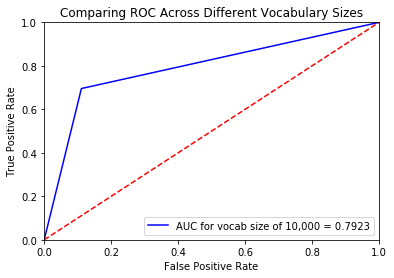

In [59]:
# Run this so your plots show properly
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
%matplotlib inline
#plt.rcParams['figure.figsize'] = 12, 12

val_predicted_y = []
val_y = []

for data, lengths, labels in val_loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        val_predicted_y += (outputs.max(1, keepdim=True)[1]).squeeze(1).tolist()
        val_y += labels.tolist()
        print((outputs.max(1, keepdim=True)))
        print(val_y)
        break

fpr_log_ct, tpr_log_ct, threshold_log_ct = roc_curve(val_y, val_predicted_y)
roc_auc_log_ct = auc(fpr_log_ct, tpr_log_ct)
print(roc_auc_log_ct)

plt.title('Comparing ROC Across Different Vocabulary Sizes')
plt.plot(fpr_log_ct, tpr_log_ct, 'b', label = 'AUC for vocab size of 10,000 = %0.4f' % roc_auc_log_ct)
# plt.plot(fpr_nb_ct, tpr_nb_ct, 'b', label = 'AUC for vocab size of 20,000 = %0.4f' % roc_auc_nb_ct, color='purple')
# plt.plot(fpr_log_tfidf, tpr_log_tfidf, 'b', label = 'AUC for vocab size of 40,000 = %0.4f' % roc_auc_log_tfidf, color='green')
# plt.plot(fpr_nb_tfidf, tpr_nb_tfidf, 'b', label = 'AUC for vocab size of 80,000 = %0.4f' % roc_auc_nb_tfidf, color='orange')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [21]:
# Assess performance on the test set
# Reading all of the negative and positive reviews into a tuple list
neg_path = 'aclImdb/test/neg'
pos_path = 'aclImdb/test/pos'
negative_files = [f for f in listdir(neg_path) if isfile(join(neg_path, f))]
postive_files = [f for f in listdir(pos_path) if isfile(join(pos_path, f))]

test_data = []
for neg_file in negative_files:
    with open(neg_path + '/' + neg_file, 'r') as f:
        review = f.read()
        test_data.append( (0,review) )
num_neg_reviews = len(test_data)
print('There are {} negative test reviews.'.format(num_neg_reviews))
for pos_file in postive_files:
    with open(pos_path + '/' + pos_file, 'r') as f:
        review = f.read()
        test_data.append( (1,review) )
print('There are {} positive test reviews.'.format(len(test_data) - num_neg_reviews))
print('Loaded {} examples'.format(str(len(test_data))))
print()
print(test_data[0])
print()
print(test_data[len(test_data)-1])   

There are 12500 negative test reviews.
There are 12500 positive test reviews.
Loaded 25000 examples

(0, "Alan Rickman & Emma Thompson give good performances with southern/New Orleans accents in this detective flick. It's worth seeing for their scenes- and Rickman's scene with Hal Holbrook. These three actors mannage to entertain us no matter what the movie, it seems. The plot for the movie shows potential, but one gets the impression in watching the film that it was not pulled off as well as it could have been. The fact that it is cluttered by a rather uninteresting subplot and mostly uninteresting kidnappers really muddles things. The movie is worth a view- if for nothing more than entertaining performances by Rickman, Thompson, and Holbrook.")

(1, 'I saw this movie on TV and loved it! I am a real disaster film fan, and this one was great. The cast was made of some really interesting people. Connie Selleca is always great. And William Devane is in a league of his own. He can play bo

In [23]:
# Create a validation set from the training data
test_x = [data_t[1] for data_t in test_data]
test_y = [data_t[0] for data_t in test_data]

print('{} test samples'.format(len(test_data)))
print([target for target in test_y[0:10]])

25000 test samples
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [24]:
# test set tokens
print ("Tokenizing test data")
test_data_tokens, _ = tokenize_dataset(test_x)
pkl.dump(test_data_tokens, open("test_data_tokens.p", "wb"))
print ("Test dataset size is {}".format(len(test_data_tokens)))

Tokenizing test data


Widget Javascript not detected.  It may not be installed or enabled properly.


In [29]:
test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))

# double checking
print ("Test dataset size is {}".format(len(test_data_tokens)))

test_data_indices = token2index_dataset(test_data_tokens)
test_dataset = ImdbDataset(test_data_indices, test_y)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)

Test dataset size is 25000


In [30]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

After training for 10 epochs
Val Acc 83.54
Test Acc 81.196


In [ ]:
fpr_log_ct, tpr_log_ct, threshold_log_ct = roc_curve(Y_test, preds_log_ct)
roc_auc_log_ct = auc(fpr_log_ct, tpr_log_ct)

plt.title('ROC For Test Set With Best Model')
plt.plot(fpr_nb_tfidf, tpr_nb_tfidf, 'b', label = 'AUC for tfidf Naive Bayes = %0.4f' % roc_auc_nb_tfidf, color='orange')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()